<a href="https://colab.research.google.com/github/AmandineLecerfDefer/OC_P7_Implementez_un_modele_de_scoring/blob/main/P07_01_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><u><font color='red'>Projet 7 : Implémentez un modèle de scoring</font></u><br> <br><font color='red'>Partie 1 : Preprocessing and analyse </font></center> 

Pour ce projet, je suis data scientist pour une entreprise qui propose des crédits. L'entreprise souhaite développer un modèle de scoring de la probabilité de défaut du client et l'associer à un tableau de bord interactif afin que les responsables de la relation client puissent expliquer avec la plus grande transparence les décisions d'octroi ou non d'un crédit.

Dans ce notebook, j'effectue le prétraitement des données et une exploration de celles-ci.

# <font color='green'>Setting up the work environment</font>

In [2]:
pip install termcolor

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=d8de6773aba66e98f71bbdd8fc2636c0dc4376e2382f9e78a0ff2380339b9df6
  Stored in directory: c:\users\fayca\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
Note: you may need to restart the kernel to use updated packages.


## <font color='blue'>Library</font>

In [1]:
# General
# File system management
import os
import glob

# Visualisation
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

import math
import scipy
import scipy.stats as stats
from scipy.stats import variation

import collections
from collections import Counter

from termcolor import colored

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline

## <font color='blue'>Parameters</font>

In [2]:
# Format & option
sns.set(rc={"figure.figsize": (16, 9)})
pd.options.display.max_columns = 150

# Style use
sns.set_style("darkgrid")
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# <font color='green'>Importing data</font>

Les données sont fournies par Home Credit, un service dédié à la fourniture de lignes de crédit (prêts) à la population non bancarisée. Prédire si un client remboursera ou non un prêt ou s'il aura des difficultés est un besoin commercial essentiel.

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\Drive/Data_projet_OC

print(
    os.listdir(
        r"/content/drive/MyDrive/Data_projet_OC/"
    )
)"""

'from google.colab import drive\ndrive.mount(\'/content/drive\')\n\n%cd /content/drive/My\\Drive/Data_projet_OC\n\nprint(\n    os.listdir(\n        r"/content/drive/MyDrive/Data_projet_OC/"\n    )\n)'

In [ ]:
#List of files.
print(
    os.listdir(
        r"/Users/fayca/P7/Data"
    )
)

['application_test.csv', '.DS_Store', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


Il y a un total de 9 fichiers : 1 fichier principal pour l'entraînement (avec la cible) 1 fichier principal pour le test (sans la cible), 1 fichier de description, et 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.

**application_{train|test}.csv**
les principales données de formation et de test contenant des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de demande d'entraînement sont accompagnées de la caractéristique TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.

**bureau.csv**
données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits précédents.

**bureau_balance.csv**
données mensuelles concernant les crédits précédents dans le bureau. Chaque ligne correspond à un mois de crédit antérieur, et un crédit antérieur unique peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.

**POS_CASH_balance.csv**
données mensuelles sur les prêts au point de vente ou au comptant que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.

**credit_card_balance.csv**
données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.

**previous_application.csv**
demandes précédentes de prêts au Home Credit des clients qui ont des prêts dans les données de demande. Chaque prêt actuel dans les données de la demande peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.

**installments_payments.csv**
historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

**HomeCredit_columns_description.csv**
Ce fichier contient les descriptions des colonnes des différents fichiers de données.

<font color='violet'>Existing relationships between the different files</font>

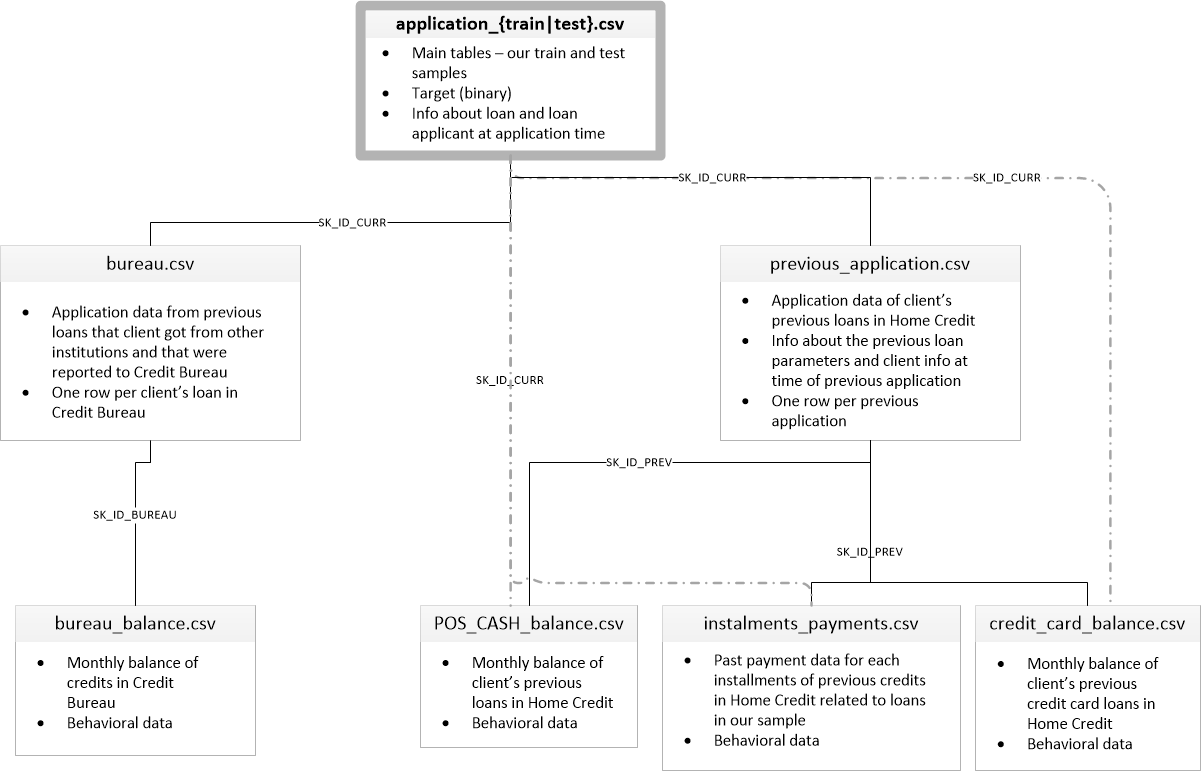

<font color='violet'>Train Test</font>

In [ ]:
default_dir = (
    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data"
)


"""default_dir = (
"/content/drive/MyDrive/Data_projet_OC/")"""


app_train = pd.read_csv(os.path.join(default_dir, "application_train.csv"))
app_test = pd.read_csv(os.path.join(default_dir, "application_test.csv"))

print(f"Training Data Shape: {app_train.shape}")
print(f"Testing Data Shape: {app_test.shape}")

app_train.head()

Training Data Shape: (307511, 122)
Testing Data Shape: (48744, 121)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

Le CSV train contient la cible, contrairement au CSV test.

In [ ]:
def get_balance_data():
    pos_dtype = {
        "SK_ID_PREV": np.uint64, "SK_ID_CURR": np.uint64, "MONTHS_BALANCE": np.int64, "SK_DPD": np.int64, 
        "SK_DPD_DEF": np.int64, "CNT_INSTALMENT": np.float64, "CNT_INSTALMENT_FUTURE": np.float64,
    }

    install_dtype = {
        "SK_ID_PREV": np.uint64, "SK_ID_CURR": np.uint64, "NUM_INSTALMENT_NUMBER": np.int64, "NUM_INSTALMENT_VERSION": np.float64,
        "DAYS_INSTALMENT": np.float64, "DAYS_ENTRY_PAYMENT": np.float64, "AMT_INSTALMENT": np.float64, "AMT_PAYMENT": np.float64
    }

    card_dtype = {
        "SK_ID_PREV": np.uint64, "SK_ID_CURR": np.uint64, "MONTHS_BALANCE": np.int64, "AMT_CREDIT_LIMIT_ACTUAL": np.int64,
        "CNT_DRAWINGS_CURRENT": np.int64, "SK_DPD": np.int64, "SK_DPD_DEF": np.int64, "AMT_BALANCE": np.float64,
        "AMT_DRAWINGS_ATM_CURRENT": np.float64, "AMT_DRAWINGS_CURRENT": np.float64, "AMT_DRAWINGS_OTHER_CURRENT": np.float64,
        "AMT_DRAWINGS_POS_CURRENT": np.float64, "AMT_INST_MIN_REGULARITY": np.float64, "AMT_PAYMENT_CURRENT": np.float64,
        "AMT_PAYMENT_TOTAL_CURRENT": np.float64, "AMT_RECEIVABLE_PRINCIPAL": np.float64, "AMT_RECIVABLE": np.float64,
        "AMT_TOTAL_RECEIVABLE": np.float64, "CNT_DRAWINGS_ATM_CURRENT": np.float64, "CNT_DRAWINGS_OTHER_CURRENT": np.float64,
        "CNT_DRAWINGS_POS_CURRENT": np.float64,  "CNT_INSTALMENT_MATURE_CUM": np.float64
    }

    bureau_dtype = {
        "SK_ID_BUREAU": np.uint64, "SK_ID_CURR": np.uint64, "DAYS_CREDIT": np.int64, "CREDIT_DAY_OVERDUE": np.int64,
        "DAYS_CREDIT_ENDDATE": np.float64, "DAYS_ENDDATE_FACT": np.float64, "AMT_CREDIT_MAX_OVERDUE": np.float64,
        "CNT_CREDIT_PROLONG": np.int64, "AMT_CREDIT_SUM": np.float64, "AMT_CREDIT_SUM_DEBT": np.float64,
        "AMT_CREDIT_SUM_LIMIT": np.float64, "AMT_CREDIT_SUM_OVERDUE": np.float64, "DAYS_CREDIT_UPDATE": np.int64,
        "AMT_ANNUITY": np.float64
    }

    previous_application_dtype = {
        "SK_ID_PREV": np.uint64, "SK_ID_CURR": np.uint64, "AMT_ANNUITY": np.float64, "AMT_APPLICATION": np.float64,
        "AMT_CREDIT": np.float64, "AMT_DOWN_PAYMENT": np.float64, "AMT_GOODS_PRICE": np.float64, "HOUR_APPR_PROCESS_START": np.float64,
        "NFLAG_LAST_APPL_IN_DAY": np.float64, "RATE_DOWN_PAYMENT": np.float64, "RATE_INTEREST_PRIMARY": np.float64,
        "RATE_INTEREST_PRIVILEGED": np.float64, "DAYS_DECISION": np.int64, "SELLERPLACE_AREA": np.int64,
        "CNT_PAYMENT": np.float64, "DAYS_FIRST_DRAWING": np.float64, "DAYS_FIRST_DUE": np.float64, "DAYS_LAST_DUE_1ST_VERSION": np.float64,
        "DAYS_LAST_DUE": np.float64, "DAYS_TERMINATION": np.float64, "NFLAG_INSURED_ON_APPROVAL": np.float64
    }
    
    bureau_balance_dtype = {
        "SK_ID_BUREAU": np.uint64, "MONTHS_BALANCE": np.int64
    }

    POS_CASH_balance = pd.read_csv(os.path.join(default_dir, "POS_CASH_balance.csv"), dtype=pos_dtype)

    installments_payments = pd.read_csv(os.path.join(default_dir, "installments_payments.csv"), dtype=install_dtype)

    credit_card_balance = pd.read_csv(os.path.join(default_dir, "credit_card_balance.csv"), dtype=card_dtype)

    bureau = pd.read_csv(os.path.join(default_dir, "bureau.csv"), dtype=bureau_dtype)

    previous_application = pd.read_csv(os.path.join(default_dir, "previous_application.csv"), dtype=previous_application_dtype)
    
    bureau_balance = pd.read_csv(os.path.join(default_dir, "bureau_balance.csv"), dtype=bureau_balance_dtype)
    
    return POS_CASH_balance, installments_payments, credit_card_balance, bureau, previous_application, bureau_balance

In [ ]:
POS_CASH_balance, installments_payments, credit_card_balance, bureau, previous_application, bureau_balance = get_balance_data()

In [ ]:
sample_submission = pd.read_csv(os.path.join(default_dir, "sample_submission.csv"))
pd.set_option("max_colwidth", 400)
HomeCredit_columns_description = pd.read_csv(os.path.join(default_dir, "HomeCredit_columns_description.csv"), encoding='mac_roman')
HomeCredit_columns_description

Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                                                                                                                                                                     Description  \
0                                                                                                                                                                       ID of loan in our sample   
1    Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2                                                                                                                                                    Identification if loan is cash or revolving   
3                                                                                                                                                                           Gender of the client   
4                                                                                                                                                                  Flag if the client owns a car   
..                                                                                                                                                                                           ...   
214                                                                                                                                                      On which installment we observe payment   
215                                                                               When the installment of previous credit was supposed to be paid (relative to application date of current loan)   
216                                                                                    When was the installments of previous credit paid actually (relative to application date of current loan)   
217                                                                                                            What was the prescribed installment amount of previous credit on this installment   
218                                                                                                                         What the client actually paid on previous credit on this installment   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

In [ ]:
def data_describe(folder):
    '''Check the number of rows, columns, missing values and duplicates.
       Count type of columns.
       Memory indication'''

    data_dict = {}
    for file in folder:
        data = pd.read_csv(file, encoding='mac_roman')
        data_dict[file] = [data.shape[0], 
                           data.shape[1],
                            round(data.isna().sum().sum()/data.size*100, 2),
                            round(data.duplicated().sum().sum()/data.size*100, 2),
                            data.select_dtypes(include=['object']).shape[1],
                            data.select_dtypes(include=['float']).shape[1],
                            data.select_dtypes(include=['int']).shape[1],
                            data.select_dtypes(include=['bool']).shape[1],
                            round(data.memory_usage().sum()/1024**2, 3)]

        comparative_table = pd.DataFrame.from_dict(data = data_dict, 
                                                   columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                              'object_dtype','float_dtype', 'int_dtype', 
                                                              'bool_dtype', 'MB_Memory'], 
                                                   orient='index')
    print("SUMMARY FILES…")
    return(comparative_table)

In [ ]:
"""#Data description
data_describe(glob.glob('/content/drive/MyDrive/Data_projet_OC/*.csv'))

#glob permet la recherche de tous les CSV par *.csv"""

"#Data description\ndata_describe(glob.glob('/content/drive/MyDrive/Data_projet_OC/*.csv'))\n\n#glob permet la recherche de tous les CSV par *.csv"

In [ ]:
#Data description
data_describe(glob.glob('/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/*.csv'))

#glob permet la recherche de tous les CSV par *.csv

SUMMARY FILES…


Rows  \
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_test.csv                   48744   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/HomeCredit_columns_description.csv       219   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/POS_CASH_balance.csv                10001358   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/credit_card_balance.csv              3840312   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/installments_payments.csv           13605401   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_train.csv                 307511   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/bureau.csv                           1716428   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/previous_application.csv             1670214   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/bureau_balance.csv                  27299925   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/sample_submission.csv                  48744   

                                                                                                                     Columns  \
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_test.csv                    121   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/HomeCredit_columns_description.csv        5   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/POS_CASH_balance.csv                      8   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/credit_card_balance.csv                  23   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/installments_payments.csv                 8   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_train.csv                   122   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/bureau.csv                               17   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/previous_application.csv                 37   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/bureau_balance.csv                        3   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/sample_submission.csv                     2   

                                                                                                                      %NaN  \
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_test.csv                23.81   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/HomeCredit_columns_description.csv  12.15   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/POS_CASH_balance.csv                 0.07   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/credit_card_balance.csv              6.65   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/installments_payments.csv            0.01   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_train.csv               24.40   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/bureau.csv                          13.50   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/previous_application.csv            17.98   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/bureau_balance.csv                   0.00   
/Users/amandinelecerfdefer/Deskt

In [ ]:
def features(folder):
    '''Comparative data with missing values, 
       and many descriptive statistics.'''
    
    data_object = {}
    data_numeric = {}
    
    for file in folder:
        data = pd.read_csv(file, encoding='mac_roman')
        
        data_object[file] = [(x, data[x].dtype, 
                              data[x].isna().sum().sum(),
                              int(data[x].count())) for x in data.select_dtypes(exclude=['int', 'float'])]
        
        data_numeric[file] = [(x, data[x].dtype, 
                               int(data[x].isna().sum().sum()), 
                               int(data[x].count()), 
                               int(data[x].mean()), 
                               round(data[x].std(),1),
                               round(data[x].min(),1), 
                               round(data[x].max(),1)) for x in data.select_dtypes(exclude='object')]
        

    comparative_object = pd.DataFrame.from_dict(data = data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name,file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis=0)
    df1.columns=['features','dtype','nan','count']
    
    comparative_numeric = pd.DataFrame.from_dict(data = data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis=0)
    df2.columns=['features','dtype','nan','count', 'mean', 'std', 'min','max']
        
    return df1, df2

In [ ]:
"""#Data description
features(glob.glob('/content/drive/MyDrive/Data_projet_OC/*.csv'))[0]

#glob permet la recherche de tous les CSV par *.csv"""

"#Data description\nfeatures(glob.glob('/content/drive/MyDrive/Data_projet_OC/*.csv'))[0]\n\n#glob permet la recherche de tous les CSV par *.csv"

In [ ]:
#Data description
features(glob.glob('/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/*.csv'))[0]

features  \
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_test.csv               0            NAME_CONTRACT_TYPE   
                                                                                                                    1                   CODE_GENDER   
                                                                                                                    2                  FLAG_OWN_CAR   
                                                                                                                    3               FLAG_OWN_REALTY   
                                                                                                                    4               NAME_TYPE_SUITE   
                                                                                                                    5              NAME_INCOME_TYPE   
                                                                                                                    6           NAME_EDUCATION_TYPE   
                                                                                                                    7            NAME_FAMILY_STATUS   
                                                                                                                    8             NAME_HOUSING_TYPE   
                                                                                                                    9               OCCUPATION_TYPE   
                                                                                                                    10   WEEKDAY_APPR_PROCESS_START   
                                                                                                                    11            ORGANIZATION_TYPE   
                                                                                                                    12           FONDKAPREMONT_MODE   
                                                                                                                    13               HOUSETYPE_MODE   
                                                                                                                    14           WALLSMATERIAL_MODE   
                                                                                                                    15          EMERGENCYSTATE_MODE   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/HomeCredit_columns_description.csv 0                         Table   
                                                                                                                    1                           Row   
                                                                                                                    2                   Description   
                                                                                                                    3                       Special   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/POS_CASH_balance.csv               0          NAME_CONTRACT_STATUS   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/credit_card_balance.csv            0          NAME_CONTRACT_STATUS   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_train.csv              0            NAME_CONTRACT_TYPE   
                                                                                                                    1                   CODE_GENDER   
                                                                                                                    2                  FLAG_OWN_CAR   
                                                                                                                    3               FLAG_OWN_REALTY   
                                                              

In [ ]:
"""#Data description
features(glob.glob('/content/drive/MyDrive/Data_projet_OC/*.csv'))[1]

#glob permet la recherche de tous les CSV par *.csv"""

"#Data description\nfeatures(glob.glob('/content/drive/MyDrive/Data_projet_OC/*.csv'))[1]\n\n#glob permet la recherche de tous les CSV par *.csv"

In [ ]:
#Data description
features(folder=glob.glob('/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/*.csv'))[1]

features  \
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_test.csv     0                  SK_ID_CURR   
                                                                                                          1                CNT_CHILDREN   
                                                                                                          2            AMT_INCOME_TOTAL   
                                                                                                          3                  AMT_CREDIT   
                                                                                                          4                 AMT_ANNUITY   
...                                                                                                                                 ...   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/previous_application.csv 20  NFLAG_INSURED_ON_APPROVAL   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/bureau_balance.csv       0                SK_ID_BUREAU   
                                                                                                          1              MONTHS_BALANCE   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/sample_submission.csv    0                  SK_ID_CURR   
                                                                                                          1                      TARGET   

                                                                                                                dtype  \
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_test.csv     0     int64   
                                                                                                          1     int64   
                                                                                                          2   float64   
                                                                                                          3   float64   
                                                                                                          4   float64   
...                                                                                                               ...   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/previous_application.csv 20  float64   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/bureau_balance.csv       0     int64   
                                                                                                          1     int64   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/sample_submission.csv    0     int64   
                                                                                                          1   float64   

                                                                                                                 nan  \
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/application_test.csv     0        0   
                                                                                                          1        0   
                                                                                                          2        0   
                                                                                                          3        0   
                                                                                                          4       24   
...                                                                                                              ...   
/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet7/Data/previous_application.csv 20  673065   
/Users/amandinelecerfdefer/Desktop/Formation_

# <font color='green'>Exploratory Data Analysis (EDA) : Train and Test CSV</font>

Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Données statistiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

## <font color='blue'>Firsts obsersations</font>

In [ ]:
def informations(dataframe):
    """This function gives the general information of a dataset.
    It returns the number of rows and columns of the dataset.
    dataframe : dataset"""
    print(colored("\n Overview of the dataset : \n", 'red'))
    lines = dataframe.shape[0]
    columns = dataframe.shape[1]
    print(colored("The dataset has {} rows and {} "
                  "columns. \n \n".format(lines, columns), 'blue'))
    print(colored("Column's name : \n", 'green'))
    print(list(dataframe.columns))
    print("\n")
    print(colored("Column's Type : \n", 'green'))
    print(list(dataframe.dtypes))
    print("\n")

In [ ]:
informations(app_train)


 Overview of the dataset : 

The dataset has 307511 rows and 122 columns. 
 

Column's name : 

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_A

L'ensemble d'apprentissage comporte 307 511 observations (prêts) et 122 colonnes. 

In [ ]:
#Check if 'TARGET' is the only difference
print("Check theses which columns are differents in the two files.")
display(app_train.columns.difference(app_test.columns))

Check theses which columns are differents in the two files.


Index(['TARGET'], dtype='object')

La TARGET est ce que l'on nous demande de prédire : soit un 0 pour le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d'abord examiner le nombre de prêts entrant dans chaque catégorie.

In [ ]:
app_train.groupby(['TARGET'])['SK_ID_CURR'].count()

TARGET
0    282686
1     24825
Name: SK_ID_CURR, dtype: int64

In [ ]:
def graphe_col_category(dataframe, col, size, name):
    """This function represents the categorical variables as a pie plot.
    dataframe : dataset
    size : size of the figure (X,X)"""
    values = dataframe[col].value_counts()
    labels = dataframe[col].value_counts().index
    plt.figure(figsize=size)
    
    #bar plot
    plt.subplot(2, 2, 1)
    sns.barplot(x=labels, 
            y=values,
            palette='pink')
    
    # Pie Plot
    plt.subplot(2, 2, 2)
    plt.title("Representation of the variable {}" .format(
        col), fontsize=20)
    plt.pie(values, labels=name,
            autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    plt.axis('equal')
    plt.tight_layout()
    plt.legend()
    plt.show()

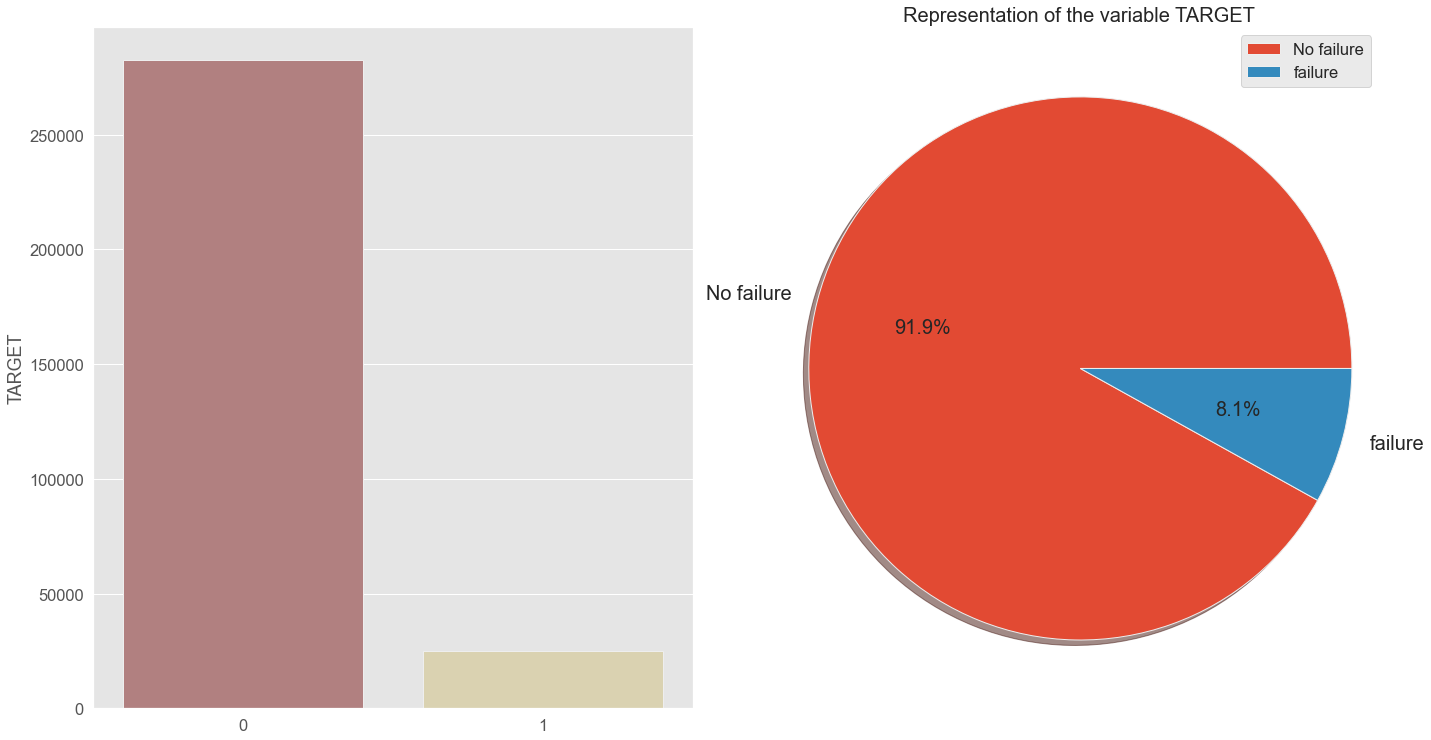

In [ ]:
graphe_col_category(app_train, 'TARGET', (20,20), ['No failure', 'failure'])

On remarque que les classes sont déséquilibrées, il y a beaucoup plus d'individus dans la classe 0 que de dans la classe 1. 
https://ichi.pro/fr/apprentissage-desequilibre-gerer-un-probleme-de-classe-desequilibre-71099907199579 

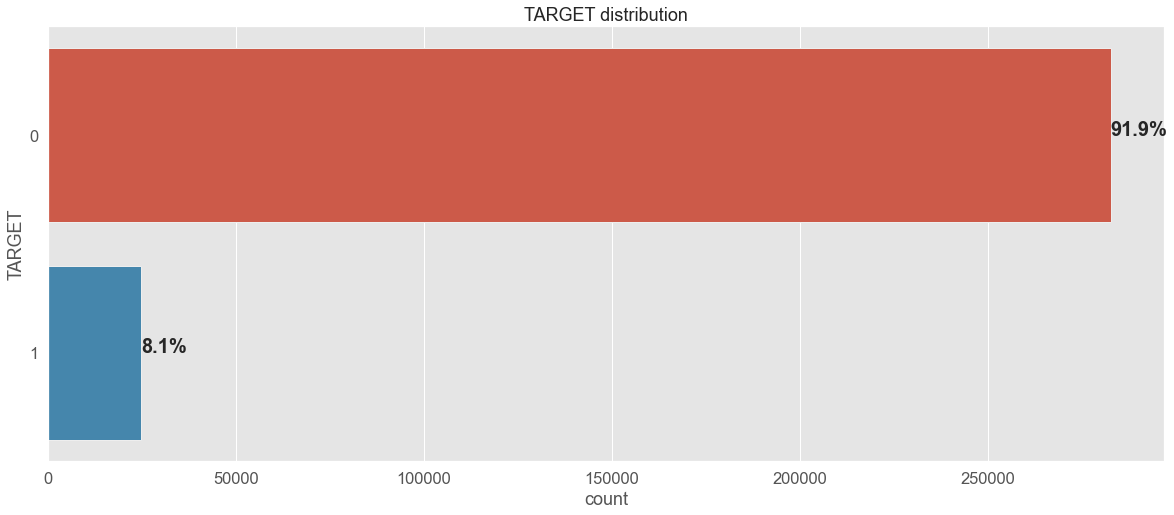

In [ ]:
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='TARGET', data=app_train)
ax.set_title("TARGET distribution")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(app_train.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
plt.show()

Text(0.5, 1.0, 'Gender distribution of individuals in the testing set')

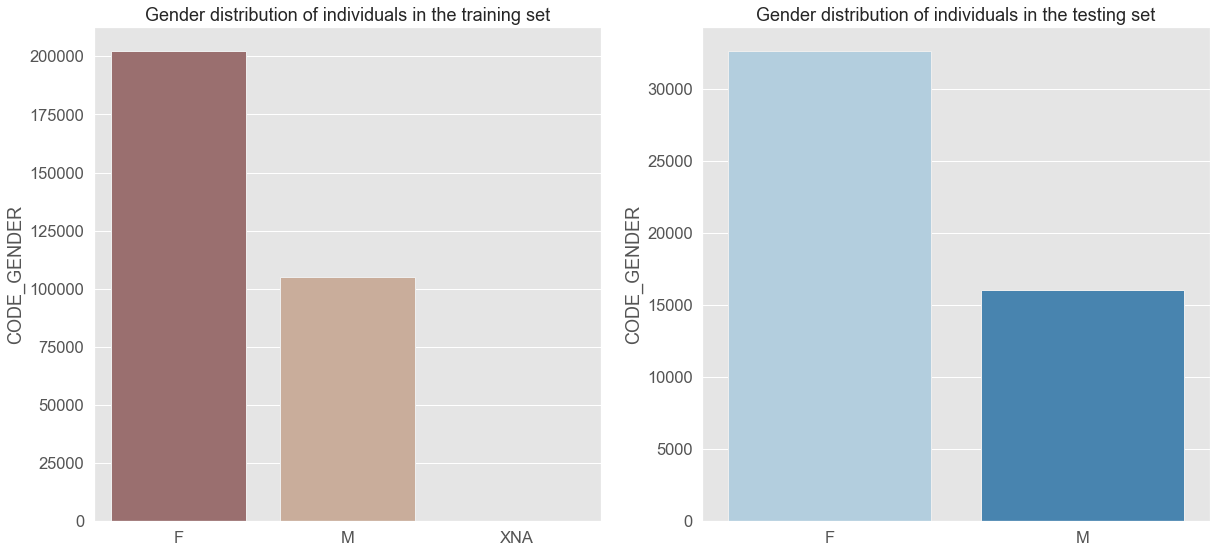

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
sns.barplot(x=app_train['CODE_GENDER'].value_counts().index, 
            y=app_train['CODE_GENDER'].value_counts(), palette='pink').set_title("Gender distribution of individuals in the training set")

plt.subplot(2, 2, 2)
sns.barplot(x=app_test['CODE_GENDER'].value_counts().index, 
            y=app_test['CODE_GENDER'].value_counts(), palette='Blues').set_title("Gender distribution of individuals in the testing set")

On peut voir qu'il y a une troisième modalité pour le sexe (également présente pour d'autres colonnes) qui semble correspondre à des données manquantes (différentes notations entre les personnes).

In [ ]:
app_train = app_train.replace('XNA', np.nan)
app_test = app_test.replace('XNA', np.nan)

Text(0.5, 1.0, 'Gender distribution of individuals in the testing set')

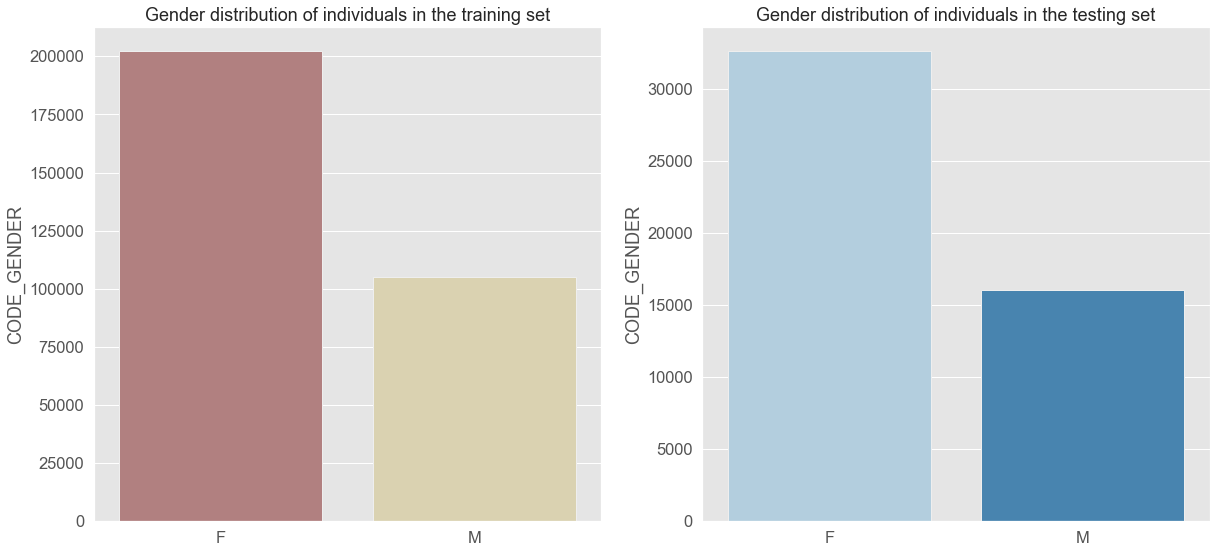

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
sns.barplot(x=app_train['CODE_GENDER'].value_counts().index, 
            y=app_train['CODE_GENDER'].value_counts(), palette='pink').set_title("Gender distribution of individuals in the training set")

plt.subplot(2, 2, 2)
sns.barplot(x=app_test['CODE_GENDER'].value_counts().index, 
            y=app_test['CODE_GENDER'].value_counts(), palette='Blues').set_title("Gender distribution of individuals in the testing set")

In [ ]:
app_train['CODE_GENDER'].describe()

count     307507
unique         2
top            F
freq      202448
Name: CODE_GENDER, dtype: object

## <font color='blue'>Types of columns</font>

In [ ]:
# number of columns of each type.
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Nombre unique d'entrées pour chaque colonne de chaque type de données

In [ ]:
app_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques.

In [ ]:
app_train.select_dtypes('int').apply(pd.Series.nunique)

SK_ID_CURR                     307511
TARGET                              2
CNT_CHILDREN                       15
DAYS_BIRTH                      17460
DAYS_EMPLOYED                   12574
DAYS_ID_PUBLISH                  6168
FLAG_MOBIL                          2
FLAG_EMP_PHONE                      2
FLAG_WORK_PHONE                     2
FLAG_CONT_MOBILE                    2
FLAG_PHONE                          2
FLAG_EMAIL                          2
REGION_RATING_CLIENT                3
REGION_RATING_CLIENT_W_CITY         3
HOUR_APPR_PROCESS_START            24
REG_REGION_NOT_LIVE_REGION          2
REG_REGION_NOT_WORK_REGION          2
LIVE_REGION_NOT_WORK_REGION         2
REG_CITY_NOT_LIVE_CITY              2
REG_CITY_NOT_WORK_CITY              2
LIVE_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_2                     2
FLAG_DOCUMENT_3                     2
FLAG_DOCUMENT_4                     2
FLAG_DOCUMENT_5                     2
FLAG_DOCUMENT_6                     2
FLAG_DOCUMEN

In [ ]:
app_train_int = list(app_train.select_dtypes('int'))
app_test_int = list(app_test.select_dtypes('int'))

In [ ]:
app_train.select_dtypes('float').apply(pd.Series.nunique)

AMT_INCOME_TOTAL               2548
AMT_CREDIT                     5603
AMT_ANNUITY                   13672
AMT_GOODS_PRICE                1002
REGION_POPULATION_RELATIVE       81
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY         9
AMT_REQ_CREDIT_BUREAU_WEEK        9
AMT_REQ_CREDIT_BUREAU_MON        24
AMT_REQ_CREDIT_BUREAU_QRT        11
AMT_REQ_CREDIT_BUREAU_YEAR       25
Length: 65, dtype: int64

## <font color='blue'>Missing data</font>

In [ ]:
def pie_NaN(dataframe, size):
    """This function allows to make a pie plot showing the
    proportion of missing data on the whole dataset.
    dataframe : dataset
    size : size of the figure (X,X)"""
    lines = dataframe.shape[0]
    columns = dataframe.shape[1]
    # NAN data
    nb_data = dataframe.count().sum()
    # Total data = (colonnes*lignes)
    nb_totale = (columns*lines)
    # Filling rate
    rate_dataOK = (nb_data/nb_totale)
    print("The data set is filled in at {:.2%}".format(rate_dataOK))
    print("and it has {:.2%} of missing data".format(1-rate_dataOK))
    print("\n \n ")
    # Pie Plot
    rates = [rate_dataOK, 1 - rate_dataOK]
    labels = ["Données", "NAN"]
    explode = (0, 0.1)
    colors = ['gold', 'pink']
    # Plot
    plt.figure(figsize=size)
    plt.pie(rates, explode=explode, labels=labels, colors=colors,
            autopct='%.2f%%', shadow=True, textprops={'fontsize': 26})
    ttl = plt.title("Fill rate of the dataset", fontsize=32)
    ttl.set_position([0.5, 0.85])
    plt.axis('equal')
    # ax.legend(labels, loc = "upper right", fontsize = 18)
    plt.tight_layout()
    plt.show()

The data set is filled in at 75.46%
and it has 24.54% of missing data

 
 


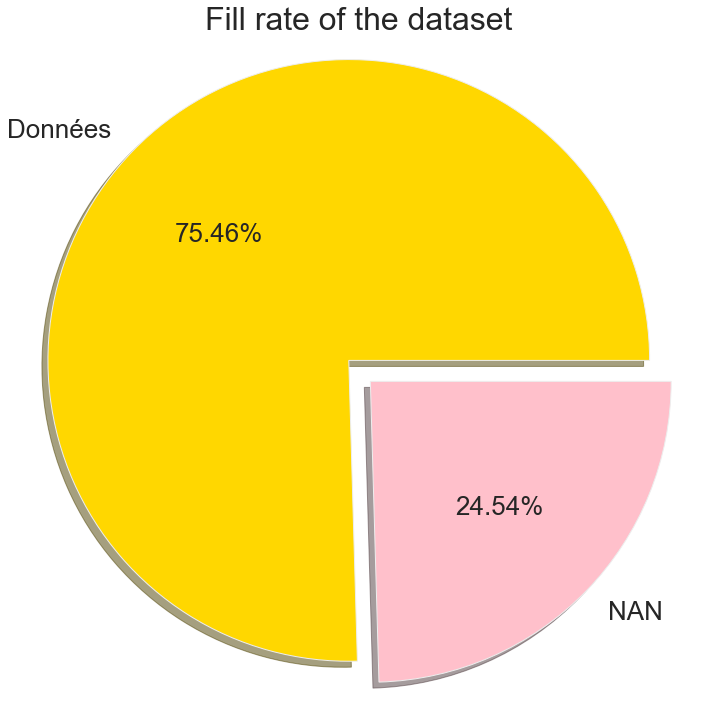

In [ ]:
pie_NaN(app_train, (10,10))

Dans le jeu de données de formation, il y a plus de 24% de données manquantes, voyons dans quelles colonnes précisément.

<AxesSubplot:>

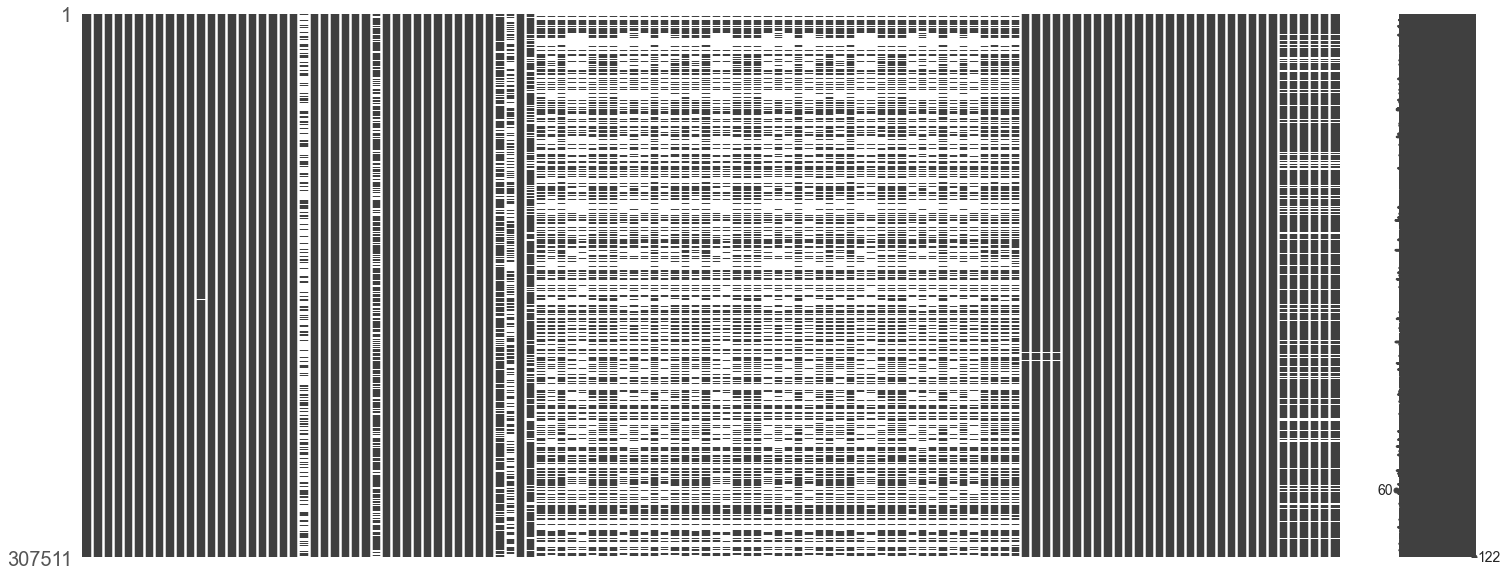

In [ ]:
msno.matrix(app_train)

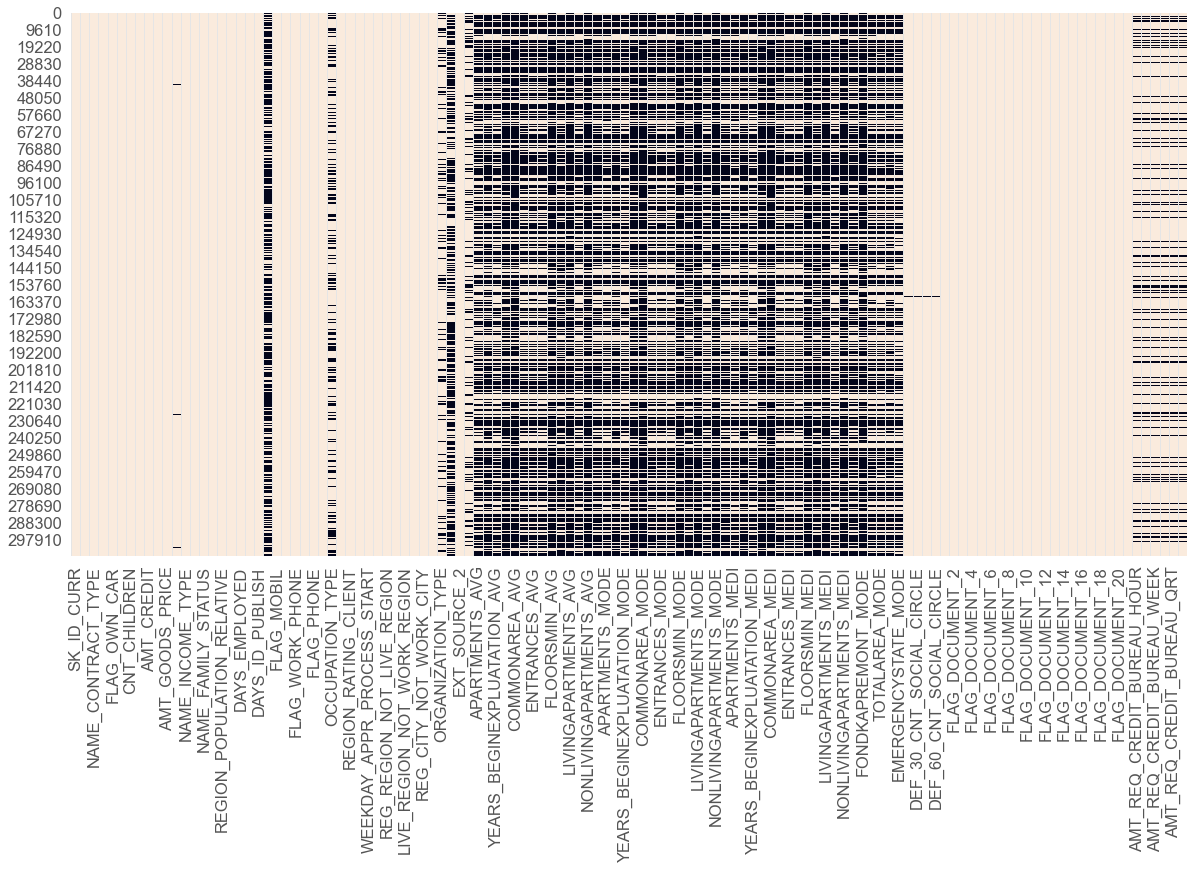

In [ ]:
#Global view of the missing values (black)
plt.figure(figsize=(20,10))
sns.heatmap(app_train.notna(), cbar=False)
plt.show()

Les données manquantes sont plus fortement présentent sur les caractéristiques des habitats (et non sur les crédits).

In [ ]:
# Function to calculate the % of missing data on the entered dataset.
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [ ]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 69 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
FLOORSMIN_MODE                    208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_MEDI                     182590               59.4
LANDAREA_AVG                      182590               59.4
LANDAREA_MODE                     182590               59.4

In [ ]:
# NaN on categorical variables.
app_train.select_dtypes('object').isna().sum(axis=0)

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        4
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE              55374
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [ ]:
# NaN on ints.
app_train.select_dtypes('int').isna().sum()

SK_ID_CURR                     0
TARGET                         0
CNT_CHILDREN                   0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_7                0
FLAG_DOCUMENT_8                0
FLAG_DOCUMENT_9                0
FLAG_DOCUMENT_10               0
FLAG_DOCUM

Il n'y a pas de données manquantes pour ce type de données.

In [ ]:
# NaN on the floats.
app_train.select_dtypes('float').isna().sum()

AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                      12
AMT_GOODS_PRICE                 278
REGION_POPULATION_RELATIVE        0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 65, dtype: int64

## <font color='blue'>Duplicate</font>

In [ ]:
list_names = ['app_train', 'app_test']
datasets = [app_train, app_test]
for name in list_names:
    pos = list_names.index(name)
    dataset = datasets[pos]
    print("Duplicate of the dataset {}." .format(name))
    print(dataset.duplicated('SK_ID_CURR').sum())
    print("\n")

Duplicate of the dataset app_train.
0


Duplicate of the dataset app_test.
0




Il n'y a pas de doublon dans les jeux de données app_train et app_test.

## <font color='blue'>Outliers, valeurs atypiques, anormales </font>

Ces erreurs peuvent être dues à des chiffres mal saisis, à des erreurs dans l'équipement de mesure ou à des mesures valides mais extrêmes.

**DAYS_BIRTH**

Les chiffres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons les multiplier par -1 et les diviser par le nombre de jours dans une année 

In [ ]:
app_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

Les valeurs sont négatives car enregistrées par rapport à la demande du prêt en cours. Il faut modifier ces dates pour plus de compréhension.

In [ ]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

En moyenne, les clients ont 43 ans, le plus jeune a 20 ans et le plus âgé 69 ans. 50% des clients ont moins de 43 ans. Nous pouvons donc dire que l'étude est principalement axée sur les personnes d'une quarantaine d'années.

In [ ]:
app_train['AGE'] = round(app_train['DAYS_BIRTH'] / -365).astype('int')
app_test['AGE'] = round(app_test['DAYS_BIRTH'] / -365).astype('int')

In [ ]:
app_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801       -9461   
1       House / apartment                    0.003541      -16765   
2       House / apartment                    0.010032      -19046   
3       House / apartment                    0.008019      -19005   
4       House / apartment                    0.028663      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032561       -9327   
307507  House / apartment       

Text(0, 0.5, 'Count')

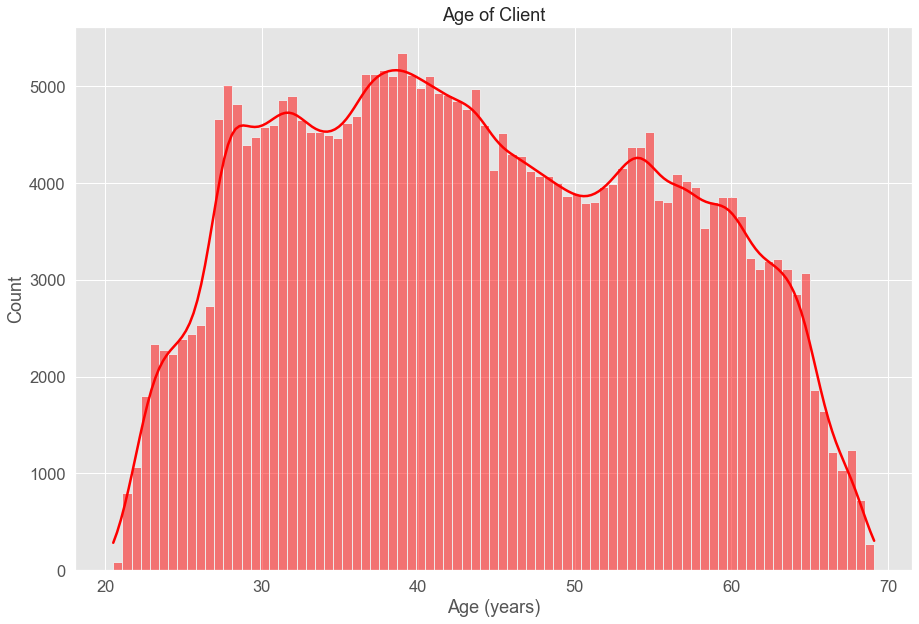

In [ ]:
 # Distribution des âges. (en année)
plt.figure(figsize=(15,10))
sns.histplot(app_train['DAYS_BIRTH'] / -365, stat='count', color='red', kde="True")
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

 Il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables

**DAYS_EMPLOYED**
How many days before the application the person started current employment,time only relative to the application

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
app_test['DAYS_EMPLOYED'].describe()

count     48744.000000
mean      67485.366322
std      144348.507136
min      -17463.000000
25%       -2910.000000
50%       -1293.000000
75%        -296.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

<AxesSubplot:title={'center':'Number of working day-test'}, xlabel='DAYS_EMPLOYED'>

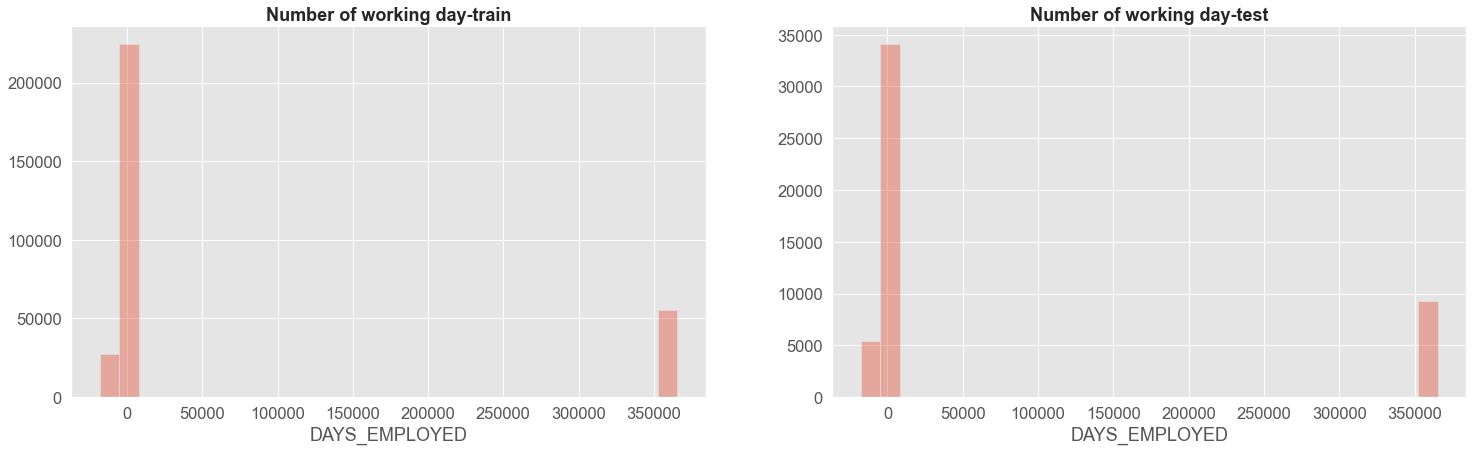

In [ ]:
plt.figure(figsize = (25, 15))
plt.subplot(2, 2, 1)
plt.title('Number of working day-train', weight='bold', size=18)
sns.distplot(app_train['DAYS_EMPLOYED'], kde=False, bins=30)

plt.subplot(2, 2, 2)
plt.title('Number of working day-test', weight='bold', size=18)
sns.distplot(app_test['DAYS_EMPLOYED'], kde=False, bins=30)

Ici avec cette analyse, on peut voir qu'il y a des données anormales car le maximun représente environ 100 ans de travail (ce qui est impossible).

In [ ]:
anom = app_train[app_train['DAYS_EMPLOYED'] >= 350000]
non_anom = app_train[app_train['DAYS_EMPLOYED'] < 350000]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


When there are no anomalies, there is an average of 8,66% default. The anomalies have 5,40% of default and therefore a lower rate. We will fill in the anomalous values with not a number (np.nan) and change the number of days to the average number of days worked.

In [ ]:
anom['DAYS_EMPLOYED'].unique()

array([365243])

In [ ]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED_ANOM'].astype('object')


app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED_ANOM'].astype('object')

In [ ]:
app_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
AGE                             int64
DAYS_EMPLOYED_ANOM             object
Length: 124, dtype: object

In [ ]:
# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

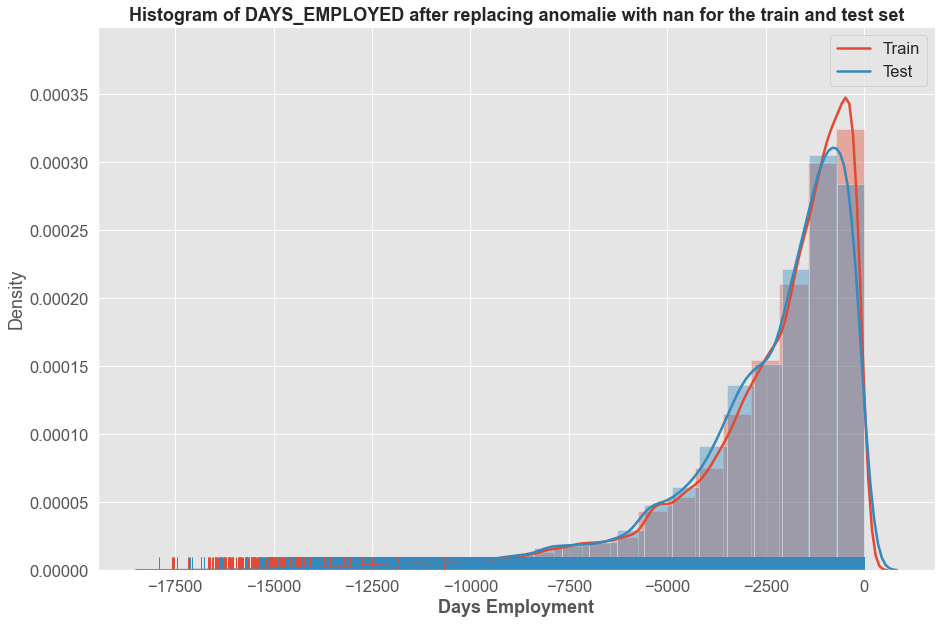

There are 55374 anomalies in the test data out of 307511 entries in the train set

There are 9274 anomalies in the test data out of 48744 entries in the test set



In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(app_train['DAYS_EMPLOYED'], hist=True, rug=True, bins=25)
sns.distplot(app_test['DAYS_EMPLOYED'], hist=True, rug=True, bins=25)
plt.title('Histogram of DAYS_EMPLOYED after replacing anomalie with nan for the train and test set',
          weight='bold', size=18)
plt.xlabel('Days Employment', weight="bold")
labels= ["Train", "Test"]
plt.legend(labels)
plt.show()

print('There are %d anomalies in the test data out of %d entries in the train set\n' % (app_train["DAYS_EMPLOYED"].isna().sum(), len(app_train)))
print('There are %d anomalies in the test data out of %d entries in the test set\n' % (app_test["DAYS_EMPLOYED"].isna().sum(), len(app_test)))

# <font color='green'>Analyse : Train</font>

In [ ]:
def test_train_col_category(dataframe_train, dataframe_test, col, size):
    """This function represents the categorical variables as a pie plot.
    dataframe : dataset
    size : size of the figure (X,X)"""
    values_train = dataframe_train[col].value_counts()
    labels_train = dataframe_train[col].value_counts().index
    values_test = dataframe_test[col].value_counts()
    labels_test = dataframe_test[col].value_counts().index
    
    plt.figure(figsize=size)
    
    #pie plot
    plt.subplot(2, 2, 1)
    plt.title("Representation of the variable {} for training set" .format(
        col), fontsize=20)
    plt.pie(values_train, labels=labels_train,
            autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    
    
    # Pie Plot
    plt.subplot(2, 2, 2)
    plt.title("Representation of the variable {} for testing set" .format(
        col), fontsize=20)
    plt.pie(values_test, labels=labels_test,
            autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    plt.axis('equal')
    plt.tight_layout()
    plt.legend()
    plt.show()

In [ ]:
def plot_stat(data, feature, title, size) : 
    
    ax, fig = plt.subplots(figsize=size) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

In [ ]:
def plot_percent_target1(data, feature, title, size) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=size) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Percent of target with value 1")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

**Loan types** - Distribution du type de prêts contractés

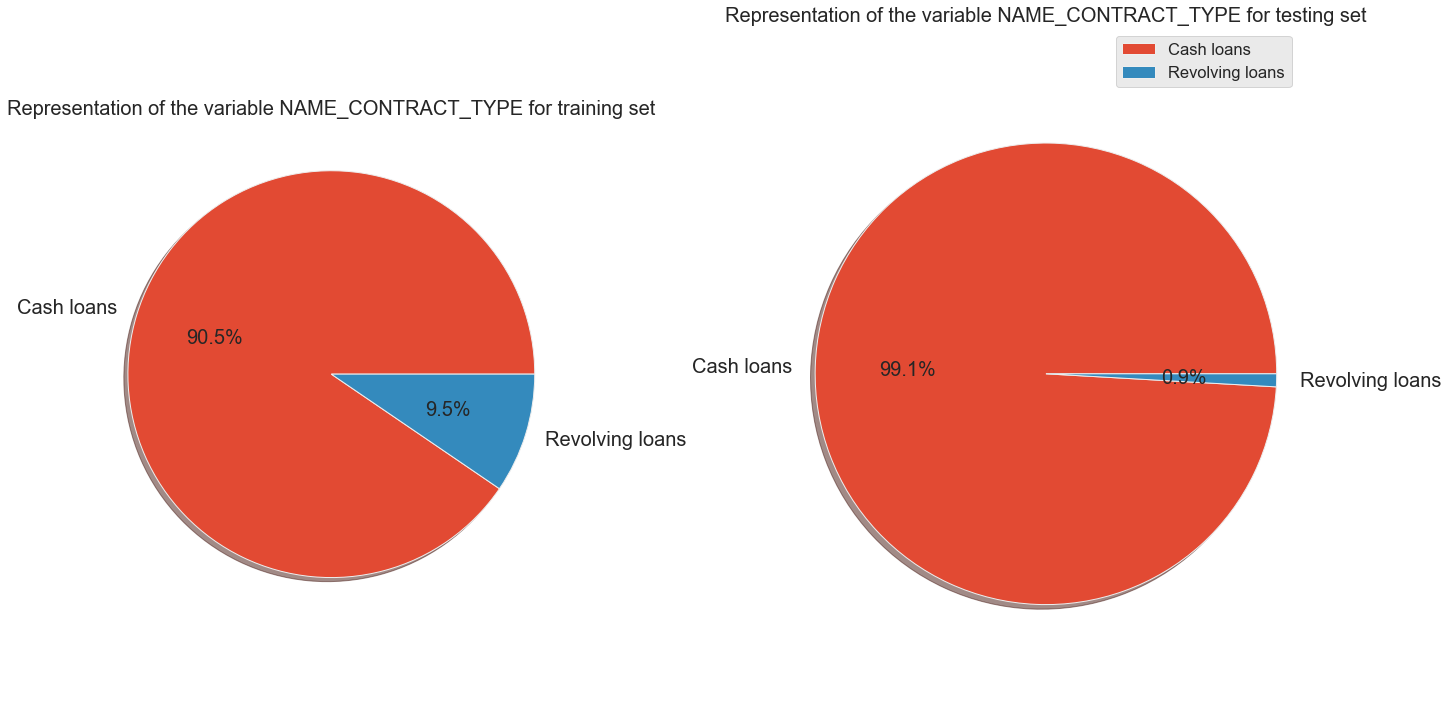

In [ ]:
test_train_col_category(app_train, app_test, 'NAME_CONTRACT_TYPE', (20,20))

Les prêts renouvelables ne représentent que 10% du nombre total de prêts

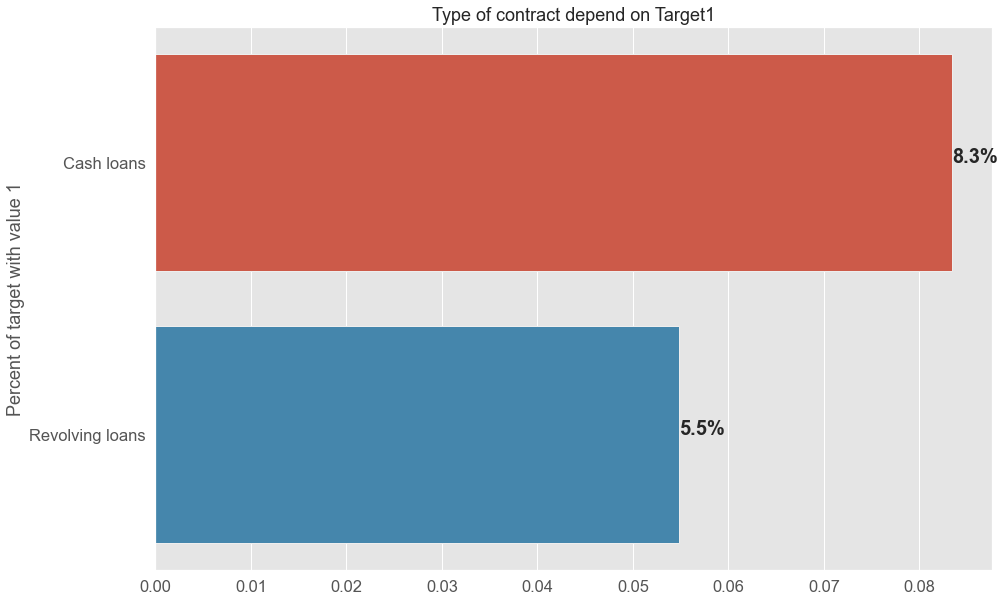

In [ ]:
plot_percent_target1(app_train, 'NAME_CONTRACT_TYPE',"Type of contract depend on Target1", (15,10))

La majorité des crédits non remboursés sont non renouvelables. (étude par rapport à leur fréquence d'apparition).

**Client gender** - Distribution H/F clients selon le remboursement du prêt

Précédement, nous avons pu voir que les clients du genre féminin sont deux fois plus présents que les clients masculins dans le jeu de données.

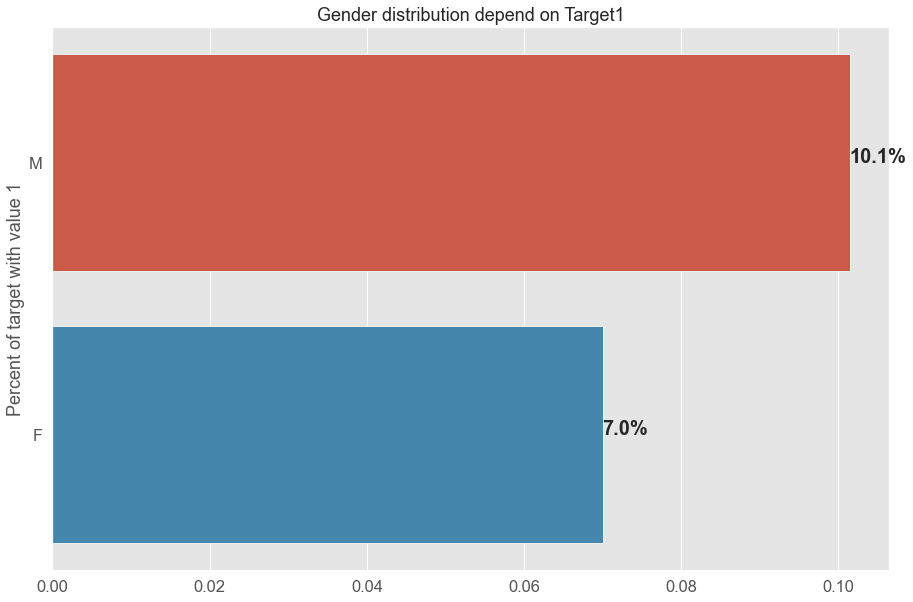

In [ ]:
plot_percent_target1(app_train, 'CODE_GENDER',"Gender distribution depend on Target1", (15,10))

Les hommes ont tendance à moins rembourser leur crédits.

**Flag own car** - Distribution de la possession d'une voiture

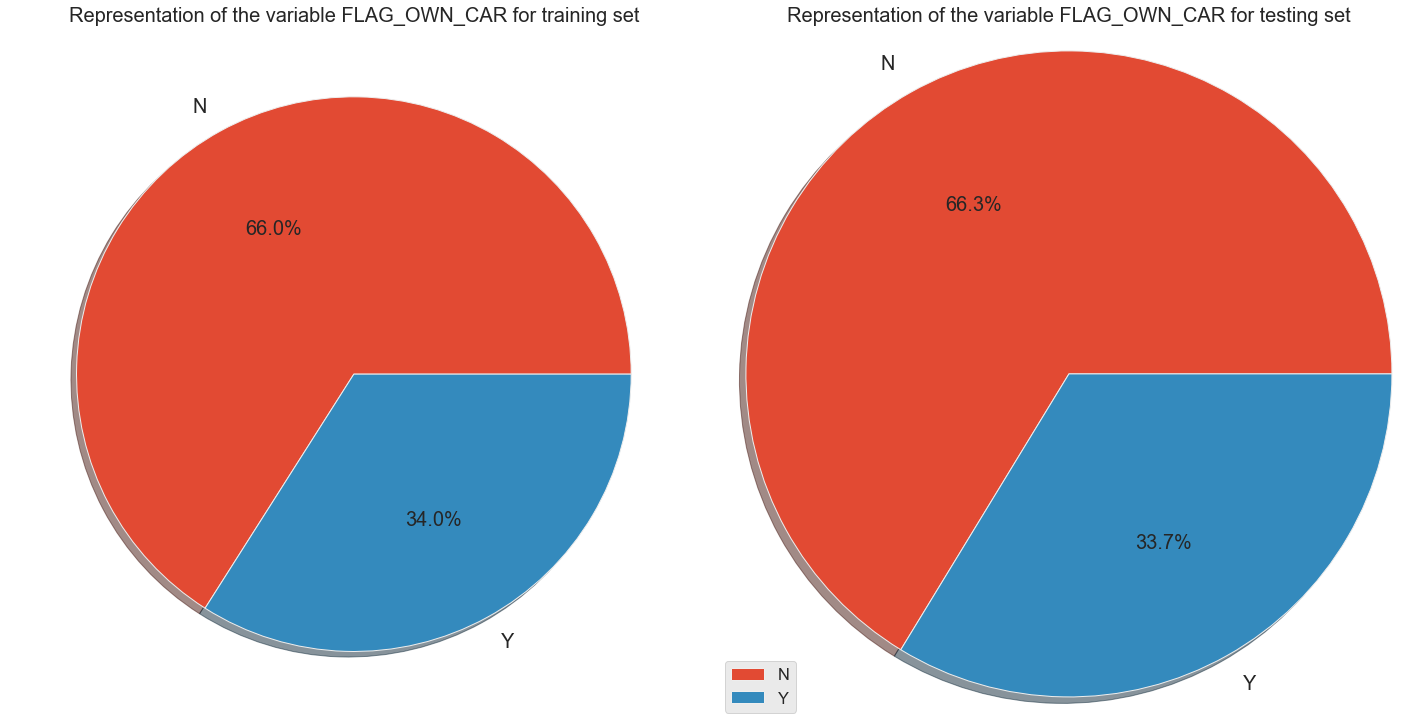

In [ ]:
test_train_col_category(app_train, app_test, 'FLAG_OWN_CAR', (20,20))

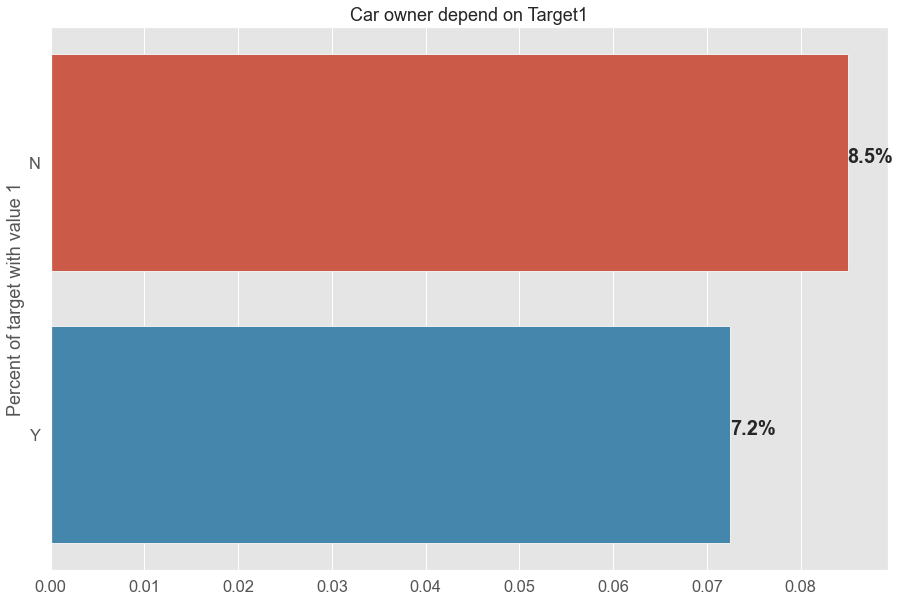

In [ ]:
plot_percent_target1(app_train, 'FLAG_OWN_CAR',"Car owner depend on Target1", (15,10))

Le taux de non remboursement est de 8% que le client ait ou non une voiture.

**Cnt Children** - Distribution du nombre d'enfants

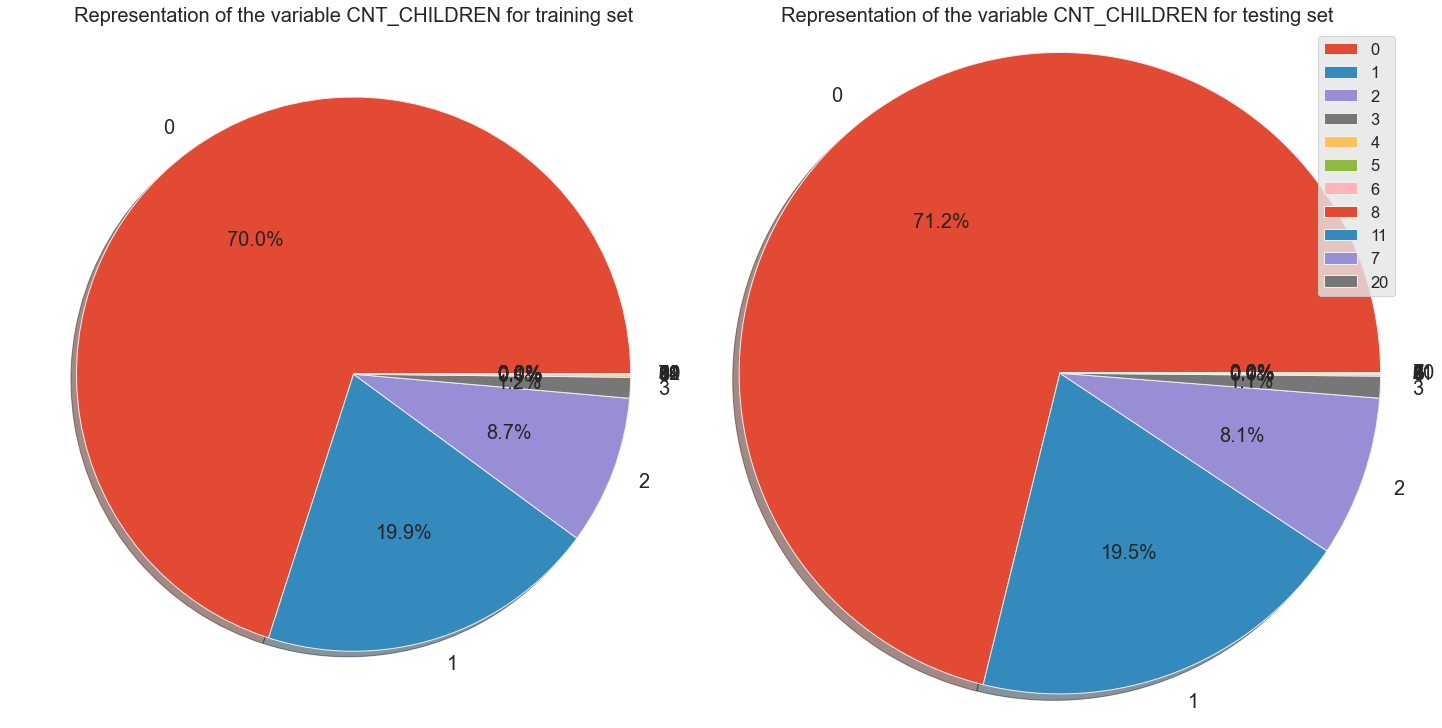

In [ ]:
test_train_col_category(app_train, app_test, 'CNT_CHILDREN', (20,20))

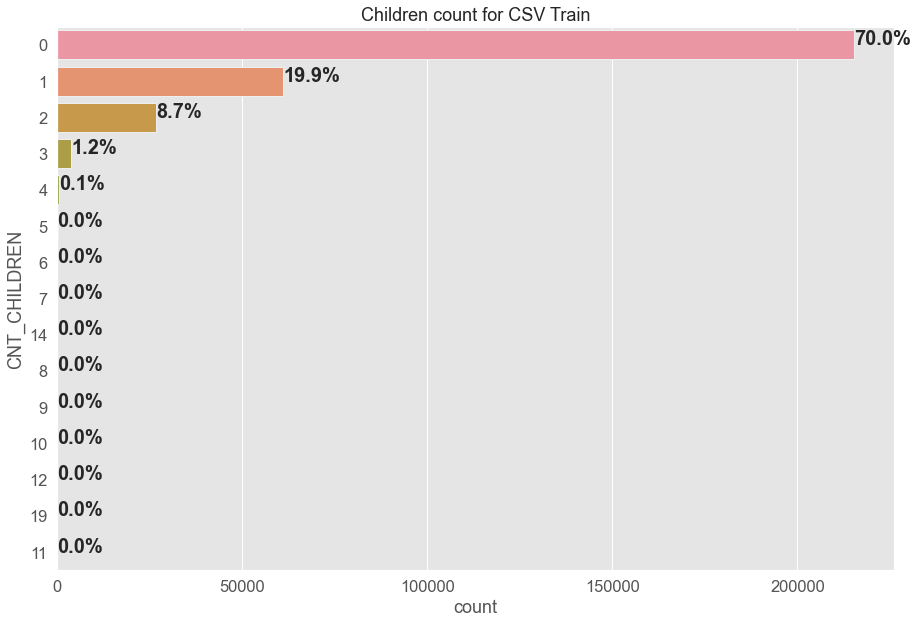

In [ ]:
plot_stat(app_train, 'CNT_CHILDREN', 'Children count for CSV Train', (15,10)) 

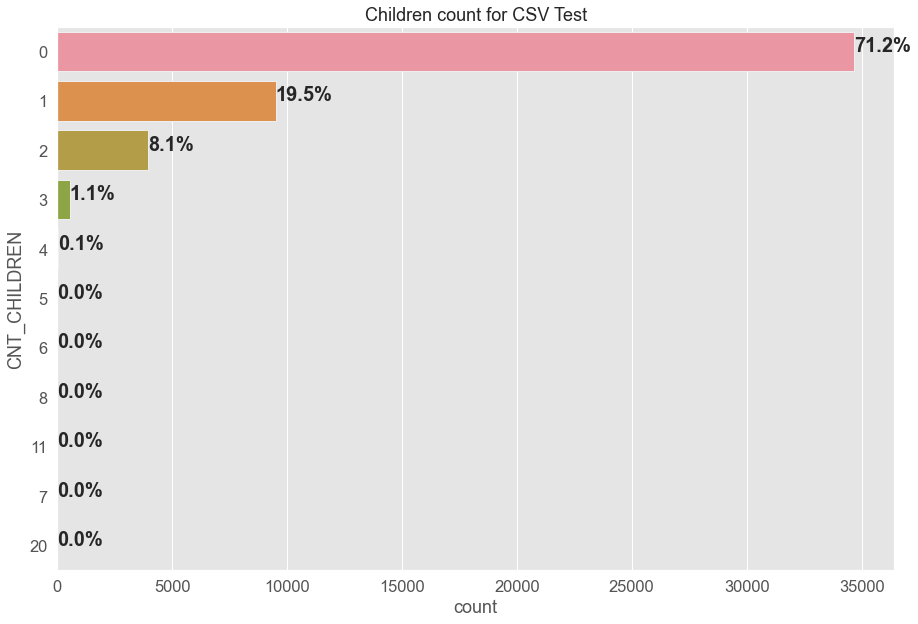

In [ ]:
plot_stat(app_test, 'CNT_CHILDREN', 'Children count for CSV Test', (15,10)) 

En ce qui concerne le nombre d'enfants, nous pouvons constater que la majorité des clients n'ont pas d'enfant. Plus de 20% des clients ont 1 enfant, 8% en ont 2 et 1% en ont 3. Les proportions sont assez équivalentes entre le test d'entraînement et le test d'essai.

**Family Status** - Distribution du status familial

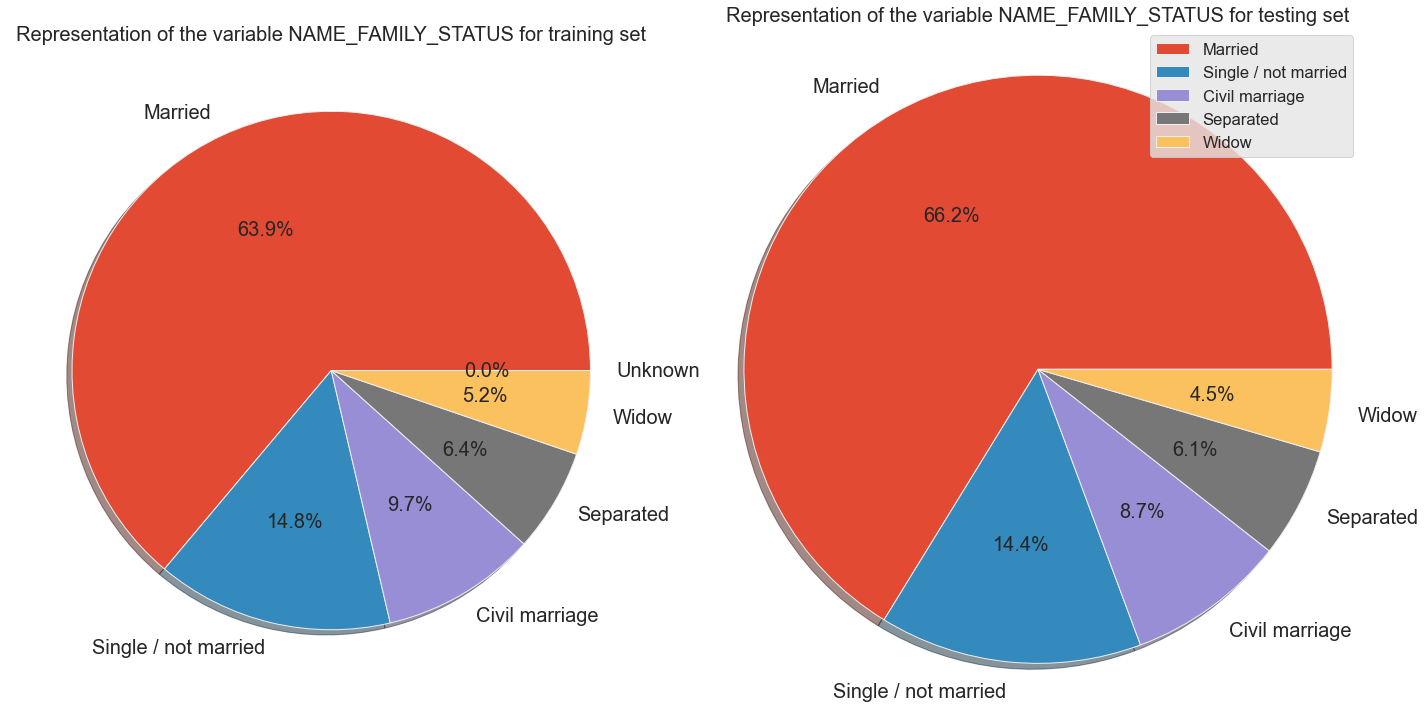

In [ ]:
test_train_col_category(app_train, app_test, 'NAME_FAMILY_STATUS', (20,20))

La grande majorité des clients sont mariés ou en couple.

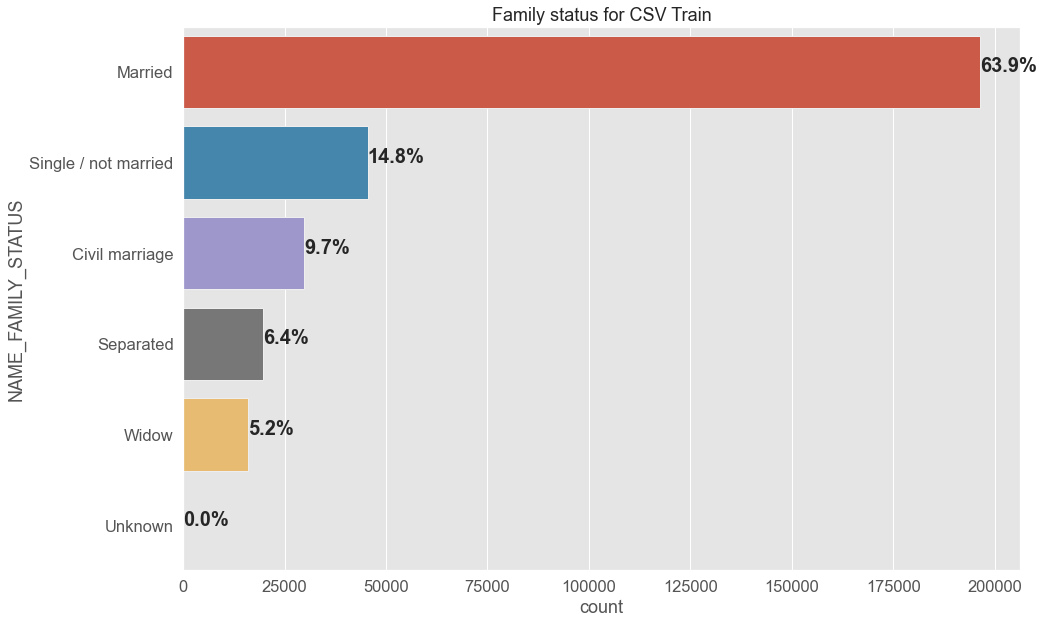

In [ ]:
plot_stat(app_train, 'NAME_FAMILY_STATUS', 'Family status for CSV Train', (15,10)) 

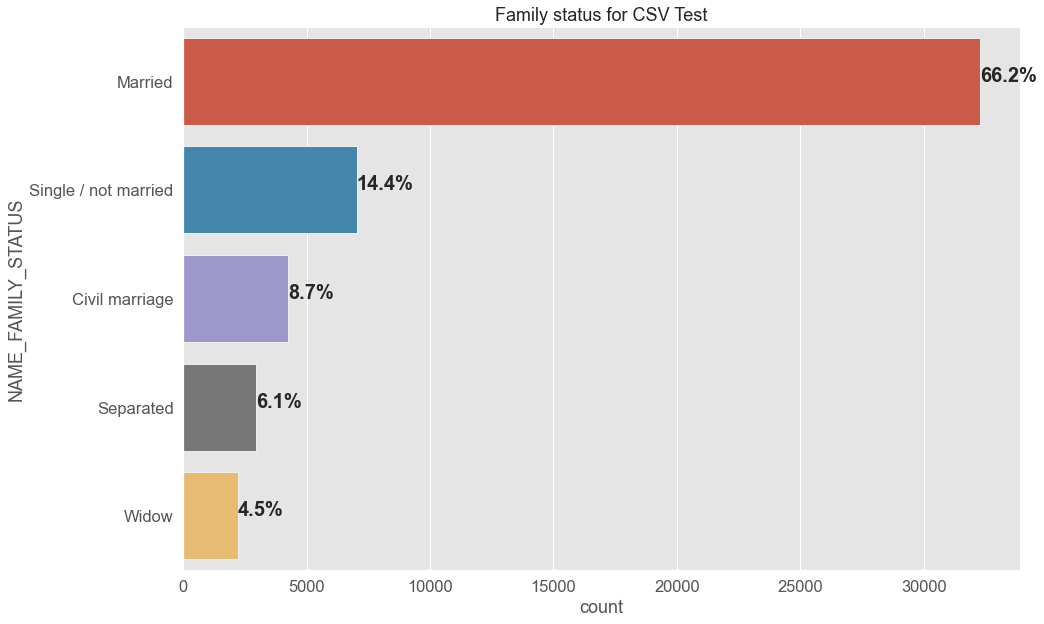

In [ ]:
plot_stat(app_test, 'NAME_FAMILY_STATUS', 'Family status for CSV Test', (15,10)) 

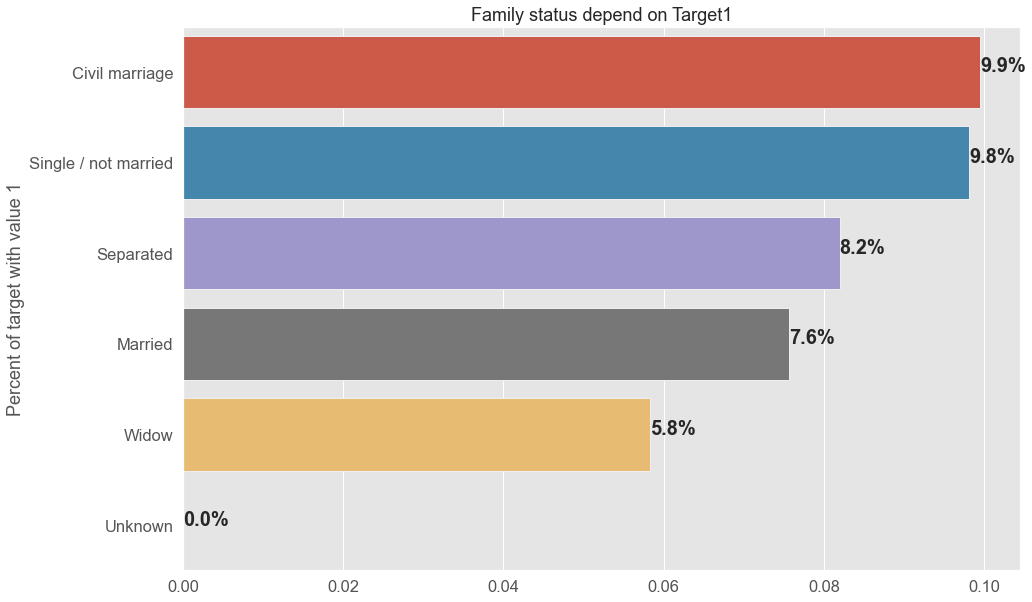

In [ ]:
plot_percent_target1(app_train, 'NAME_FAMILY_STATUS',"Family status depend on Target1", (15,10))

Le mariage civil a le pourcentage le plus élevé de non-remboursement

**Income type** - Distribution du type de revenus

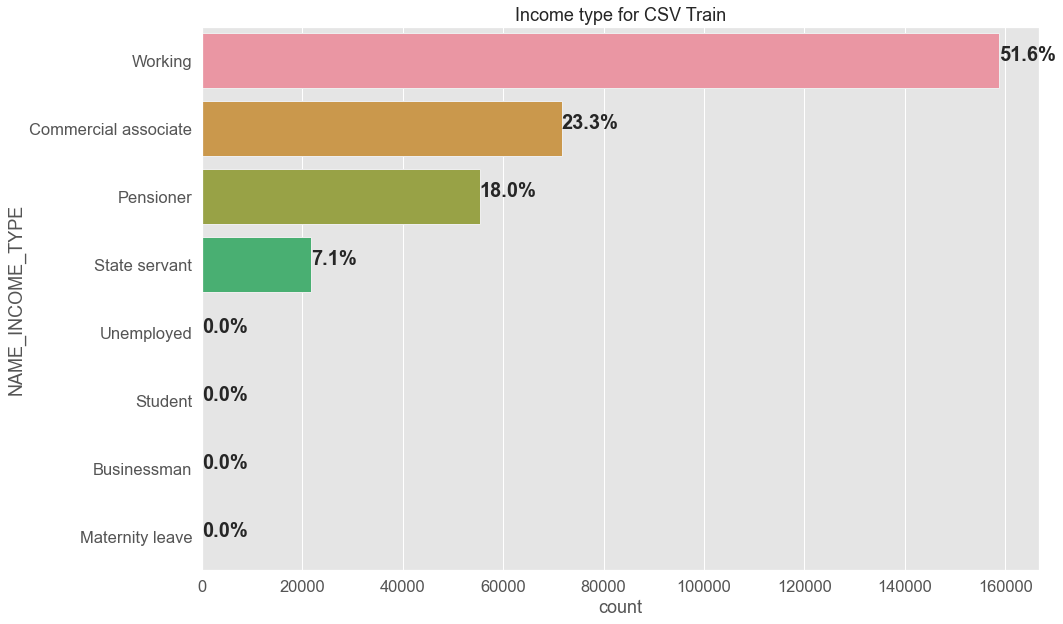

In [ ]:
plot_stat(app_train, 'NAME_INCOME_TYPE', 'Income type for CSV Train', (15,10)) 

La très grande majorité des clients a un emploi. La plupart des clients ont des revenus de type travail, d'associé commercial, de retraite.

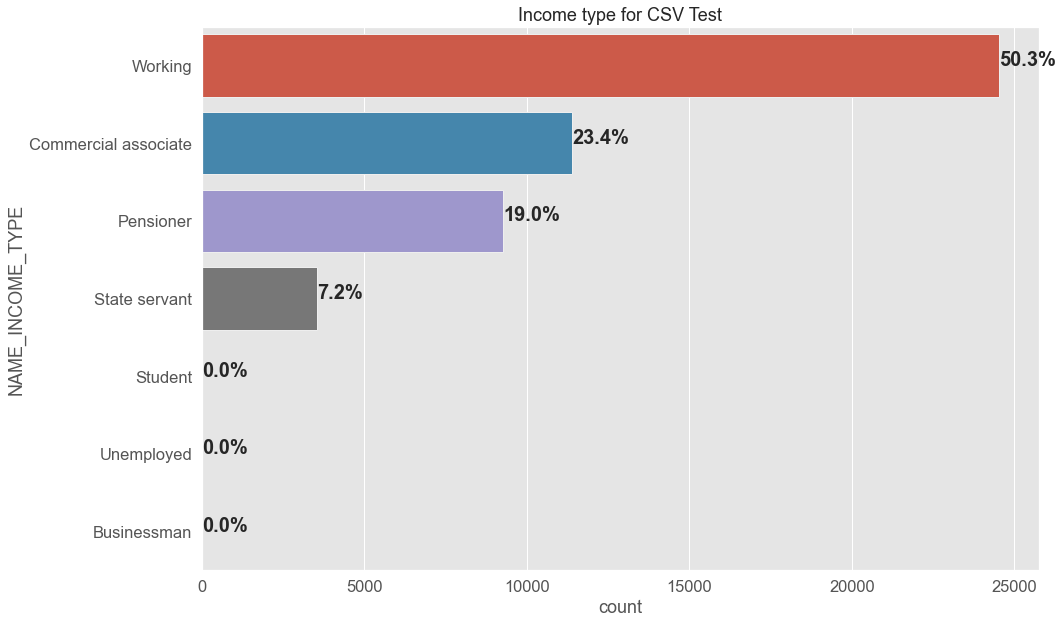

In [ ]:
plot_stat(app_test, 'NAME_INCOME_TYPE', 'Income type for CSV Test', (15,10)) 

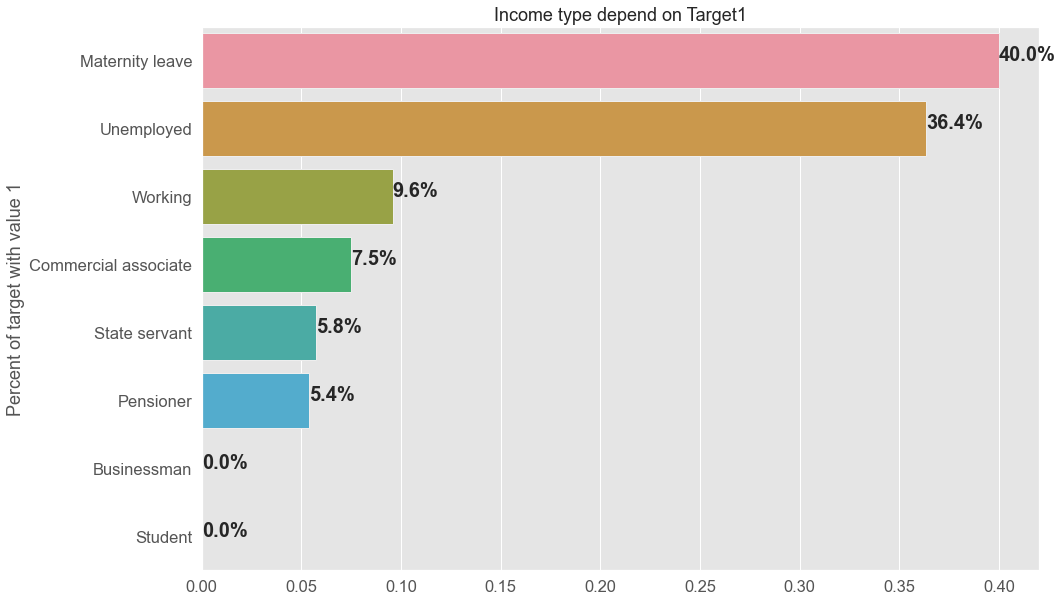

In [ ]:
plot_percent_target1(app_train, 'NAME_INCOME_TYPE',"Income type depend on Target1", (15,10))

Les prêts sont non remboursés avec les clients qui ont des revenus de congé maternité et de chômage.

**Type de travail** - Distribution du type de travail des clients

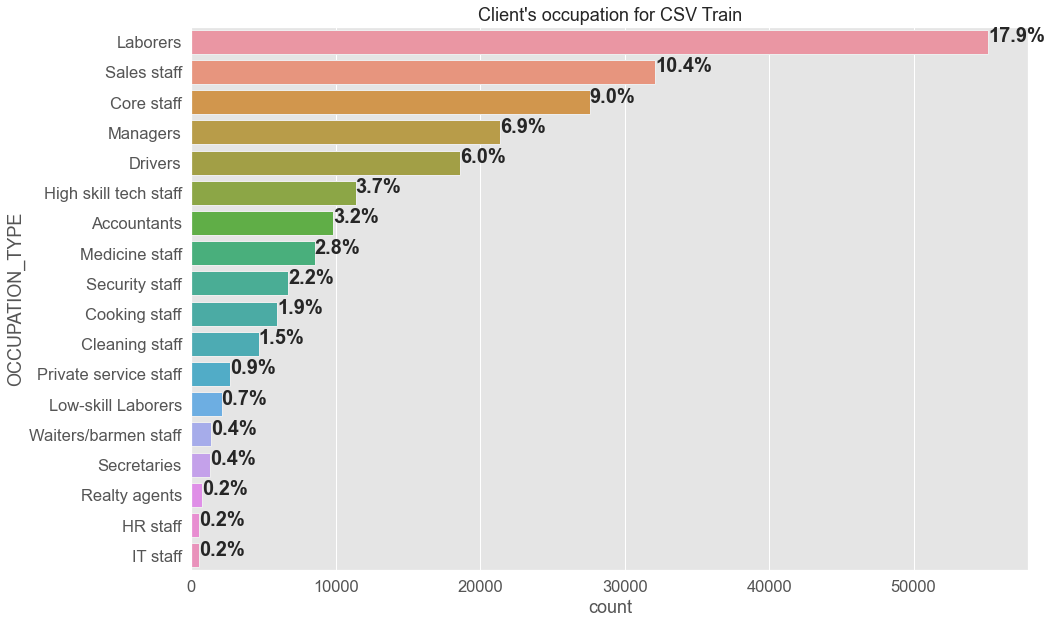

In [ ]:
plot_stat(app_train, 'OCCUPATION_TYPE', 'Client\'s occupation for CSV Train', (15,10)) 

La plupart des clients sont des ouvriers.

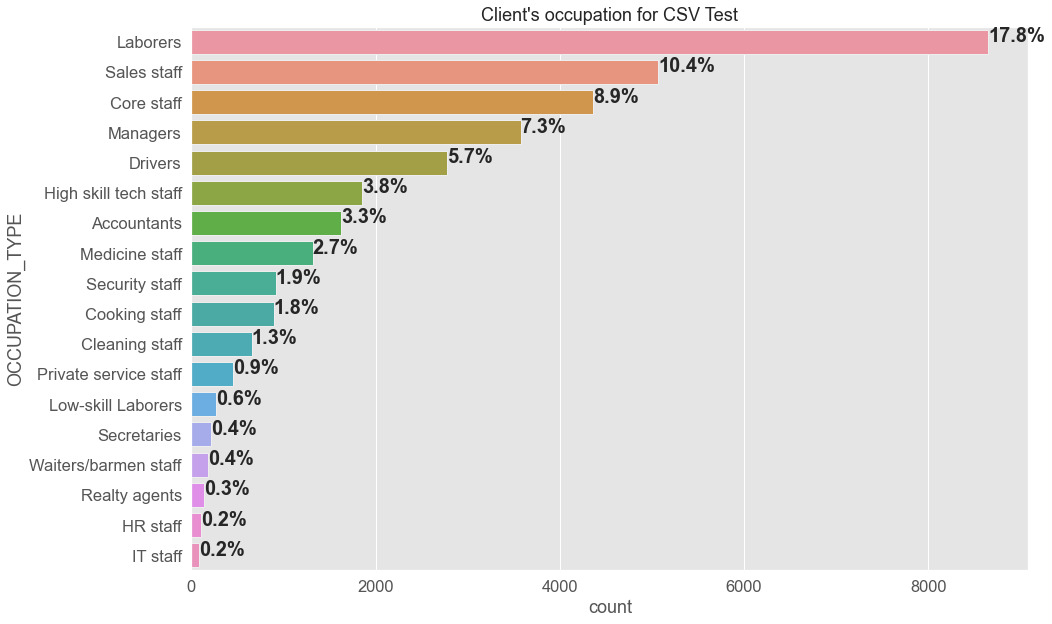

In [ ]:
plot_stat(app_test, 'OCCUPATION_TYPE', 'Client\'s occupation for CSV Test', (15,10)) 

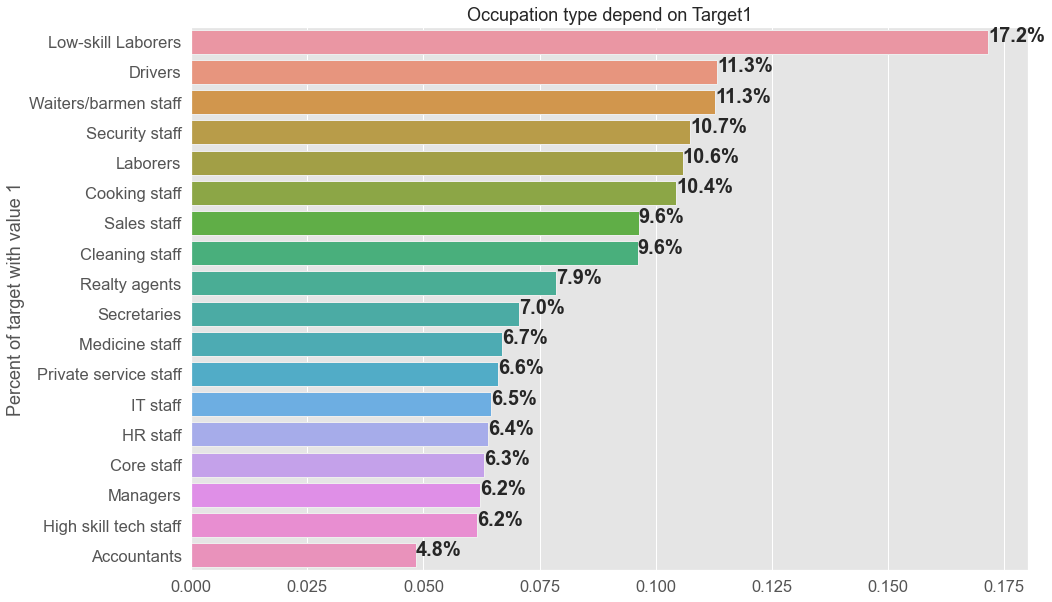

In [ ]:
plot_percent_target1(app_train, 'OCCUPATION_TYPE',"Occupation type depend on Target1", (15,10))

Les prêts sont non remboursés avec les clients qui sont des ouviers peu qualifiés.

**Type d'éducation** - Distribution du type d'éducation des clients

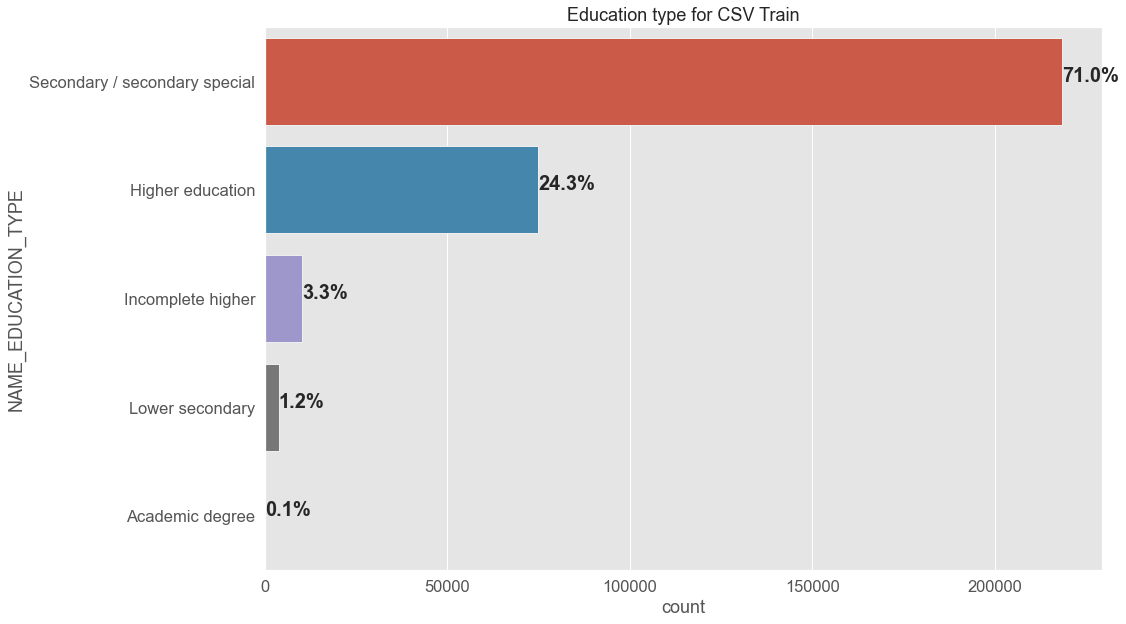

In [ ]:
plot_stat(app_train, 'NAME_EDUCATION_TYPE', 'Education type for CSV Train', (15,10)) 

La majorité des clients ont une éducation de niveau secondaire et supérieure.

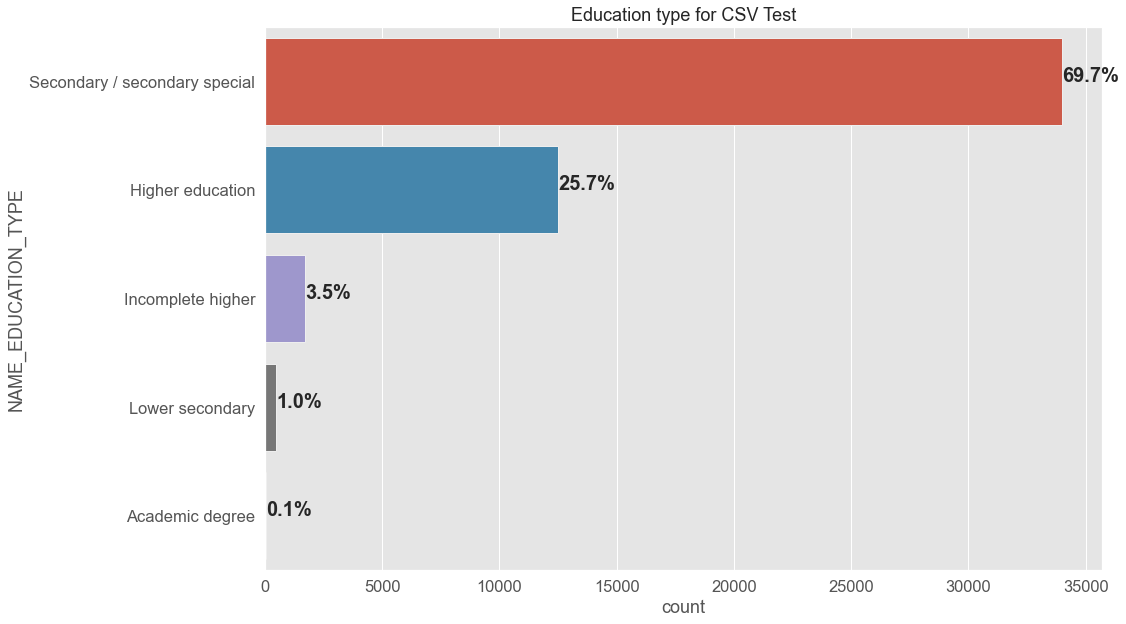

In [ ]:
plot_stat(app_test, 'NAME_EDUCATION_TYPE', 'Education type for CSV Test', (15,10)) 

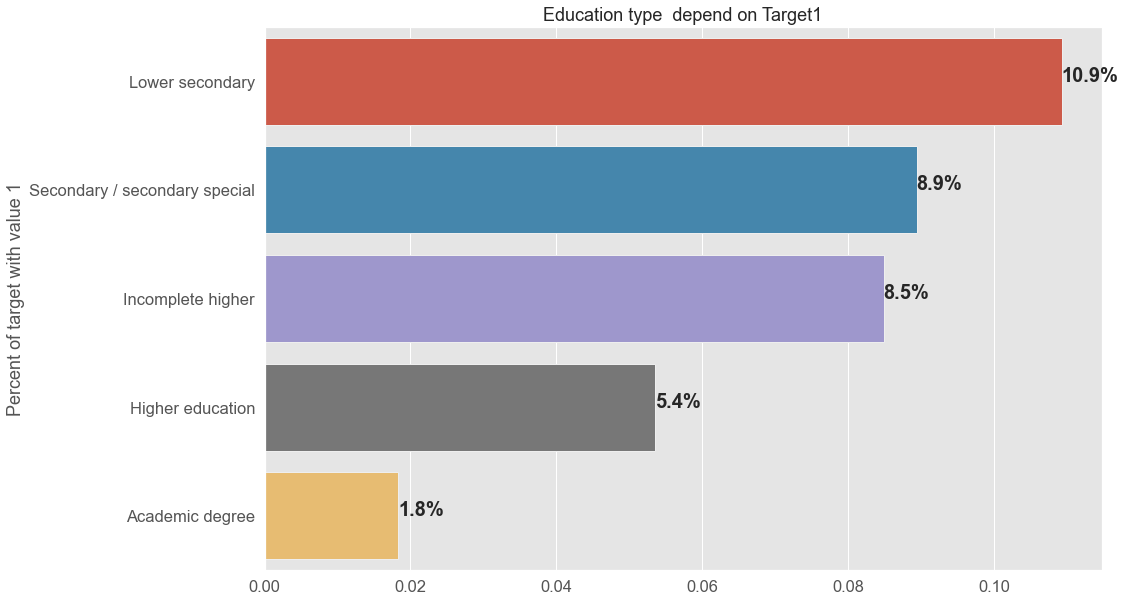

In [ ]:
plot_percent_target1(app_train, 'NAME_EDUCATION_TYPE',"Education type  depend on Target1", (15,10))

Les clients ayant un niveau d'éducation de début de secondaire risquent de moins rembourser les prêts que les clients ayant une éducation universitaire.

**Type de logement** - Distribution du type de logement des clients

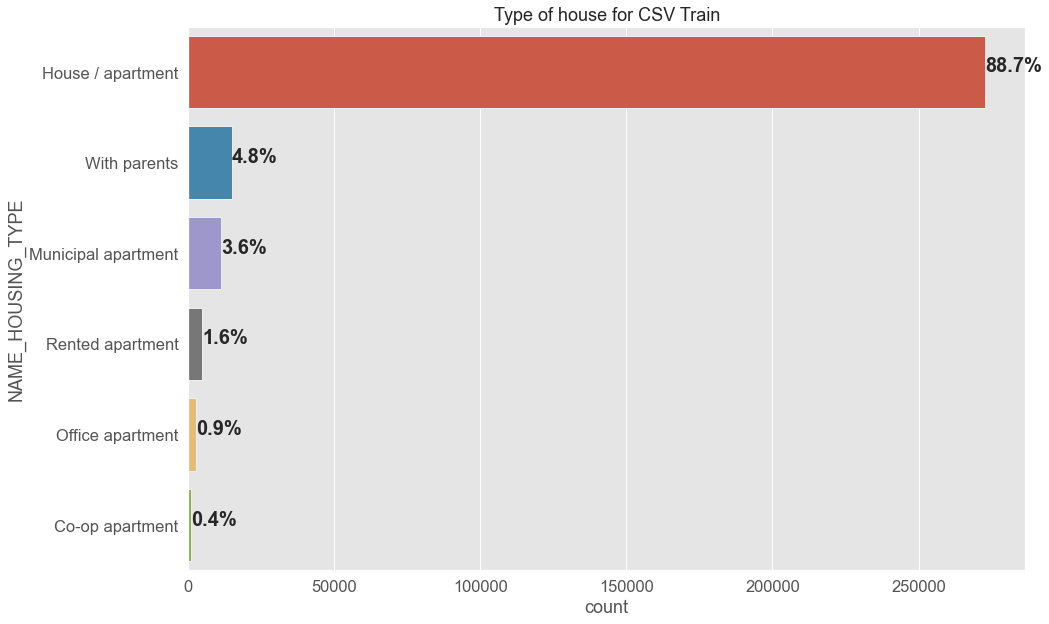

In [ ]:
plot_stat(app_train, 'NAME_HOUSING_TYPE', 'Type of house for CSV Train', (15,10)) 

La majorité des clients vivent en maison ou en appartement.

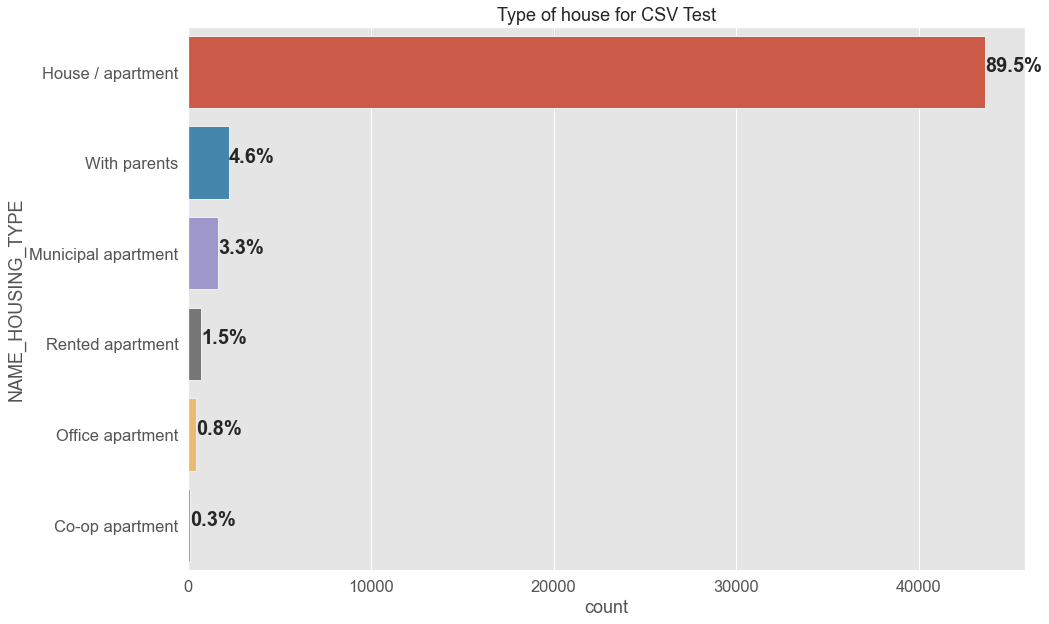

In [ ]:
plot_stat(app_test, 'NAME_HOUSING_TYPE', 'Type of house for CSV Test', (15,10)) 

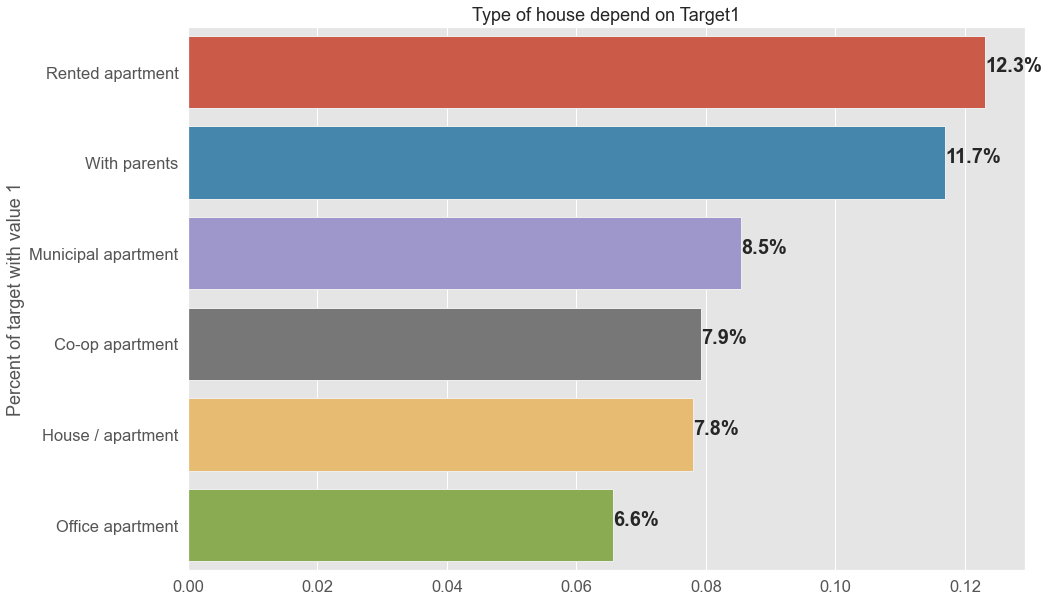

In [ ]:
plot_percent_target1(app_train, 'NAME_HOUSING_TYPE',"Type of house depend on Target1", (15,10))

Les clients qui payent un loyer ou qui vivent chez leurs parents ont plus de mal à rembourser un prêt.

**Montant crédit moyen :**

In [ ]:
target_0 =app_train.loc[app_train['TARGET'] == 0]
target_0['AMT_CREDIT'].mean()

602648.2820019386

Le montant moyen des crédit est de 602 k€ pour les personnes sachant rembourser le prêt.

In [ ]:
target_1 =app_train.loc[app_train['TARGET'] == 1]
target_1['AMT_CREDIT'].mean()

557778.527673716

Le montant moyen des crédit est de 557 k€ pour les personnes ne sachant pas rembourser leurs prêts.

# <font color='green'>Corélation avec la TARGET</font>

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles au sein des données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

0,00-0,19 "très faible"
0,20 à 0,39 "faible".
0,40-0,59 "modéré
0,60-0,79 "fort
0,80-1,0 "très forte".

Voyons les relations possibles entre les variables et le TARGET en calculant le coefficiant de Pearson.

In [ ]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
AGE                          -0.078263
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


TARGET a la plus forte corrélation positive avec 'DAYS_BIRTH'.

In [ ]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

Au fur et à mesure que le client vieillit, il existe une relation linéaire négative avec l'objectif, ce qui signifie que plus les clients vieillissent, plus ils ont tendance à rembourser leurs prêts dans les délais.

On trouve une corrélation négative, entre la taget et l'âge des clients. Plus le client est âgé moins la probabilité de défaut de paiement est haute.

**Effet de l'âge sur la TARGET**

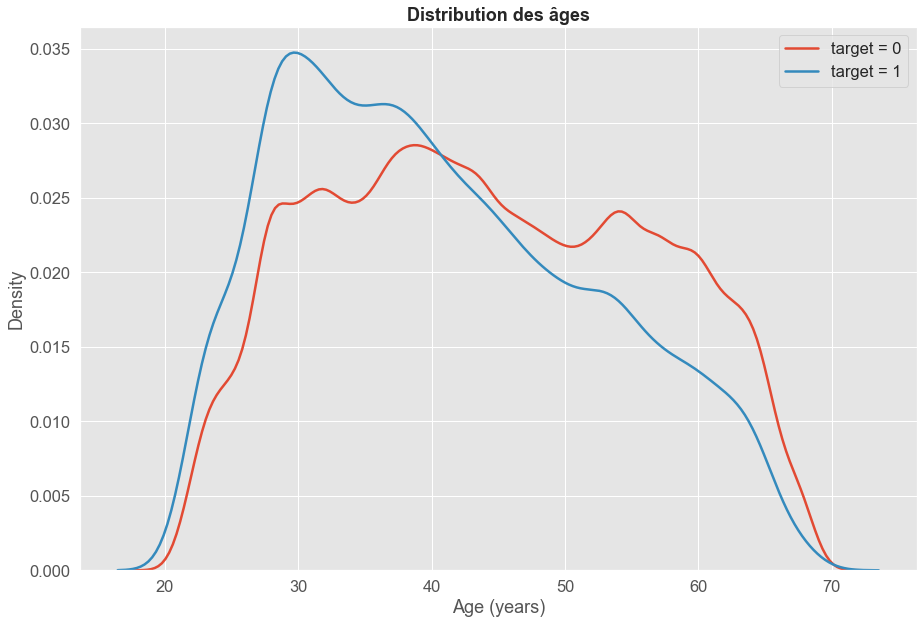

In [ ]:
plt.figure(figsize = (15, 10))

# KDE plot ages when there is no default
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target = 0')
             
             
# KDE plot ages when there is default
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target = 1')

plt.xlabel('Age (years)'); plt.ylabel('Density')
plt.title('Distribution des âges', weight='bold', size=18)
plt.legend()

La courbe de la TARGET == 1 penche vers l'extrémité la plus jeune de la fourchette, ce qui signifierai que les personnes jeunes ont plus de mal à rembourser.  Cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. 

**ratio de prêts non remboursés dans chaque tranche d'âge (par 5 ans)**

In [ ]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365


# Découpage par tranche d'âge.
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# On regroupe par tranche crée
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

Pour chaque tranche d'âge de 5 ans, nous avons la moyenne de TARGET (c'est à dire la moyenne de 1 (défaut de paiement) recensée pour chaque tranche d'âge), l'année moyenne de naissance par goupe.

Nous découpons d'abord la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque bac, nous calculons la valeur moyenne de la cible, ce qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

échec moyen du remboursement des prêts par tranche d'âge.

Text(0.5, 1.0, 'Default by age group')

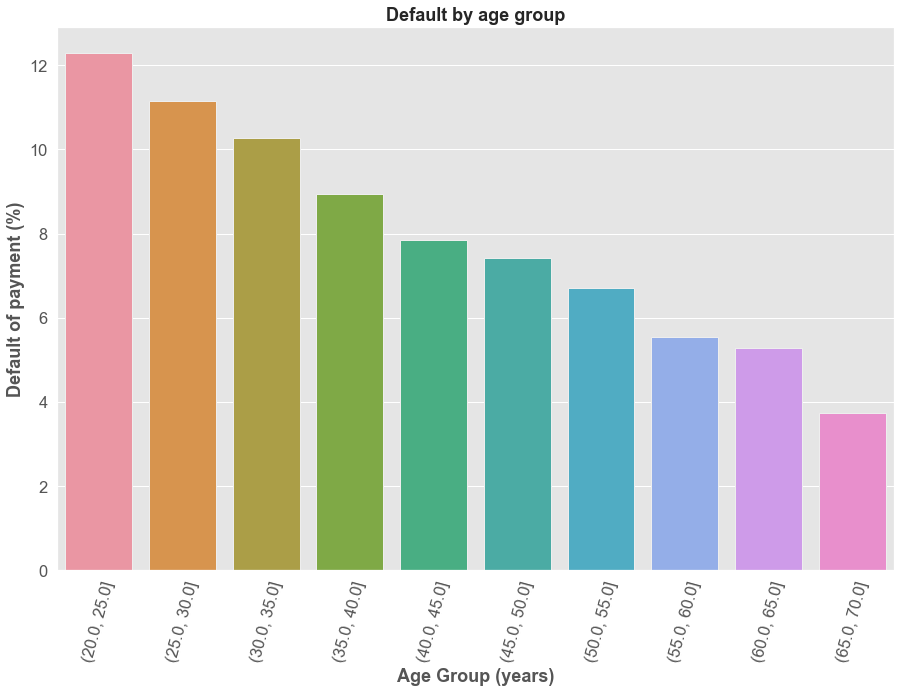

In [ ]:
plt.figure(figsize=(15, 10))

# Graph the age bins and the average of the target as a bar plot
sns.barplot(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75) 
plt.xlabel('Age Group (years)', weight='bold') 
plt.ylabel('Default of payment (%)', weight='bold')
plt.title("Default by age group",
          weight='bold', size=18)

Les clients les plus jeunes sont plus susceptibles à ne pas rembourser le prêt. 

**Sources extérieures, les plus fortes corrélations linéaires négatives …**

Ces 3 variables (EXT_SOURCE) présentant les corrélations négatives les plus fortes avec la Target. Selon la documentation, ces fonctionnalités représentent un «score normalisé à partir d'une source de données externes». Difficile de comprendre le sens exact, nous pouvons émettre l'hypothèse d'une côte de crédit cumulative établie à l'aide de différentes sources de données.

In [ ]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

Text(0.5, 1.0, 'Correlation Heatmap')

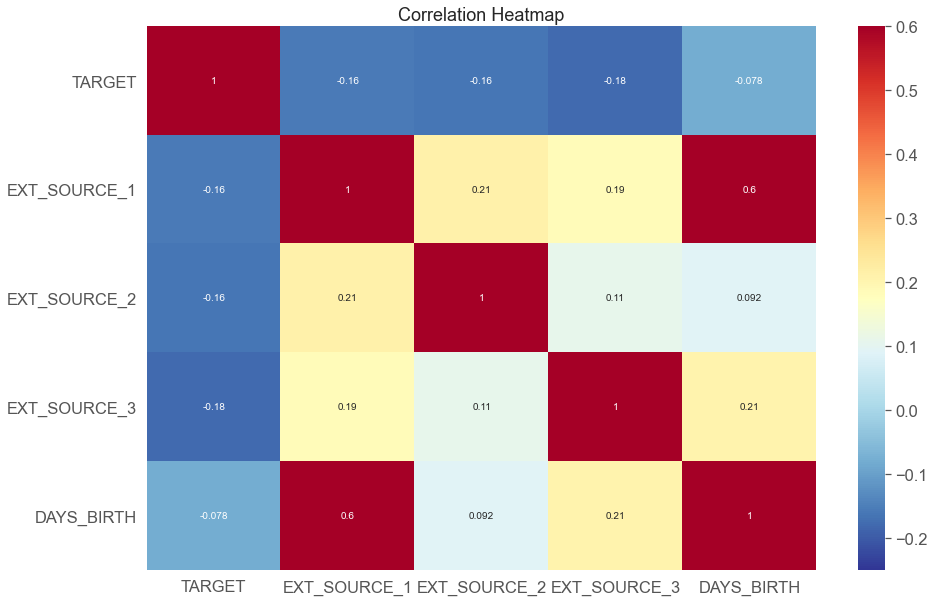

In [ ]:
plt.figure(figsize = (15, 10))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec les EXT_SOURCE, ce qui indique que l'un des facteurs de ces scores est peut-être l'âge du client.

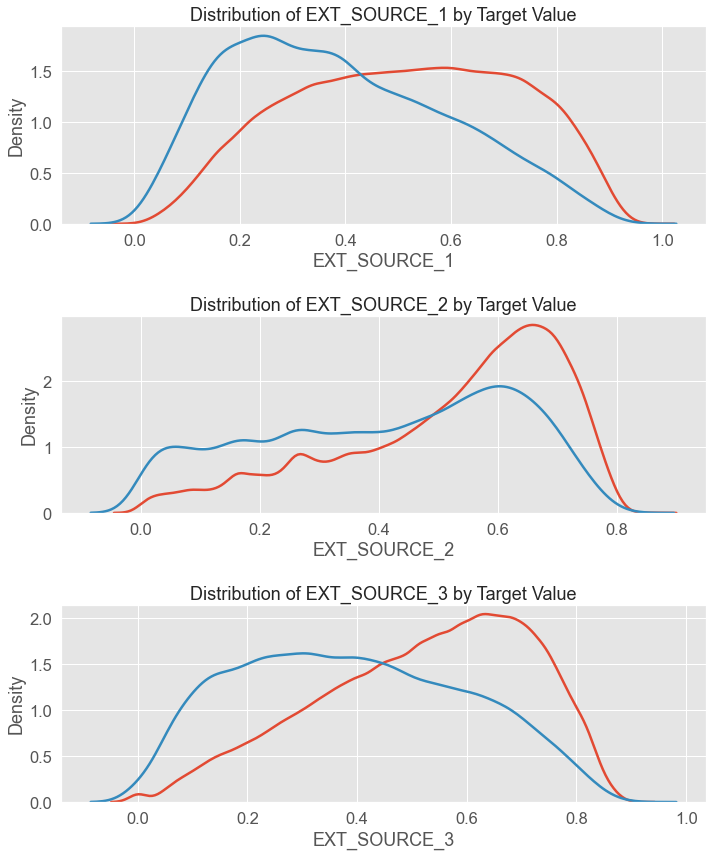

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles), mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique permettant de prédire si un demandeur remboursera ou non un prêt à temps.

In [ ]:
#Plot distribution of one feature
def plot_distribution(dataframe, feature, title, size):
    plt.figure(figsize=size)

    t0 = dataframe.loc[dataframe['TARGET'] == 0]
    t1 = dataframe.loc[dataframe['TARGET'] == 1]

    
    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()
    plt.show()

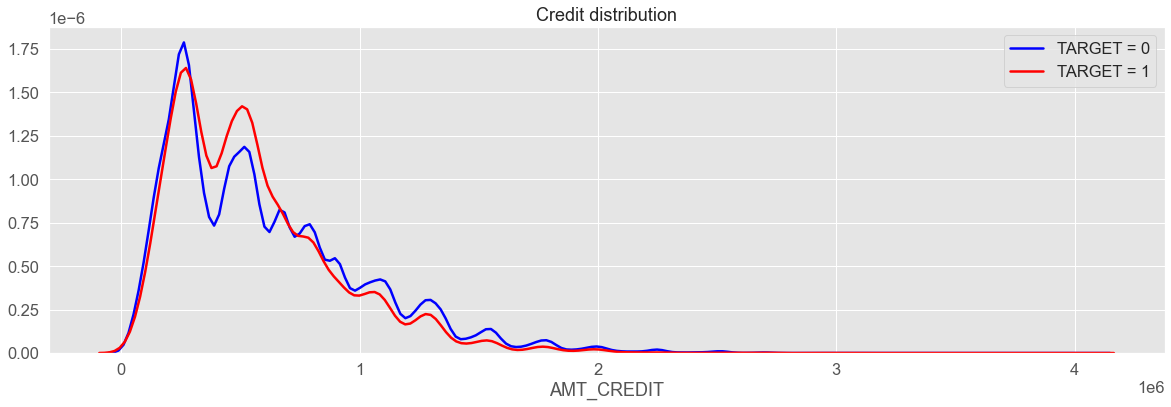

                                   -------------------------------------------------------


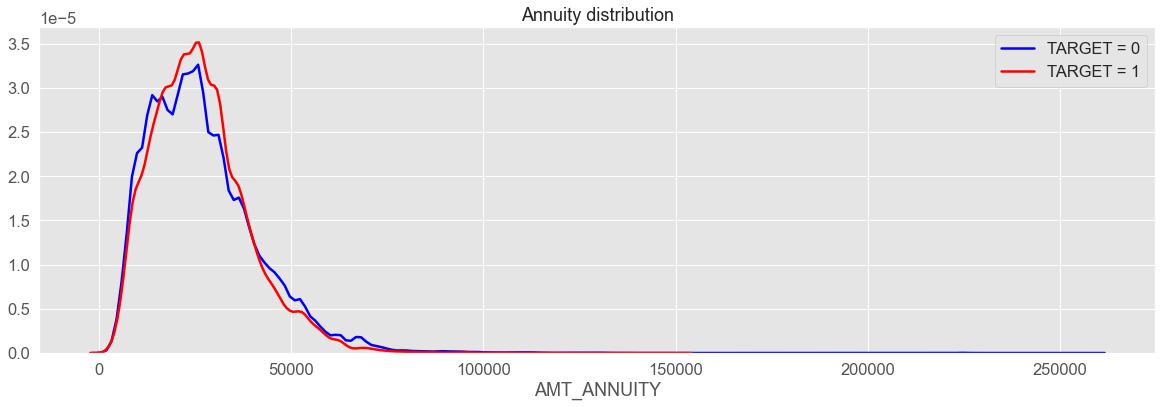

                                   -------------------------------------------------------


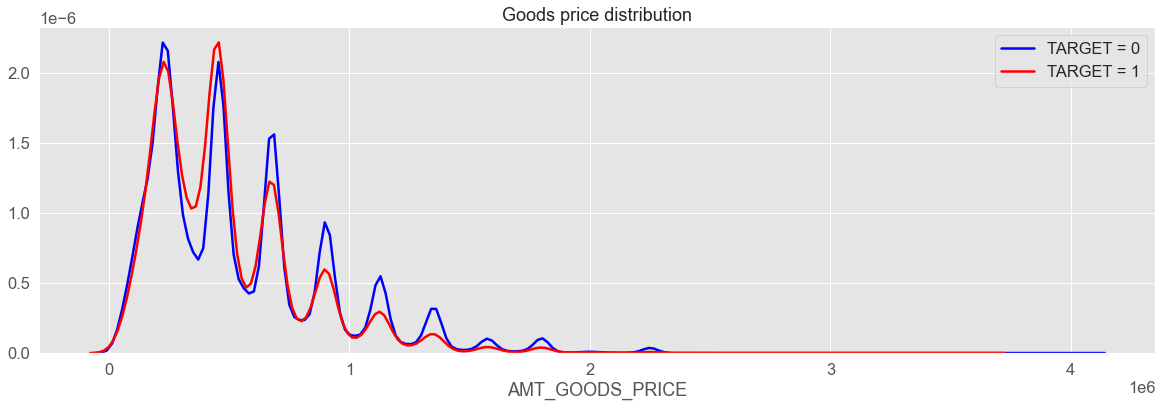

                                   -------------------------------------------------------


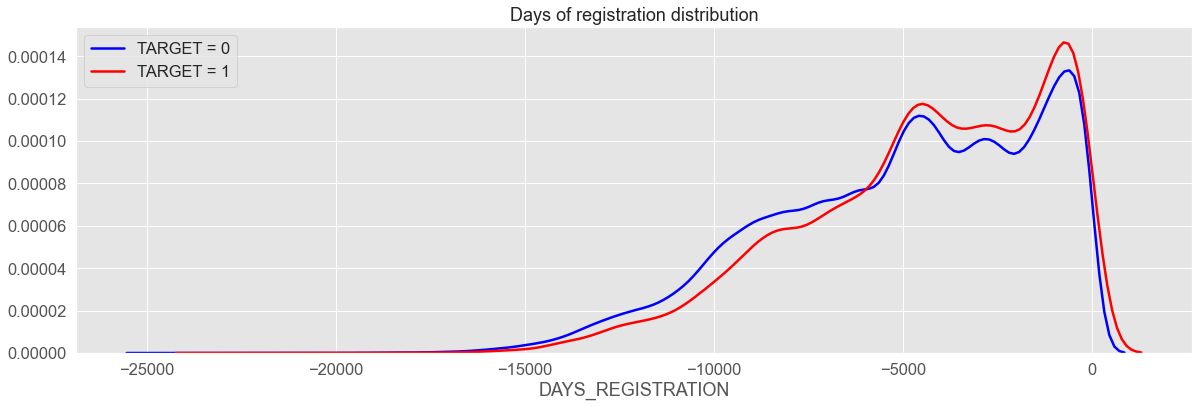

In [ ]:
plot_distribution(app_train, 'AMT_CREDIT', "Credit distribution", (20,6))
print("                                   -------------------------------------------------------")
plot_distribution(app_train,'AMT_ANNUITY', "Annuity distribution", (20,6))
print("                                   -------------------------------------------------------")
plot_distribution(app_train,'AMT_GOODS_PRICE', "Goods price distribution", (20,6))
print("                                   -------------------------------------------------------")
plot_distribution(app_train,'DAYS_REGISTRATION', "Days of registration distribution", (20,6))


# <font color='green'>EDA : bureau.csv</font>

Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt dans notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande. SK_ID_CURR est la clé reliant les données application_train | test aux données du bureau.

Il est nécessaire de fusionner "application_train" avec "bureau" pour pouvoir collecter des informations justifiant la TARGET == 1 pour chaque client.






In [ ]:
app_train.shape

(307511, 124)

In [ ]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

Nous retrouvons ici la notation XNA qui doit être remplacée par NaN (erreur de représentation NaN).

In [ ]:
bureau = bureau.replace('XNA', np.nan)

In [ ]:
application_bureau_train = app_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
application_bureau_train.shape

(1465325, 140)

**Credi_active** - Distribution du statut des crédits

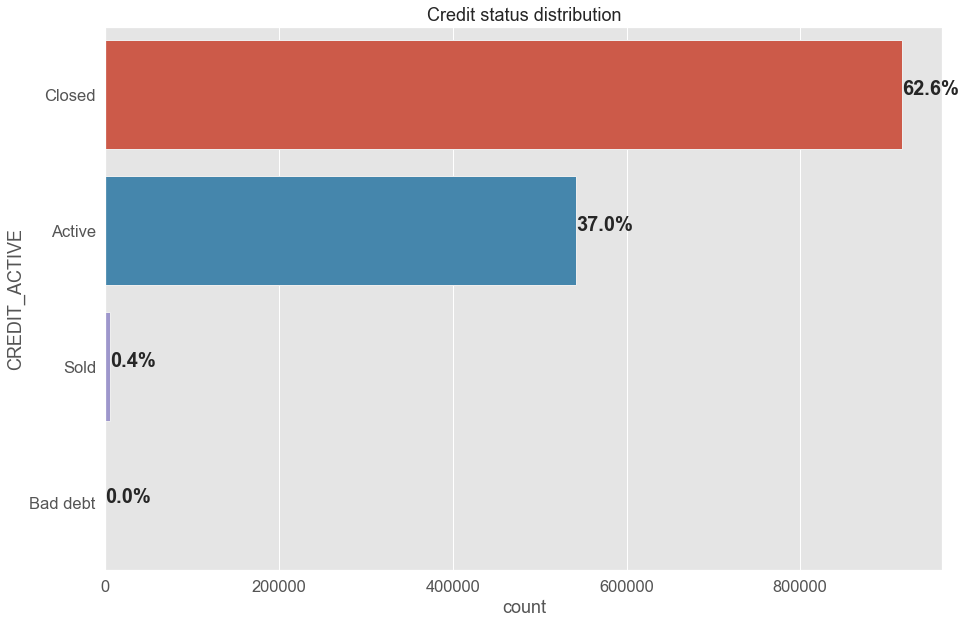

                                   -------------------------------------------------------


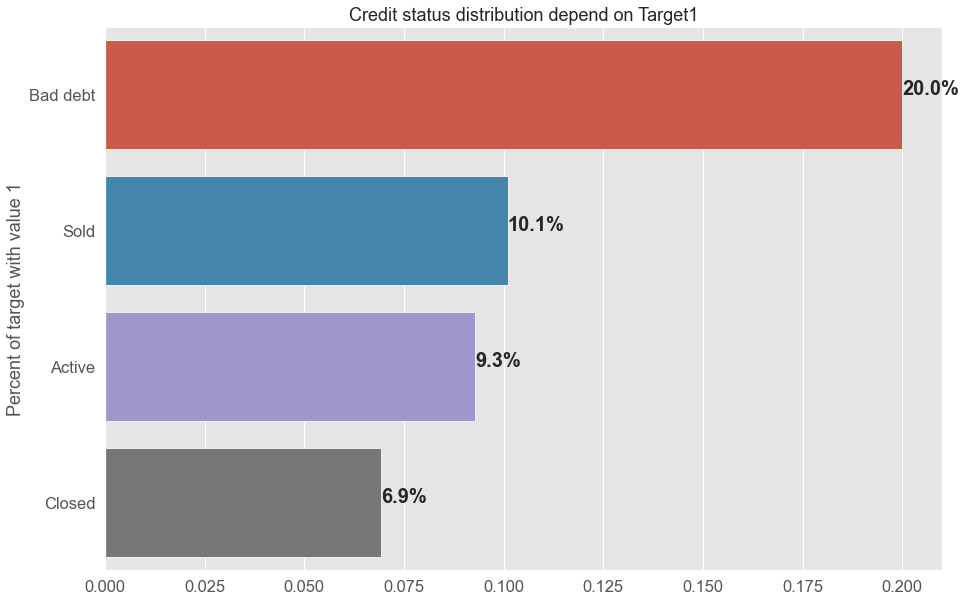

In [ ]:
#CREDIT_ACTIVE
plot_stat(application_bureau_train, 'CREDIT_ACTIVE',"Credit status distribution", (15,10))
print("                                   -------------------------------------------------------")
plot_percent_target1(application_bureau_train, 'CREDIT_ACTIVE',"Credit status distribution depend on Target1", (15,10))

**credit currency** - Distribution devise du crédit

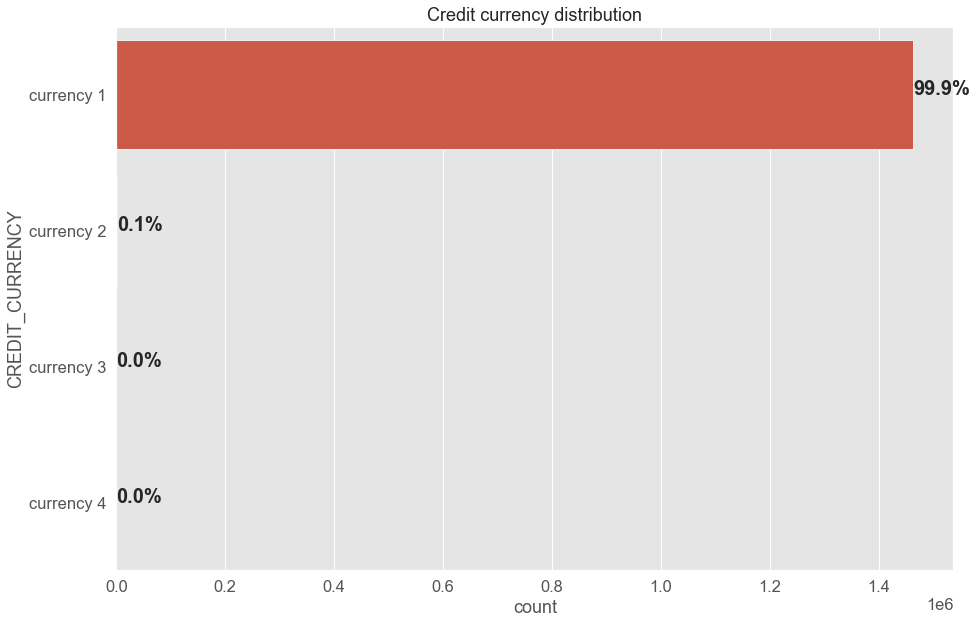

                                   -------------------------------------------------------


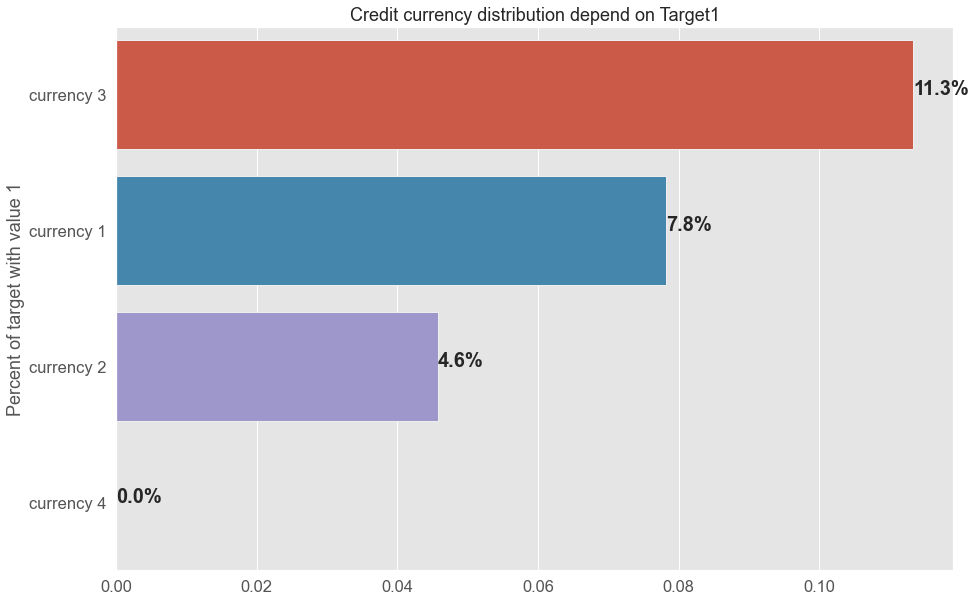

In [ ]:
#CREDIT_CURRENCY
plot_stat(application_bureau_train, 'CREDIT_CURRENCY',"Credit currency distribution", (15,10))
print("                                   -------------------------------------------------------")
plot_percent_target1(application_bureau_train, 'CREDIT_CURRENCY',"Credit currency distribution depend on Target1", (15,10))

**credit type** - Distribution du type de crédit

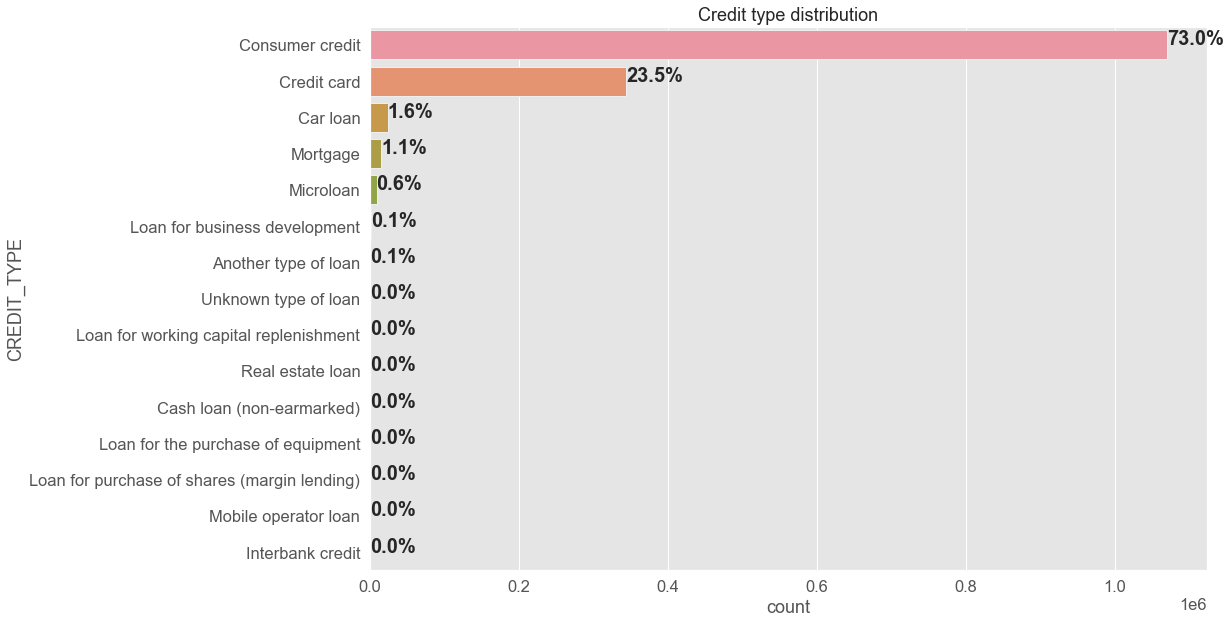

                                   -------------------------------------------------------


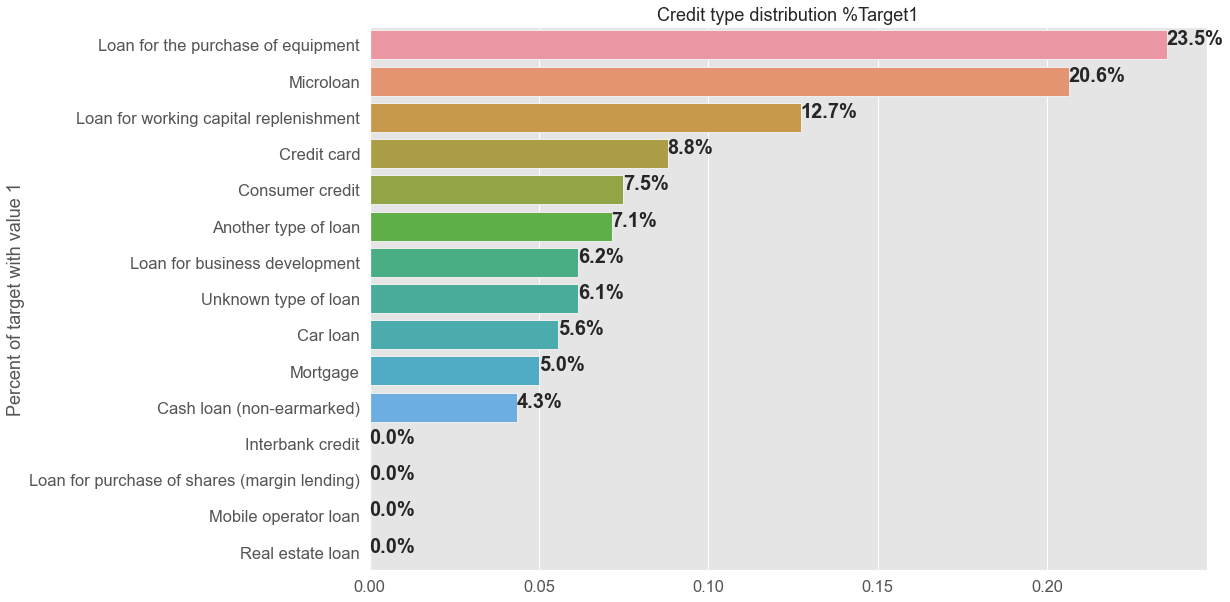

In [ ]:
#CREDIT_TYPE
plot_stat(application_bureau_train, 'CREDIT_TYPE',"Credit type distribution", (15,10))
print("                                   -------------------------------------------------------")
plot_percent_target1(application_bureau_train, 'CREDIT_TYPE',"Credit type distribution %Target1", (15,10))

# <font color='green'>EDA previous_application.csv </font>

"previous_application" contient des informations sur toutes les demandes précédentes de crédit immobilier des clients qui ont des prêts dans l'échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données. SK_ID_CURR est la clé reliant les données application_train | test aux données previous_application.

Il est nécessaire de fusionner "application_train" avec "previous_application" pour pouvoir collecter des informations justifiant la TARGET == 1 pour chaque client.

In [ ]:
app_train.shape

(307511, 124)

In [ ]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                     15.0                           Y   
1                     11.0                           Y   
2                     11.0                           Y   
3                      7.0                           Y   
4                      9.0                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                     1.0                0.0               0.182832   
1                     1.0                NaN                    NaN   
2                     1.0                NaN                    NaN   
3                     1.0                NaN                    NaN   
4                     1.0                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

Nous retrouvons ici la notation XNA qui doit être remplacée par NaN (erreur de représentation NaN).

In [ ]:
previous_application = previous_application.replace('XNA', np.nan)

In [ ]:
application_prev_train = app_train.merge(previous_application, 
                                                 left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
application_prev_train.shape

(1413701, 160)

**Name contract type** - Distribution du type des contrats

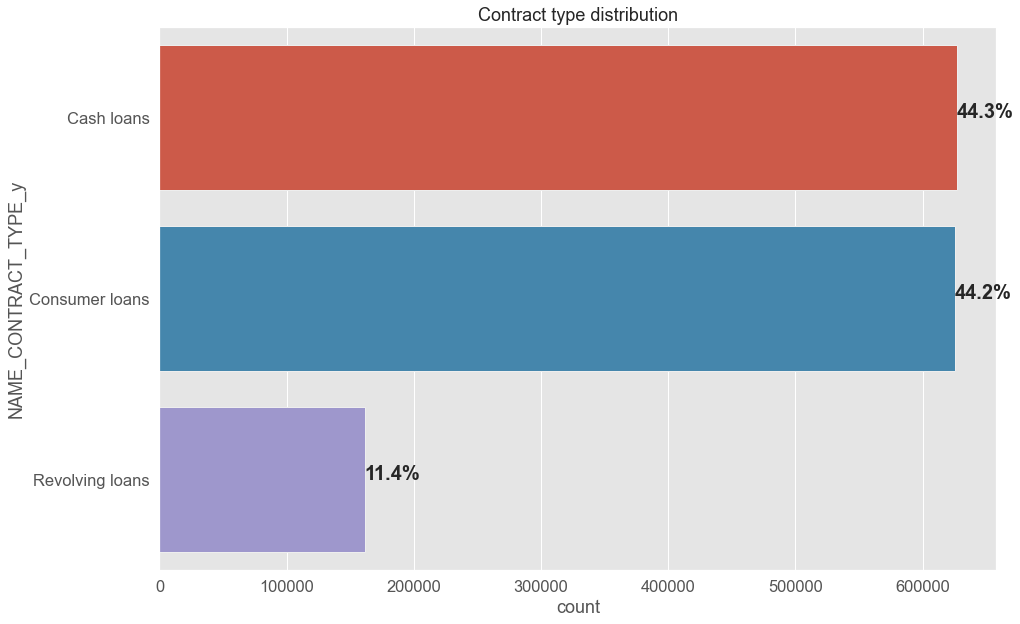

                                   -------------------------------------------------------


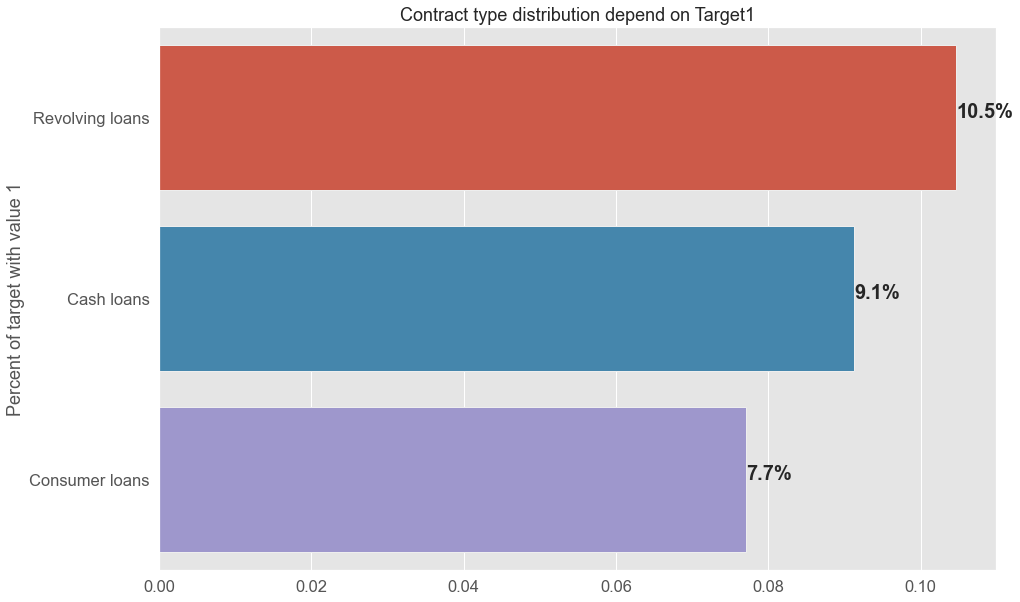

In [ ]:
#NAME_CONTRACT_TYPE_y
plot_stat(application_prev_train, 'NAME_CONTRACT_TYPE_y',"Contract type distribution", (15,10))
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CONTRACT_TYPE_y',"Contract type distribution depend on Target1", (15,10))

**Name contract status** - Distribution du status des contrats 

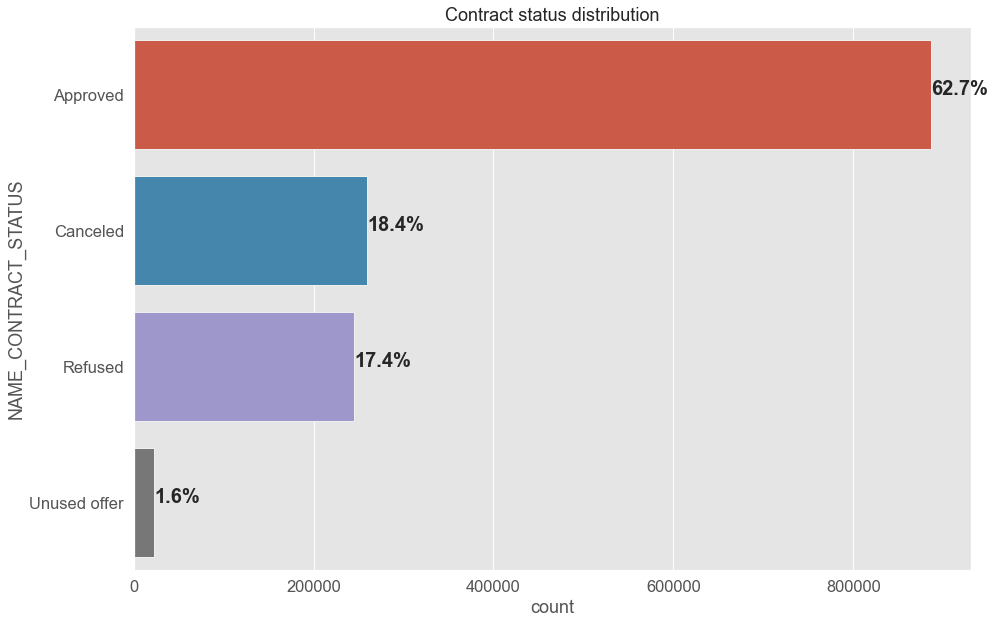

                                   -------------------------------------------------------


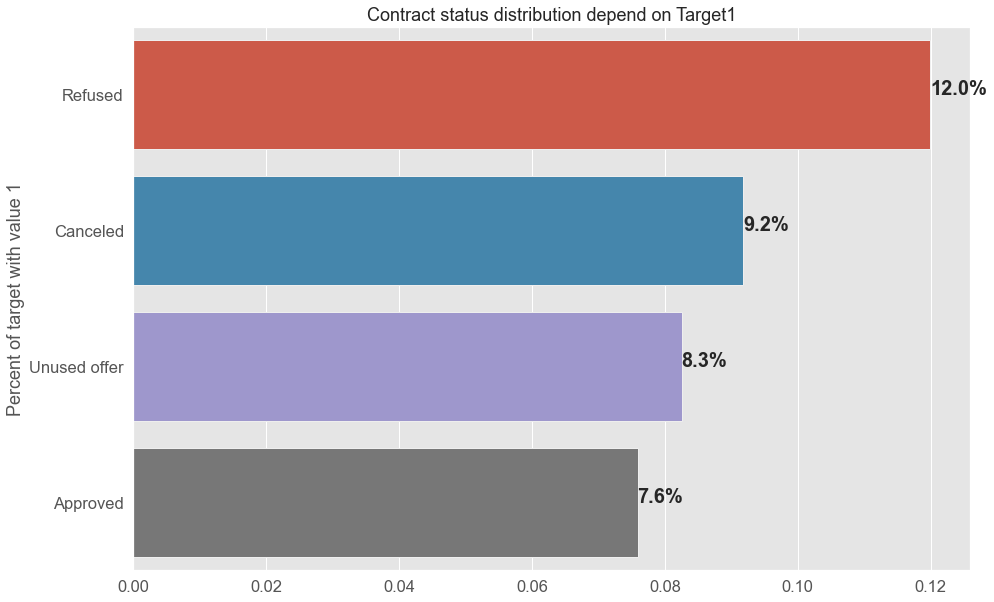

In [ ]:
#NAME_CONTRACT_STATUS
plot_stat(application_prev_train, 'NAME_CONTRACT_STATUS',"Contract status distribution", (15,10))
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CONTRACT_STATUS',"Contract status distribution depend on Target1", (15,10))

**Name payment type** - Distribution du mode de paiement que le client a choisi pour payer la demande précédente

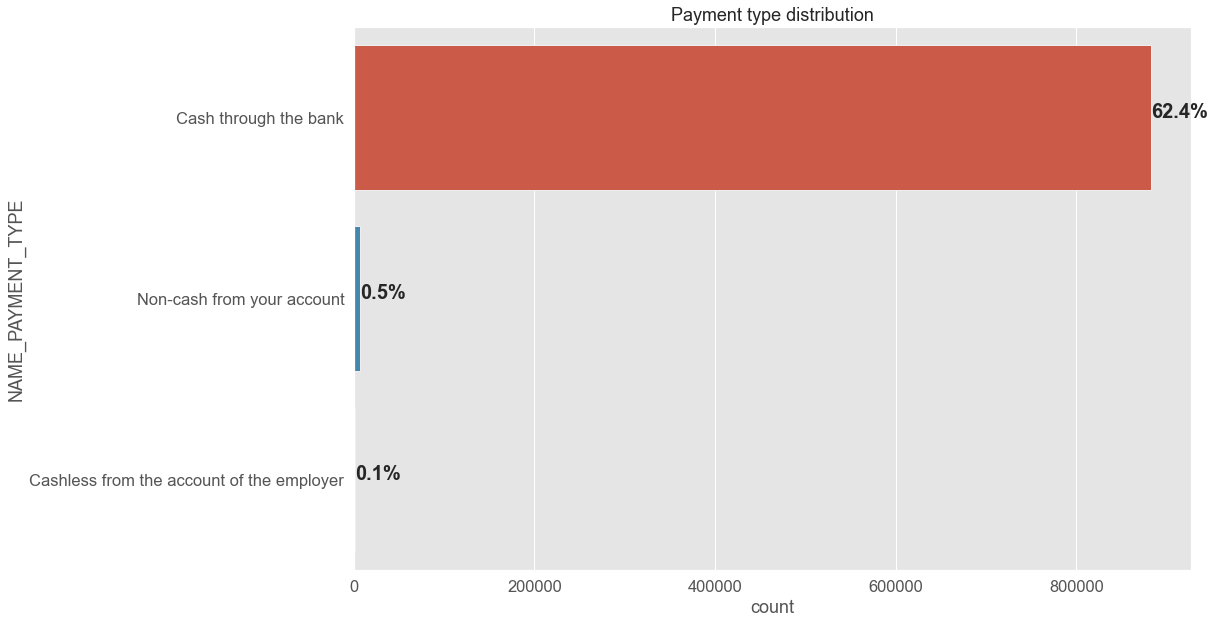

                                   -------------------------------------------------------


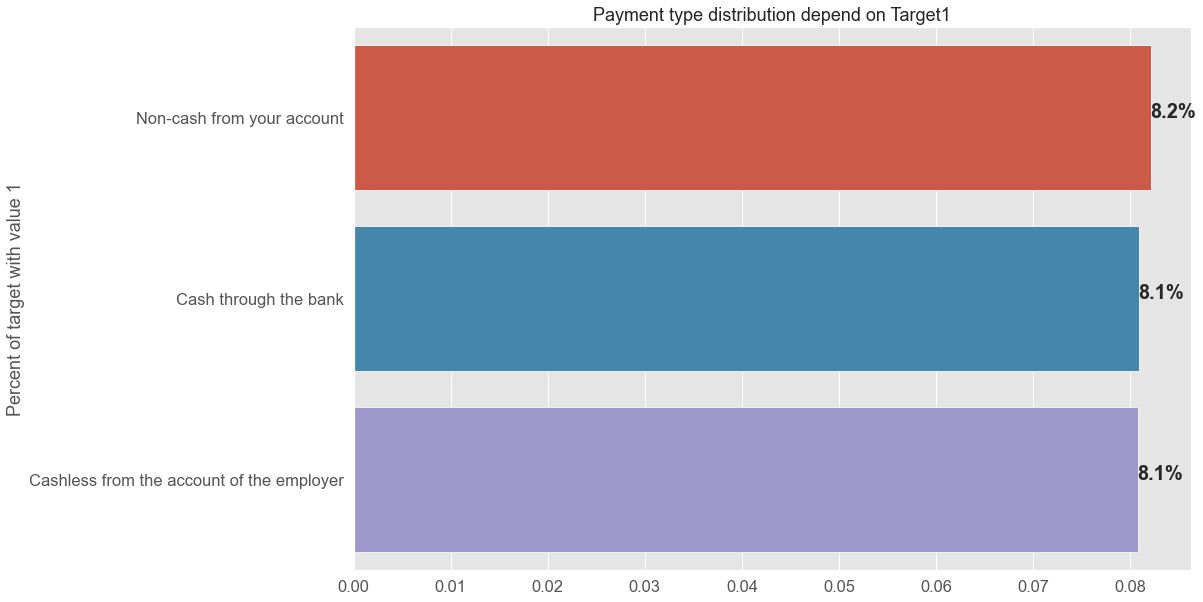

In [ ]:
#NAME_PAYMENT_TYPE
plot_stat(application_prev_train, 'NAME_PAYMENT_TYPE',"Payment type distribution", (15,10))
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_PAYMENT_TYPE',"Payment type distribution depend on Target1", (15,10))

Le mode de paiement se fait majoritairement en Cash via la banque.

Le défaut de remboursement ne se dintingue sur aucun type de paiement, l'égalité est quasi parfaite.

**Name client type** - Le client était-il un ancien ou un nouveau client lors de la demande précédente

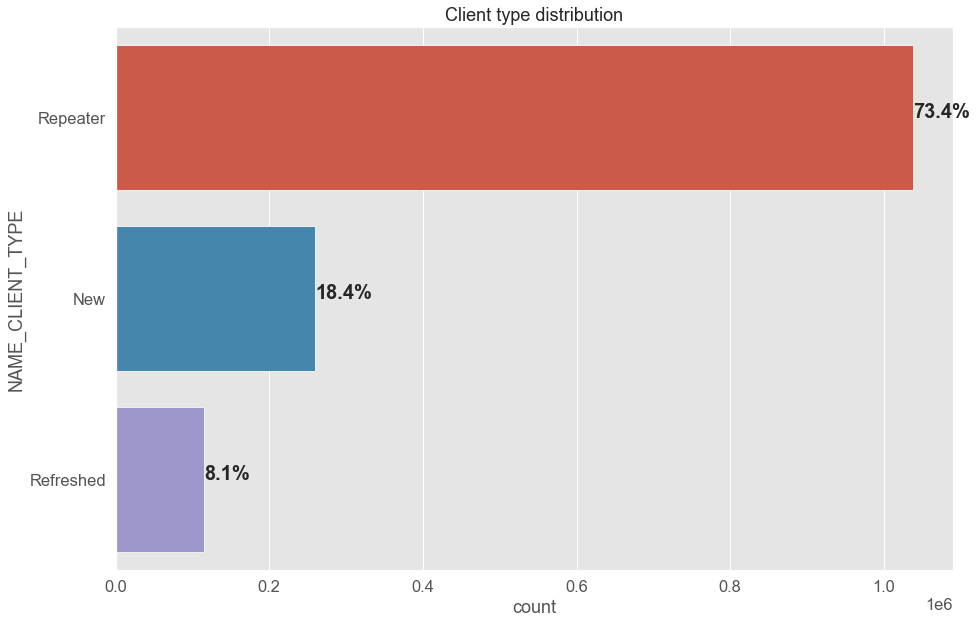

                                   -------------------------------------------------------


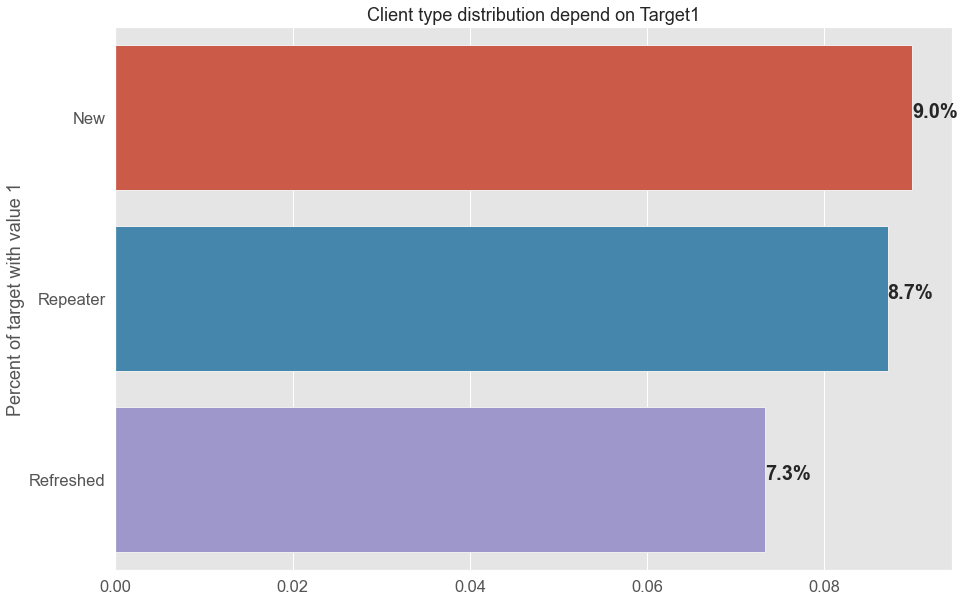

In [ ]:
#NAME_CLIENT_TYPE
plot_stat(application_prev_train, 'NAME_CLIENT_TYPE',"Client type distribution", (15,10))
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CLIENT_TYPE',"Client type distribution depend on Target1", (15,10))

Dans le jeu de données, les clients majoritaires sont ceux qui font régulièrement des demandes de prêts mais ce sont les nouveaux clients qui ont dû mal à rembourser leurs prêts.

# <font color='green'>Création de nouvelles colonnes </font>

In [ ]:
data = app_train.append(app_test)

In [ ]:
print('Train:' + str(app_train.shape))
print('Test:' + str(app_test.shape))
print('>>> Data:' + str(data.shape))

Train:(307511, 124)
Test:(48744, 123)
>>> Data:(356255, 124)


*bureau : bureau.csv*

In [ ]:
display(bureau.head())
display(bureau.shape)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

(1716428, 17)

Calcul du nombre total des précédents crédits pour chaque client.

PREVIOUS_APPLICATION_COUNT : Nombre de demandes antérieures des clients au crédit immobilier

In [ ]:
#Nombre total de demandes précédentes pris par chaque client.
previous_application_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()

SK_ID_CURR  PREVIOUS_APPLICATION_COUNT
0      100001                           7
1      100002                           8
2      100003                           4
3      100004                           2
4      100005                           3

In [ ]:
#Fusionner cette nouvelle colonne dans notre échantillon de données
data = data.merge(previous_application_counts, on='SK_ID_CURR', how='left')
data.shape

(356255, 125)

In [ ]:
most_credit_type = pd.DataFrame()
most_credit_type = bureau[['SK_ID_CURR',
                         'CREDIT_TYPE']].copy()
most_credit_type

SK_ID_CURR      CREDIT_TYPE
0            215354  Consumer credit
1            215354      Credit card
2            215354  Consumer credit
3            215354      Credit card
4            215354  Consumer credit
...             ...              ...
1716423      259355        Microloan
1716424      100044  Consumer credit
1716425      100044  Consumer credit
1716426      246829  Consumer credit
1716427      246829        Microloan

[1716428 rows x 2 columns]

In [ ]:
def mode_perso(serie_values):
    #En entrée une serie en sortie une valeur de l'agregation de cette série
    count = serie_values.value_counts()
    return count.idxmax()

most_credit_type_mode = most_credit_type.groupby(by="SK_ID_CURR").agg(mode_perso)
most_credit_type_mode

CREDIT_TYPE
SK_ID_CURR                 
100001      Consumer credit
100002      Consumer credit
100003          Credit card
100004      Consumer credit
100005      Consumer credit
...                     ...
456249      Consumer credit
456250      Consumer credit
456253      Consumer credit
456254      Consumer credit
456255      Consumer credit

[305811 rows x 1 columns]

In [ ]:
most_credit_type_mode = most_credit_type_mode.reset_index()
most_credit_type_mode.rename(columns={
    'CREDIT_TYPE': 'MOST_CREDIT_TYPE'}, inplace=True)

left_df = data
right_df = most_credit_type_mode
data = pd.merge(left_df, right_df, on='SK_ID_CURR', how='left')
data.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002     1.0         Cash loans           M            N   
1      100003     0.0         Cash loans           F            N   
2      100004     0.0    Revolving loans           M            Y   
3      100006     0.0         Cash loans           F            N   
4      100007     0.0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461         -637.0            -3648.0   
1                    0.003541       16765        -1188.0            -1186.0   
2                    0.010032       19046         -225.0            -4260.0   
3                    0.008019       19005        -3039.0            -9833.0   
4                    0.028663       19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

*previous_application* : Toutes les demandes précédentes de prêts pour le **crédit immobilier** des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.

In [ ]:
display(previous_application.head())
display(previous_application.shape)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                     15.0                           Y   
1                     11.0                           Y   
2                     11.0                           Y   
3                      7.0                           Y   
4                      9.0                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                     1.0                0.0               0.182832   
1                     1.0                NaN                    NaN   
2                     1.0                NaN                    NaN   
3                     1.0                NaN                    NaN   
4                     1.0                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    NaN             Approved   
2                       NaN                    NaN             Approved   
3                       NaN                    NaN             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    NaN                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               NaN   
1         Repeater                 NaN           Cash            x-sell   
2         Repeater                 NaN           Cash            x-sell   
3         Repeater                 NaN           Cash            x-sell   
4         Repeater                 NaN           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  NaN   
2  Credit and cash offices                -1                  NaN   
3  Credit and cash offices                -1                  NaN   
4  Credit and cash offices                -1                  NaN   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

(1670214, 37)

PREVIOUS_LOANS_COUNT from previous_application.csv: Nombre total des précédents crédits pris par chaque client

In [ ]:
#Number of previous applications of the clients to Home Credit
previous_loan_counts = previous_application.groupby('SK_ID_CURR', 
                                                           as_index=False)['SK_ID_PREV'].count().rename(
                                                           columns = {'SK_ID_PREV': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

SK_ID_CURR  PREVIOUS_LOANS_COUNT
0      100001                     1
1      100002                     1
2      100003                     3
3      100004                     1
4      100005                     2

In [ ]:
#Merge this new column in our data sample
data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
data.shape

(356255, 127)

In [ ]:
print('data shape : ', data.shape)

data shape :  (356255, 127)


CREDIT_PERCENT_INCOME : le pourcentage du montant du crédit par rapport au revenu du client.

ANNUITY_CREDIT_PERCENT_INCOME : le pourcentage de l'annuité du prêt par rapport au revenu du client.

CREDIT_REFUND_TIME : la durée que va mettre un client à rembourser un prêt en année de crédit (l'annuité étant le montant annuel dû).

DAYS_EMPLOYED_PERCENT : le pourcentage des jours d'emploi par rapport à l'âge du client.

In [ ]:
#Pourcentage du montant final du crédit par rapport au revenus total
data['CREDIT_PERCENT_INCOME'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
#Pourcentage remboursement crédit sur les revenus total
data['ANNUITY_CREDIT_PERCENT_INCOME'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
#DUREE DE REMBOURSEMENT DU CREDIT : PRIX TOTAL CREDIT / PRIX PAIEMENT PAR AN 
data['CREDIT_REFUND_TIME'] =  data['AMT_CREDIT'] / data['AMT_ANNUITY']
#POURCENTAGE DE JOURS TRAVAILLES
data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

In [ ]:
print('data shape : ', data.shape)

data shape :  (356255, 131)


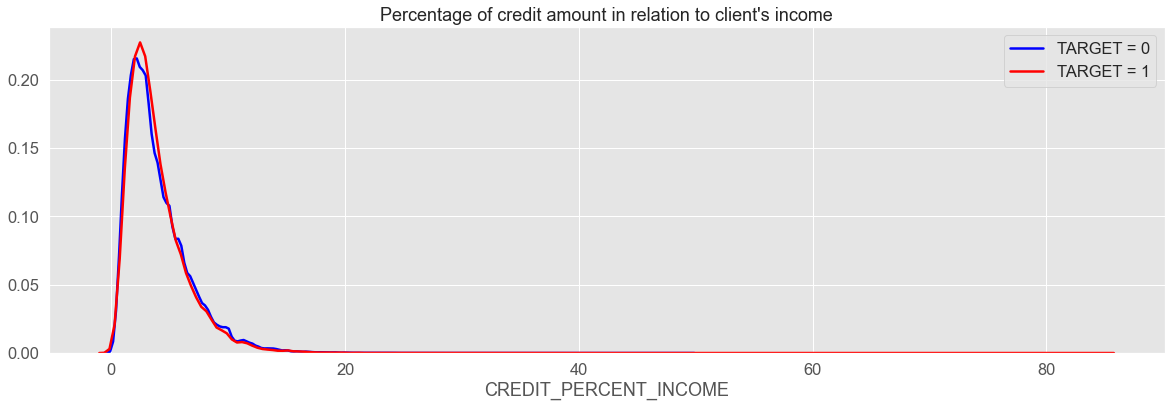

                                   -------------------------------------------------------


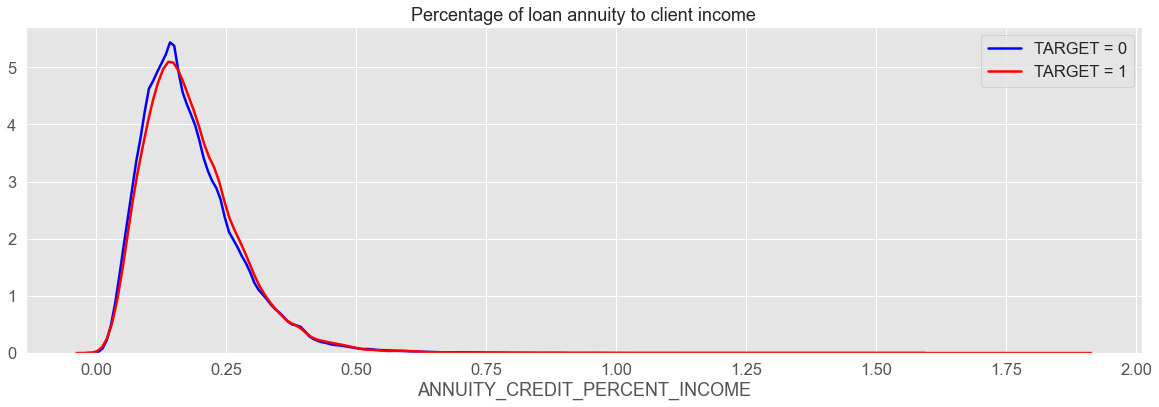

                                   -------------------------------------------------------


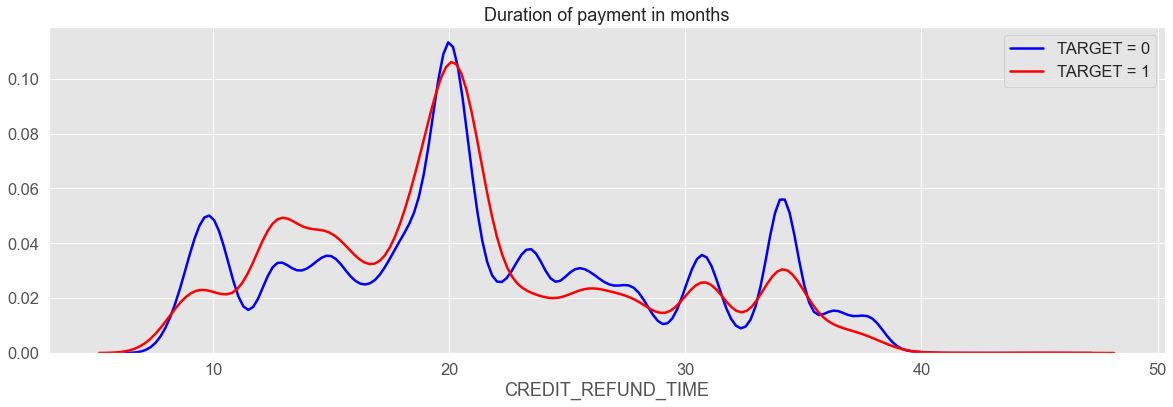

                                   -------------------------------------------------------


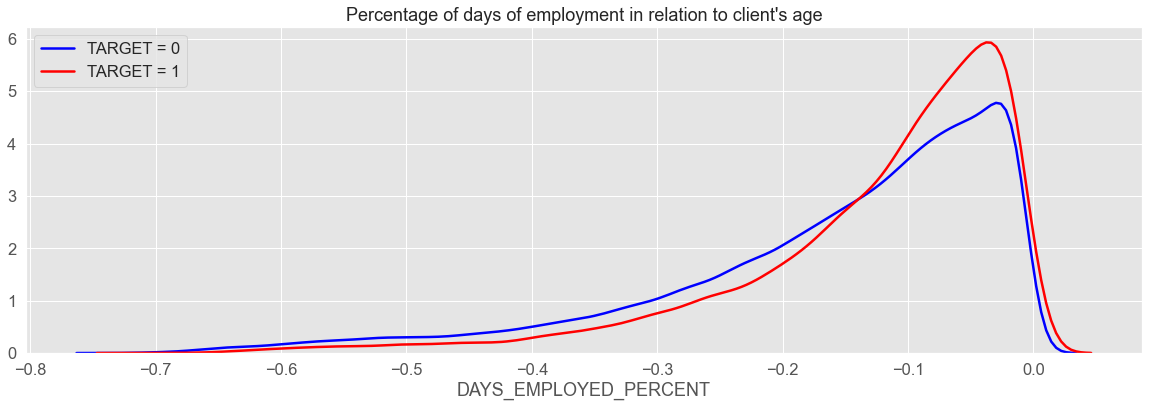

In [ ]:
plot_distribution(data,'CREDIT_PERCENT_INCOME', "Percentage of credit amount in relation to client's income", (20,6))
print("                                   -------------------------------------------------------")
plot_distribution(data,'ANNUITY_CREDIT_PERCENT_INCOME', "Percentage of loan annuity to client income", (20,6))
print("                                   -------------------------------------------------------")
plot_distribution(data,'CREDIT_REFUND_TIME', "Duration of payment in months", (20,6))
print("                                   -------------------------------------------------------")
plot_distribution(data,'DAYS_EMPLOYED_PERCENT', "Percentage of days of employment in relation to client's age", (20,6))

In [ ]:
data = data.replace(' ', '_', regex=True)

# <font color='green'>Séparation de data en train et test comme à l'origine</font>

In [ ]:
data_train = data[data['SK_ID_CURR'].isin(app_train["SK_ID_CURR"])]
data_test = data[data['SK_ID_CURR'].isin(app_test["SK_ID_CURR"])]

data_test = data_test.drop('TARGET', axis=1)

In [ ]:
print('Training Features shape origin: ', app_train.shape)
print('Testing Features shape origin: ', app_test.shape)

Training Features shape origin:  (307511, 124)
Testing Features shape origin:  (48744, 123)


In [ ]:
print('Training Features shape after merging: ', data_train.shape)
print('Testing Features shape after merging: ', data_test.shape)

Training Features shape after merging:  (307511, 131)
Testing Features shape after merging:  (48744, 130)


# <font color='green'>Cleaning </font>

## <font color='blue'>Suppression des lignes qui ont un taux de remplissage inférieur à une limite</font>

In [ ]:
find_rate = data_train.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_lines = find_rate.shape[0]
nb_columns = find_rate.shape[1]
                
find_rate['taux_remplissage_lines'] = (data_train.apply(lambda x: x.count(), axis=1)/nb_columns)
    
    
filling_rate = []
remove_line = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)

    df_2 = find_rate[find_rate['taux_remplissage_lines'] > taux_remplissage]
  
            
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]
    remove_line.append(nb_lines_supp)
  
    del df_2['taux_remplissage_lines']
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_lines': remove_line
    })
find_rate

filling_rate  remove_lines
0            0.0             0
1           10.0             0
2           20.0             0
3           30.0             0
4           40.0             0
5           50.0             6
6           60.0         37003
7           70.0        152704
8           80.0        169492
9           90.0        212032
10         100.0        307511

<AxesSubplot:xlabel='filling_rate', ylabel='remove_lines'>

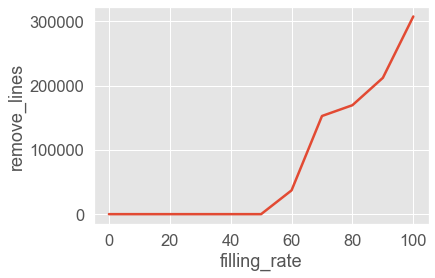

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_lines")

In [ ]:
def filtration_line(dataframe, taux_remplissage):
    df = dataframe.copy()
    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of line at origin
    nb_lines = dataframe.shape[0]
                
    df['taux_remplissage_lines'] = (dataframe.apply(lambda x: x.count(), axis=1)/nb_columns)

    df_2 = df[df['taux_remplissage_lines'] > taux_remplissage]
  
            
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]

    print("Number of lines with a fill rate higher than {:.2%} : {} lines.".format(taux_remplissage, df_2.shape[0]))
    print("Number of lines deleted : {} lines".format(nb_lines_supp))
    print(df_2.shape)
    
    del df_2['taux_remplissage_lines']

    return df_2

In [ ]:
app_train_clean_lines = filtration_line(data_train, 0.7)

Number of lines with a fill rate higher than 70.00% : 154807 lines.
Number of lines deleted : 152704 lines
(154807, 132)


In [ ]:
app_train_clean_lines.shape

(154807, 131)

In [ ]:
app_train_clean_lines.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0       100002     1.0         Cash_loans           M            N   
1       100003     0.0         Cash_loans           F            N   
12      100016     0.0         Cash_loans           F            N   
13      100017     0.0         Cash_loans           M            Y   
14      100018     0.0         Cash_loans           F            N   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                Y             0          202500.0    406597.5      24700.5   
1                N             0          270000.0   1293502.5      35698.5   
12               Y             0           67500.0     80865.0       5881.5   
13               N             1          225000.0    918468.0      28966.5   
14               Y             0          189000.0    773680.5      32778.0   

    AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0          351000.0   Unaccompanied          Working   
1         1129500.0          Family    State_servant   
12          67500.0   Unaccompanied          Working   
13         697500.0   Unaccompanied          Working   
14         679500.0   Unaccompanied          Working   

              NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0   Secondary_/_secondary_special  Single_/_not_married  House_/_apartment   
1                Higher_education               Married  House_/_apartment   
12  Secondary_/_secondary_special               Married  House_/_apartment   
13  Secondary_/_secondary_special               Married  House_/_apartment   
14  Secondary_/_secondary_special               Married  House_/_apartment   

    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                     0.018801        9461         -637.0            -3648.0   
1                     0.003541       16765        -1188.0            -1186.0   
12                    0.031329       13439        -2717.0             -311.0   
13                    0.016612       14086        -3028.0             -643.0   
14                    0.010006       14583         -203.0             -615.0   

    DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0             -2120          NaN           1               1                0   
1              -291          NaN           1               1                0   
12            -3227          NaN           1               1                1   
13            -4911         23.0           1               1                0   
14            -2056          NaN           1               1                0   

    FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                  1           1           0        Laborers              1.0   
1                  1           1           0      Core_staff              2.0   
12                 1           1           0        Laborers              2.0   
13                 1           0           0         Drivers              3.0   
14                 1           0           0        Laborers              2.0   

    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                      2                            2   
1                      1                            1   
12                     2                            2   
13                     2                            2   
14                     2                            1   

   WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                   WEDNESDAY                       10   
1                      MONDAY                       11   
12                     FRIDAY                       10   
13                   THURSDAY                       13   
14                     MONDAY                        9   

    REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                            0                           0   
1                            0 

In [ ]:
app_test_clean_lines = filtration_line(data_test, 0.7)

Number of lines with a fill rate higher than 70.00% : 25345 lines.
Number of lines deleted : 23399 lines
(25345, 131)


## <font color='blue'>Suppression des colonnes qui ont un taux de remplissage inférieur à une limite</font>

In [ ]:
find_rate = app_train_clean_lines.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_colonne = find_rate.shape[1]

filling_rate = []
remove_col = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)

    df = find_rate[find_rate.columns[1-find_rate.isnull().mean() > taux_remplissage]]
    
    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]
    
    remove_col.append(nb_colonne_supp)
  
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_columns': remove_col
    })
find_rate  
    

filling_rate  remove_columns
0            0.0               0
1           10.0               0
2           20.0               0
3           30.0               0
4           40.0               1
5           50.0               2
6           60.0               5
7           70.0              19
8           80.0              19
9           90.0              40
10         100.0             131

<AxesSubplot:xlabel='filling_rate', ylabel='remove_columns'>

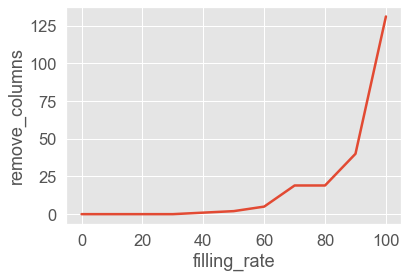

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_columns")

In [ ]:
def filtration_columns(dataframe, taux_remplissage):
    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of columns at origin
    nb_colonne = dataframe.shape[1]
    
    df = dataframe[dataframe.columns[1-dataframe.isnull().mean() > taux_remplissage]]

    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]

    print("Nombre de colonnes avec un taux de remplissage supérieur à {:.2%} : {} colonnes.".format(taux_remplissage, df.shape[1]))
    print("Nombre de colonnes supprimées : {} colonnes".format(nb_colonne_supp))

    return df

In [ ]:
app_train_reduced = filtration_columns(app_train_clean_lines, 0.8)

Nombre de colonnes avec un taux de remplissage supérieur à 80.00% : 112 colonnes.
Nombre de colonnes supprimées : 19 colonnes


In [ ]:
app_train_reduced.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0       100002     1.0         Cash_loans           M            N   
1       100003     0.0         Cash_loans           F            N   
12      100016     0.0         Cash_loans           F            N   
13      100017     0.0         Cash_loans           M            Y   
14      100018     0.0         Cash_loans           F            N   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                Y             0          202500.0    406597.5      24700.5   
1                N             0          270000.0   1293502.5      35698.5   
12               Y             0           67500.0     80865.0       5881.5   
13               N             1          225000.0    918468.0      28966.5   
14               Y             0          189000.0    773680.5      32778.0   

    AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0          351000.0   Unaccompanied          Working   
1         1129500.0          Family    State_servant   
12          67500.0   Unaccompanied          Working   
13         697500.0   Unaccompanied          Working   
14         679500.0   Unaccompanied          Working   

              NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0   Secondary_/_secondary_special  Single_/_not_married  House_/_apartment   
1                Higher_education               Married  House_/_apartment   
12  Secondary_/_secondary_special               Married  House_/_apartment   
13  Secondary_/_secondary_special               Married  House_/_apartment   
14  Secondary_/_secondary_special               Married  House_/_apartment   

    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                     0.018801        9461         -637.0            -3648.0   
1                     0.003541       16765        -1188.0            -1186.0   
12                    0.031329       13439        -2717.0             -311.0   
13                    0.016612       14086        -3028.0             -643.0   
14                    0.010006       14583         -203.0             -615.0   

    DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0             -2120           1               1                0   
1              -291           1               1                0   
12            -3227           1               1                1   
13            -4911           1               1                0   
14            -2056           1               1                0   

    FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                  1           1           0              1.0   
1                  1           1           0              2.0   
12                 1           1           0              2.0   
13                 1           0           0              3.0   
14                 1           0           0              2.0   

    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                      2                            2   
1                      1                            1   
12                     2                            2   
13                     2                            2   
14                     2                            1   

   WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                   WEDNESDAY                       10   
1                      MONDAY                       11   
12                     FRIDAY                       10   
13                   THURSDAY                       13   
14                     MONDAY                        9   

    REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                            0                           0   
1                            0                           0   
12                           0                           0   
13                           0                           0   
14                 

In [ ]:
app_train_reduced.shape

(154807, 112)

In [ ]:
if 'EXT_SOURCE_1' in app_train_reduced.columns:
    print("The column EXT_SOURCE_1 is in the datatset.")
else :
    app_train_reduced['EXT_SOURCE_1'] = app_train_clean_lines['EXT_SOURCE_1']
    print("The column EXT_SOURCE_1 has been added to the dataset.")

if 'EXT_SOURCE_2' in app_train_reduced.columns:
    print("The column EXT_SOURCE_2 is in the datatset.")
else :
    app_train_reduced['EXT_SOURCE_2'] = app_train_clean_lines['EXT_SOURCE_2']
    print("The column EXT_SOURCE_2 has been added to the dataset.")
    
if 'EXT_SOURCE_3' in app_train_reduced.columns:
    print("The column EXT_SOURCE_3 is in the datatset.")
else :
    app_train_reduced['EXT_SOURCE_3'] = app_train_clean_lines['EXT_SOURCE_3']
    print("The column EXT_SOURCE_3 has been added to the dataset.")
#----------------------------------------------------------------------------    

if 'DAYS_EMPLOYED' in app_train_reduced.columns:
    print("The column DAYS_EMPLOYED is in the datatset.")
else :
    app_train_reduced['DAYS_EMPLOYED'] = app_train_clean_lines['DAYS_EMPLOYED']
    print("The column DAYS_EMPLOYED has been added to the dataset.")
#----------------------------------------------------------------------------    
    
if 'DAYS_BIRTH' in app_train_reduced.columns:
    print("The column DAYS_BIRTH is in the datatset.")
else :
    app_train_reduced['DAYS_BIRTH'] = app_train_clean_lines['DAYS_BIRTH']
    print("The column DAYS_BIRTH has been added to the dataset.")
    
#----------------------------------------------------------------------------    
    
if 'AGE' in app_train_reduced.columns:
    print("The column AGE is in the datatset.")
else :
    app_train_reduced['AGE'] = app_train_clean_lines['AGE']
    print("The column AGE has been added to the dataset.")

The column EXT_SOURCE_1 has been added to the dataset.
The column EXT_SOURCE_2 is in the datatset.
The column EXT_SOURCE_3 is in the datatset.
The column DAYS_EMPLOYED is in the datatset.
The column DAYS_BIRTH is in the datatset.
The column AGE is in the datatset.


In [ ]:
app_train_reduced.shape

(154807, 113)

In [ ]:
filter_columns = list(app_train_reduced.columns)

In [ ]:
def remove_columns(dataframe, filter_columns):
    """dataframe : dataframe to filter
    filter_columns : columns to keep"""
    new = pd.DataFrame()

    for column in filter_columns:
        try:
            new[column] = dataframe[column]
        except:
            print('...colonne non présente : ', column)
            print('\n')
    print("All selected columns have been kept from the dataset")
    return new

In [ ]:
app_test_reduced = remove_columns(app_test_clean_lines, filter_columns)

...colonne non présente :  TARGET


All selected columns have been kept from the dataset


In [ ]:
app_test_reduced

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
307511      100001         Cash_loans           F            N   
307514      100028         Cash_loans           F            N   
307516      100042         Cash_loans           F            Y   
307519      100066         Cash_loans           F            N   
307521      100074         Cash_loans           F            N   
...            ...                ...         ...          ...   
356247      456170         Cash_loans           F            Y   
356248      456189         Cash_loans           F            N   
356249      456202         Cash_loans           F            Y   
356252      456223         Cash_loans           F            Y   
356253      456224         Cash_loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
307511               Y             0          135000.0    568800.0   
307514               Y             2          315000.0   1575000.0   
307516               Y             0          270000.0    959688.0   
307519               Y             0          315000.0    364896.0   
307521               Y             0           67500.0    675000.0   
...                ...           ...               ...         ...   
356247               Y             0          157500.0    500490.0   
356248               Y             0          270000.0    360000.0   
356249               N             3          135000.0    252022.5   
356252               Y             1          202500.0    315000.0   
356253               N             0          225000.0    450000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
307511      20560.5         450000.0   Unaccompanied               Working   
307514      49018.5        1575000.0   Unaccompanied               Working   
307516      34600.5         810000.0   Unaccompanied         State_servant   
307519      28957.5         315000.0   Unaccompanied         State_servant   
307521      25447.5         675000.0   Unaccompanied             Pensioner   
...             ...              ...             ...                   ...   
356247      48888.0         450000.0        Children             Pensioner   
356248      28570.5         360000.0   Unaccompanied  Commercial_associate   
356249      23112.0         217561.5   Unaccompanied               Working   
356252      33205.5         315000.0   Unaccompanied  Commercial_associate   
356253      25128.0         450000.0          Family  Commercial_associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
307511               Higher_education               Married   
307514  Secondary_/_secondary_special               Married   
307516  Secondary_/_secondary_special               Married   
307519               Higher_education               Married   
307521  Secondary_/_secondary_special               Married   
...                               ...                   ...   
356247  Secondary_/_secondary_special  Single_/_not_married   
356248  Secondary_/_secondary_special             Separated   
356249  Secondary_/_secondary_special        Civil_marriage   
356252  Secondary_/_secondary_special               Married   
356253               Higher_education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
307511  House_/_apartment                    0.018850      -19241   
307514  House_/_apartment                    0.026392      -13976   
307516  House_/_apartment                    0.025164      -18604   
307519  House_/_apartment                    0.046220      -12744   
307521  House_/_apartment                    0.003122      -23670   
...                   ...                         ...         ...   
356247  House_/_apartment                    0.006671      -21780   
356248   Rented_apartment                    0.026392      -19397   
356249  House_/_apartment                    0.009175      

## <font color='blue'>Imputation missing data</font>

In [ ]:
#Imputation with pandas 
def imputation_pandas(dataframe):
  short_cleaned_impute = dataframe.copy()
  for col_name in dataframe:
    short_cleaned_impute[col_name] = dataframe[col_name].interpolate(method='linear', inplace=False, limit_direction="both").ffill().bfill()
    
  return short_cleaned_impute

TRAIN

In [ ]:
app_train_reduced.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O'), dtype('bool')],
      dtype=object)

In [ ]:
# Df des features numériques.
df_num_train = app_train_reduced.select_dtypes('number').reset_index(drop = True)

# Df des features catégoriques.
df_categ_train = app_train_reduced.select_dtypes('object').reset_index(drop = True)

Imputation des colonne numérique par la méthode d'interpolation linéaire

In [ ]:
df_num_imputed_train = imputation_pandas(df_num_train)
df_num_imputed_train

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0           100002     1.0             0          202500.0    406597.5   
1           100003     0.0             0          270000.0   1293502.5   
2           100016     0.0             0           67500.0     80865.0   
3           100017     0.0             1          225000.0    918468.0   
4           100018     0.0             0          189000.0    773680.5   
...            ...     ...           ...               ...         ...   
154802      456251     0.0             0          157500.0    254700.0   
154803      456252     0.0             0           72000.0    269550.0   
154804      456253     0.0             0          153000.0    677664.0   
154805      456254     1.0             0          171000.0    370107.0   
154806      456255     0.0             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351000.0                    0.018801        9461   
1           35698.5        1129500.0                    0.003541       16765   
2            5881.5          67500.0                    0.031329       13439   
3           28966.5         697500.0                    0.016612       14086   
4           32778.0         679500.0                    0.010006       14583   
...             ...              ...                         ...         ...   
154802      27558.0         225000.0                    0.032561        9327   
154803      12001.5         225000.0                    0.025164       20775   
154804      29979.0         585000.0                    0.005002       14966   
154805      20205.0         319500.0                    0.005313       11961   
154806      49117.5         675000.0                    0.046220       16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2             -2717.0             -311.0            -3227           1   
3             -3028.0             -643.0            -4911           1   
4              -203.0             -615.0            -2056           1   
...               ...                ...              ...         ...   
154802         -236.0            -8456.0            -1982           1   
154803        -4078.5            -4388.0            -4090           1   
154804        -7921.0            -6737.0            -5150           1   
154805        -4786.0            -2562.0             -931           1   
154806        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
154802               1                0                 1           0   
154803               0                0                 1           1   
154804               1                0                 1           0   
154805               1                0                 1           0   
154806               1                1                 1           1   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                0              2.0                     1   
2                0              2.0                     2   
3                0              3.0                     2   
4                0              2.0                     2   
...            ...              ...   

Imputation colonne catégorielle par son mode

In [ ]:
df_categ_train = df_categ_train.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [ ]:
app_train_final = pd.concat([df_num_imputed_train, df_categ_train], axis=1)
app_train_final

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0           100002     1.0             0          202500.0    406597.5   
1           100003     0.0             0          270000.0   1293502.5   
2           100016     0.0             0           67500.0     80865.0   
3           100017     0.0             1          225000.0    918468.0   
4           100018     0.0             0          189000.0    773680.5   
...            ...     ...           ...               ...         ...   
154802      456251     0.0             0          157500.0    254700.0   
154803      456252     0.0             0           72000.0    269550.0   
154804      456253     0.0             0          153000.0    677664.0   
154805      456254     1.0             0          171000.0    370107.0   
154806      456255     0.0             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351000.0                    0.018801        9461   
1           35698.5        1129500.0                    0.003541       16765   
2            5881.5          67500.0                    0.031329       13439   
3           28966.5         697500.0                    0.016612       14086   
4           32778.0         679500.0                    0.010006       14583   
...             ...              ...                         ...         ...   
154802      27558.0         225000.0                    0.032561        9327   
154803      12001.5         225000.0                    0.025164       20775   
154804      29979.0         585000.0                    0.005002       14966   
154805      20205.0         319500.0                    0.005313       11961   
154806      49117.5         675000.0                    0.046220       16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2             -2717.0             -311.0            -3227           1   
3             -3028.0             -643.0            -4911           1   
4              -203.0             -615.0            -2056           1   
...               ...                ...              ...         ...   
154802         -236.0            -8456.0            -1982           1   
154803        -4078.5            -4388.0            -4090           1   
154804        -7921.0            -6737.0            -5150           1   
154805        -4786.0            -2562.0             -931           1   
154806        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
154802               1                0                 1           0   
154803               0                0                 1           1   
154804               1                0                 1           0   
154805               1                0                 1           0   
154806               1                1                 1           1   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                0              2.0                     1   
2                0              2.0                     2   
3                0              3.0                     2   
4                0              2.0                     2   
...            ...              ...   

In [ ]:
app_train_final = app_train_final.reset_index()
del app_train_final['index']

TEST

In [ ]:
# Df des features numériques.
df_num_test = app_test_reduced.select_dtypes('number').reset_index(drop = True)

# Df des features catégoriques.
df_categ_test = app_test_reduced.select_dtypes('object').reset_index(drop = True)

In [ ]:
df_num_imputed_test = imputation_pandas(df_num_test)
df_num_imputed_test

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          100001             0          135000.0    568800.0      20560.5   
1          100028             2          315000.0   1575000.0      49018.5   
2          100042             0          270000.0    959688.0      34600.5   
3          100066             0          315000.0    364896.0      28957.5   
4          100074             0           67500.0    675000.0      25447.5   
...           ...           ...               ...         ...          ...   
25340      456170             0          157500.0    500490.0      48888.0   
25341      456189             0          270000.0    360000.0      28570.5   
25342      456202             3          135000.0    252022.5      23112.0   
25343      456223             1          202500.0    315000.0      33205.5   
25344      456224             0          225000.0    450000.0      25128.0   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0             450000.0                    0.018850      -19241   -2329.000000   
1            1575000.0                    0.026392      -13976   -1866.000000   
2             810000.0                    0.025164      -18604  -12009.000000   
3             315000.0                    0.046220      -12744   -1013.000000   
4             675000.0                    0.003122      -23670   -1010.000000   
...                ...                         ...         ...            ...   
25340         450000.0                    0.006671      -21780   -1307.333333   
25341         360000.0                    0.026392      -19397    -119.000000   
25342         217561.5                    0.009175      -11708    -369.000000   
25343         315000.0                    0.026392      -15922   -3037.000000   
25344         450000.0                    0.018850      -13968   -2731.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
0                -5170.0             -812           1               1   
1                -2000.0            -4208           1               1   
2                -6116.0            -2027           1               1   
3                -1686.0            -3171           1               1   
4                -7490.0            -4136           1               0   
...                  ...              ...         ...             ...   
25340           -10745.0            -5249           1               0   
25341            -4386.0            -2945           1               1   
25342             -174.0            -4178           1               1   
25343            -2681.0            -1504           1               1   
25344            -1461.0            -1364           1               1   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0                    0                 1           0           1   
1                    0                 1           1           0   
2                    0                 1           1           0   
3                    0                 1           0           0   
4                    0                 1           1           0   
...                ...               ...         ...         ...   
25340                0                 1           1           0   
25341                0                 1           0           0   
25342                0                 1           1           0   
25343                0                 1           1           0   
25344                1                 1           1           0   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                  2.0                     2                            2   
1                  4.0                     2                            2   
2                  2.0                     2                            2   
3                  2.0                     1                            1   
4                 

In [ ]:
df_categ_test = df_categ_test.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [ ]:
app_test_final = pd.concat([df_num_imputed_test, df_categ_test], axis=1)
app_test_final

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          100001             0          135000.0    568800.0      20560.5   
1          100028             2          315000.0   1575000.0      49018.5   
2          100042             0          270000.0    959688.0      34600.5   
3          100066             0          315000.0    364896.0      28957.5   
4          100074             0           67500.0    675000.0      25447.5   
...           ...           ...               ...         ...          ...   
25340      456170             0          157500.0    500490.0      48888.0   
25341      456189             0          270000.0    360000.0      28570.5   
25342      456202             3          135000.0    252022.5      23112.0   
25343      456223             1          202500.0    315000.0      33205.5   
25344      456224             0          225000.0    450000.0      25128.0   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0             450000.0                    0.018850      -19241   -2329.000000   
1            1575000.0                    0.026392      -13976   -1866.000000   
2             810000.0                    0.025164      -18604  -12009.000000   
3             315000.0                    0.046220      -12744   -1013.000000   
4             675000.0                    0.003122      -23670   -1010.000000   
...                ...                         ...         ...            ...   
25340         450000.0                    0.006671      -21780   -1307.333333   
25341         360000.0                    0.026392      -19397    -119.000000   
25342         217561.5                    0.009175      -11708    -369.000000   
25343         315000.0                    0.026392      -15922   -3037.000000   
25344         450000.0                    0.018850      -13968   -2731.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
0                -5170.0             -812           1               1   
1                -2000.0            -4208           1               1   
2                -6116.0            -2027           1               1   
3                -1686.0            -3171           1               1   
4                -7490.0            -4136           1               0   
...                  ...              ...         ...             ...   
25340           -10745.0            -5249           1               0   
25341            -4386.0            -2945           1               1   
25342             -174.0            -4178           1               1   
25343            -2681.0            -1504           1               1   
25344            -1461.0            -1364           1               1   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0                    0                 1           0           1   
1                    0                 1           1           0   
2                    0                 1           1           0   
3                    0                 1           0           0   
4                    0                 1           1           0   
...                ...               ...         ...         ...   
25340                0                 1           1           0   
25341                0                 1           0           0   
25342                0                 1           1           0   
25343                0                 1           1           0   
25344                1                 1           1           0   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                  2.0                     2                            2   
1                  4.0                     2                            2   
2                  2.0                     2                            2   
3                  2.0                     1                            1   
4                 

In [ ]:
app_test_final = app_test_final.reset_index()
del app_test_final['index']

In [ ]:
app_train_final['SK_ID_CURR']=app_train_final['SK_ID_CURR'].astype('object')
app_train_final['TARGET']=app_train_final['TARGET'].astype('object')
app_test_final['SK_ID_CURR']=app_test_final['SK_ID_CURR'].astype('object')

## <font color='blue'>Effet de l'imputation sur Days_employed</font>

In [ ]:
#app_train_final['DAYS_EMPLOYED'].replace(np.nan, app_train_final['DAYS_EMPLOYED'].mean(), inplace = True)
#app_test_final['DAYS_EMPLOYED'].replace(np.nan, app_test_final['DAYS_EMPLOYED'].mean(), inplace = True)

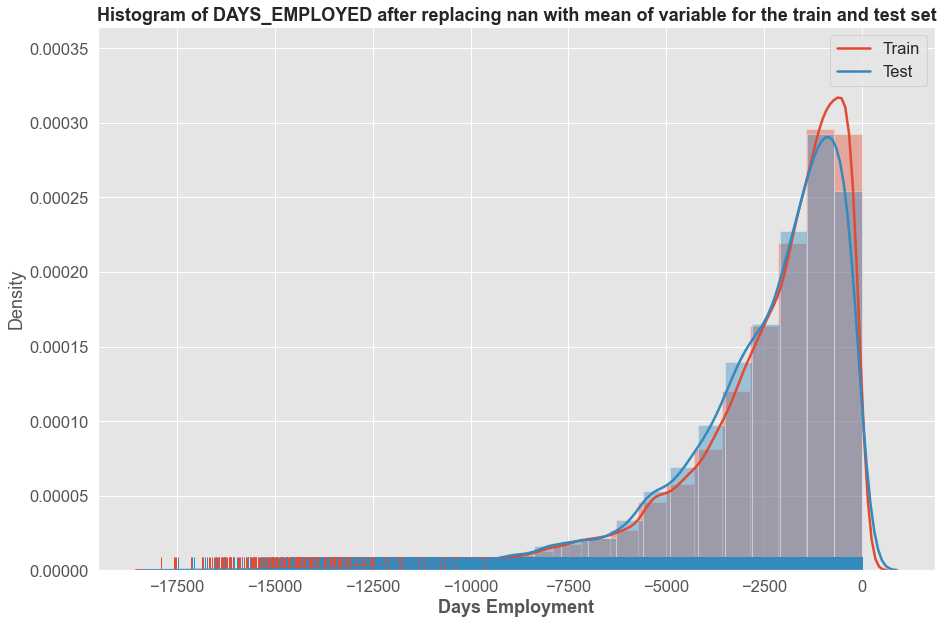

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(app_train_final['DAYS_EMPLOYED'], hist=True, rug=True, bins=25)
sns.distplot(app_test_final['DAYS_EMPLOYED'], hist=True, rug=True, bins=25)
plt.title('Histogram of DAYS_EMPLOYED after replacing nan with mean of variable for the train and test set',
          weight='bold', size=18)
plt.xlabel('Days Employment', weight="bold")
labels= ["Train", "Test"]
plt.legend(labels)
plt.show()

# <font color='green'>Standardisation (Train + Test)</font>

In [ ]:
df_num_train = app_train_final.select_dtypes(['number']).reset_index(drop = True)
df_categ_train = app_train_final.select_dtypes('object').reset_index(drop = True)

df_num_test = app_test_final.select_dtypes(['number']).reset_index(drop = True)
df_categ_test = app_test_final.select_dtypes('object').reset_index(drop = True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(df_num_train)


df_num_train_train = pd.DataFrame(scaler.transform(df_num_train), index=df_num_train.index, columns=df_num_train.columns)
df_num_test_test = pd.DataFrame(scaler.transform(df_num_test), index=df_num_test.index, columns=df_num_test.columns)

In [ ]:
df_app_train = pd.concat([df_categ_train, df_num_train_train], axis=1)
df_app_test = pd.concat([df_categ_test, df_num_test_test], axis=1)

In [ ]:
df_app_train

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0          100002    1.0         Cash_loans           M            N   
1          100003    0.0         Cash_loans           F            N   
2          100016    0.0         Cash_loans           F            N   
3          100017    0.0         Cash_loans           M            Y   
4          100018    0.0         Cash_loans           F            N   
...           ...    ...                ...         ...          ...   
154802     456251    0.0         Cash_loans           M            N   
154803     456252    0.0         Cash_loans           F            N   
154804     456253    0.0         Cash_loans           F            N   
154805     456254    1.0         Cash_loans           F            N   
154806     456255    0.0         Cash_loans           F            N   

       FLAG_OWN_REALTY NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0                    Y   Unaccompanied               Working   
1                    N          Family         State_servant   
2                    Y   Unaccompanied               Working   
3                    N   Unaccompanied               Working   
4                    Y   Unaccompanied               Working   
...                ...             ...                   ...   
154802               N   Unaccompanied               Working   
154803               Y   Unaccompanied             Pensioner   
154804               Y   Unaccompanied               Working   
154805               Y   Unaccompanied  Commercial_associate   
154806               N   Unaccompanied  Commercial_associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary_/_secondary_special  Single_/_not_married   
1                    Higher_education               Married   
2       Secondary_/_secondary_special               Married   
3       Secondary_/_secondary_special               Married   
4       Secondary_/_secondary_special               Married   
...                               ...                   ...   
154802  Secondary_/_secondary_special             Separated   
154803  Secondary_/_secondary_special                 Widow   
154804               Higher_education             Separated   
154805  Secondary_/_secondary_special               Married   
154806               Higher_education               Married   

        NAME_HOUSING_TYPE WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE  \
0       House_/_apartment                  WEDNESDAY  Business_Entity_Type_3   
1       House_/_apartment                     MONDAY                  School   
2       House_/_apartment                     FRIDAY  Business_Entity_Type_2   
3       House_/_apartment                   THURSDAY           Self-employed   
4       House_/_apartment                     MONDAY       Transport:_type_2   
...                   ...                        ...                     ...   
154802       With_parents                   THURSDAY                Services   
154803  House_/_apartment                     MONDAY  Business_Entity_Type_3   
154804  House_/_apartment                   THURSDAY                  School   
154805  House_/_apartment                  WEDNESDAY  Business_Entity_Type_1   
154806  House_/_apartment                   THURSDAY  Business_Entity_Type_3   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
0       block_of_flats       Stone,_brick                  No   
1       block_of_flats              Block                  No   
2       block_of_flats              Panel                  No   
3       block_of_flats              Panel                  No   
4       block_of_flats              Panel                  No   
...                ...                ...                 ...   
154802  block_of_flats       Stone,_brick                  No   
154803  block_of_flats       Stone,_brick                  No   
154804  block_of_flats              Panel                  No   
15480

In [ ]:
df_app_train.shape

(154807, 112)

In [ ]:
df_app_test.shape

(25345, 111)

# <font color='green'>Encoding (Train + Test)</font>

With Standardisation

In [ ]:
df_app_train.shape

(154807, 112)

Pour les variables catégorielles avec de nombreuses classes, one hot encoding est l'approche la plus sûre car elle n'impose pas de valeurs arbitraires aux catégories. Le seul inconvénient du one hot encoding est que le nombre de caractéristiques (dimensions des données) peut exploser avec des variables catégorielles comportant de nombreuses catégories.

Mettons en œuvre la politique décrite ci-dessus : pour toute variable catégorielle (dtype == object) avec 2 catégories uniques, nous utiliserons l'encodage par label, et pour toute variable catégorielle avec plus de 2 catégories uniques, nous utiliserons l'encodage one-hot.

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
oh_count = 0

# Iterate through the columns
for col in df_app_train:
    if col == 'TARGET' or col == 'SK_ID_CURR':
        pass
    else :
        if df_app_train[col].dtype == 'object':        
        # If 2 or fewer unique categories
            if len(list(df_app_train[col].unique())) <= 2:
                # Train on the training data
                le.fit(df_app_train[col])
                # Transform both training and testing data
                df_app_train[col] = le.transform(df_app_train[col])
                df_app_test[col] = le.transform(df_app_test[col])
            
            # Keep track of how many columns were label encoded
                le_count += 1
                
            else :
                #else : one hot encoding
                df_app_train = pd.get_dummies(df_app_train, prefix=[col], columns=[col])
                df_app_test = pd.get_dummies(df_app_test, prefix=[col], columns=[col])
                oh_count += 1
                
print('%d columns were label encoded.' % le_count)
print('Training Features shape: ', df_app_train.shape)
print('Testing Features shape: ', df_app_test.shape)
print('%d columns were one hot encoded.' % oh_count)

5 columns were label encoded.
Training Features shape:  (154807, 217)
Testing Features shape:  (25345, 211)
10 columns were one hot encoded.


Il doit y avoir les mêmes caractéristiques (colonnes) dans les données de formation et de test. L'encodage a créé plus de colonnes dans les données d'apprentissage car certaines variables catégorielles avaient plus de catégories non représentées que dans les données de test. Pour supprimer les colonnes dans les données d'apprentissage qui ne sont pas dans les données de test, nous devons aligner les cadres de données. Tout d'abord, nous extrayons la colonne cible des données de formation (car elle ne figure pas dans les données de test mais nous devons conserver cette information). Lorsque nous effectuons l'alignement, nous devons nous assurer de définir axis = 1 pour aligner les cadres de données sur les colonnes et non sur les lignes.

In [ ]:
train_labels = df_app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_app_train, df_app_test = df_app_train.align(df_app_test, join = 'inner', axis = 1)

# Add the target back in
df_app_train['TARGET'] = train_labels

print('Training Features shape: ', df_app_train.shape)
print('Testing Features shape: ', df_app_test.shape)

Training Features shape:  (154807, 212)
Testing Features shape:  (25345, 211)


In [ ]:
df_app_train

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0          100002                   0            1             0   
1          100003                   0            0             0   
2          100016                   0            0             0   
3          100017                   0            1             1   
4          100018                   0            0             0   
...           ...                 ...          ...           ...   
154802     456251                   0            1             0   
154803     456252                   0            0             0   
154804     456253                   0            0             0   
154805     456254                   0            0             0   
154806     456255                   0            0             0   

        FLAG_OWN_REALTY  EMERGENCYSTATE_MODE  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0                     1                    0     -0.573222          0.069058   
1                     0                    0     -0.573222          0.282931   
2                     1                    0     -0.573222         -0.358688   
3                     0                    0      0.890172          0.140349   
4                     1                    0     -0.573222          0.026283   
...                 ...                  ...           ...               ...   
154802                0                    0     -0.573222         -0.073524   
154803                1                    0     -0.573222         -0.344430   
154804                1                    0     -0.573222         -0.087782   
154805                1                    0     -0.573222         -0.030750   
154806                0                    0     -0.573222         -0.073524   

        AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0        -0.513860    -0.222911        -0.544493                   -0.226831   
1         1.597394     0.500488         1.467988                   -1.206771   
2        -1.289258    -1.460739        -1.277362                    0.577670   
3         0.704634     0.057687         0.351236                   -0.367401   
4         0.359971     0.308390         0.304704                   -0.791613   
...            ...          ...              ...                         ...   
154802   -0.875448    -0.034957        -0.870213                    0.656785   
154803   -0.840098    -1.058193        -0.870213                    0.181777   
154804    0.131407     0.124285         0.060415                   -1.112951   
154805   -0.600725    -0.518604        -0.625923                   -1.092980   
154806    0.125065     1.383128         0.293071                    1.533914   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0        -1.521797       0.784979           0.435145         0.592401   
1         0.151362       0.546259           1.116256         1.801065   
2        -0.610539      -0.116181           1.358324        -0.139141   
3        -0.462328      -0.250921           1.266477        -1.251984   
4        -0.348478       0.973010           1.274223         0.634695   
...            ...            ...                ...              ...   
154802   -1.552493       0.958713          -0.894985         0.683596   
154803    1.069950      -0.706050           0.230425        -0.709440   
154804   -0.260742      -2.370813          -0.419425        -1.409923   
154805   -0.949111      -1.012575           0.735586         1.378132   
154806    0.172208       0.514198           0.025704         1.722426   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0         0.002542        0.458151         -0.46321          0.047807   
1         0.002542        0.458151         -0.46321          0.047807   
2         0.002542        0.458151          2.15885          0.047807   
3         0.002542        0.458151         -0.46321          0.047807   
4         0.002542        

Without Standardisation

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
oh_count = 0

# Iterate through the columns
for col in app_train_final:
    if col == 'TARGET' or col == 'SK_ID_CURR':
        pass
    else :
        if app_train_final[col].dtype == 'object':        
        # If 2 or fewer unique categories
            if len(list(app_train_final[col].unique())) <= 2:
                # Train on the training data
                le.fit(app_train_final[col])
                # Transform both training and testing data
                app_train_final[col] = le.transform(app_train_final[col])
                app_test_final[col] = le.transform(app_test_final[col])
            
            # Keep track of how many columns were label encoded
                le_count += 1
                
            else :
                #else : one hot encoding
                app_train_final = pd.get_dummies(app_train_final, prefix=[col], columns=[col])
                app_test_final = pd.get_dummies(app_test_final, prefix=[col], columns=[col])
                oh_count += 1
                
print('%d columns were label encoded.' % le_count)
print('Training Features shape: ', app_train_final.shape)
print('Testing Features shape: ', app_test_final.shape)
print('%d columns were one hot encoded.' % oh_count)

5 columns were label encoded.
Training Features shape:  (154807, 217)
Testing Features shape:  (25345, 211)
10 columns were one hot encoded.


In [ ]:
train_labels = app_train_final['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train_final, app_test_final = app_train_final.align(app_test_final, join = 'inner', axis = 1)

# Add the target back in
app_train_final['TARGET'] = train_labels

print('Training Features shape: ', app_train_final.shape)
print('Testing Features shape: ', app_test_final.shape)

Training Features shape:  (154807, 212)
Testing Features shape:  (25345, 211)


In [ ]:
app_train_final

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          100002             0          202500.0    406597.5      24700.5   
1          100003             0          270000.0   1293502.5      35698.5   
2          100016             0           67500.0     80865.0       5881.5   
3          100017             1          225000.0    918468.0      28966.5   
4          100018             0          189000.0    773680.5      32778.0   
...           ...           ...               ...         ...          ...   
154802     456251             0          157500.0    254700.0      27558.0   
154803     456252             0           72000.0    269550.0      12001.5   
154804     456253             0          153000.0    677664.0      29979.0   
154805     456254             0          171000.0    370107.0      20205.0   
154806     456255             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801        9461   
1             1129500.0                    0.003541       16765   
2               67500.0                    0.031329       13439   
3              697500.0                    0.016612       14086   
4              679500.0                    0.010006       14583   
...                 ...                         ...         ...   
154802         225000.0                    0.032561        9327   
154803         225000.0                    0.025164       20775   
154804         585000.0                    0.005002       14966   
154805         319500.0                    0.005313       11961   
154806         675000.0                    0.046220       16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2             -2717.0             -311.0            -3227           1   
3             -3028.0             -643.0            -4911           1   
4              -203.0             -615.0            -2056           1   
...               ...                ...              ...         ...   
154802         -236.0            -8456.0            -1982           1   
154803        -4078.5            -4388.0            -4090           1   
154804        -7921.0            -6737.0            -5150           1   
154805        -4786.0            -2562.0             -931           1   
154806        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
154802               1                0                 1           0   
154803               0                0                 1           1   
154804               1                0                 1           0   
154805               1                0                 1           0   
154806               1                1                 1           1   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                0              2.0                     1   
2                0              2.0                     2   
3                0              3.0                     2   
4                0              2.0                     2   
...            ...              ...                   ...   
154802           0              1.0                     1   
154803           0     

In [ ]:
app_train_final.to_csv("train_imputed_without_standardisation.csv", index=False)
app_test_final.to_csv("test_imputed_without_standardisation.csv", index=False)

# <font color='green'>Sauvegarde CSVs </font>

In [ ]:
df_app_train.to_csv("df_train_imputed.csv", index=False)
df_app_test.to_csv("df_test_imputed.csv", index=False)

In [ ]:
app_train_reduced.to_csv("real_data_clean_train.csv", index=False)
app_test_reduced.to_csv("real_data_clean_test.csv", index=False)

In [ ]:
app_train_reduced

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002     1.0         Cash_loans           M            N   
1           100003     0.0         Cash_loans           F            N   
12          100016     0.0         Cash_loans           F            N   
13          100017     0.0         Cash_loans           M            Y   
14          100018     0.0         Cash_loans           F            N   
...            ...     ...                ...         ...          ...   
307506      456251     0.0         Cash_loans           M            N   
307507      456252     0.0         Cash_loans           F            N   
307508      456253     0.0         Cash_loans           F            N   
307509      456254     1.0         Cash_loans           F            N   
307510      456255     0.0         Cash_loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
12                   Y             0           67500.0     80865.0   
13                   N             1          225000.0    918468.0   
14                   Y             0          189000.0    773680.5   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State_servant   
12           5881.5          67500.0   Unaccompanied               Working   
13          28966.5         697500.0   Unaccompanied               Working   
14          32778.0         679500.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial_associate   
307510      49117.5         675000.0   Unaccompanied  Commercial_associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary_/_secondary_special  Single_/_not_married   
1                    Higher_education               Married   
12      Secondary_/_secondary_special               Married   
13      Secondary_/_secondary_special               Married   
14      Secondary_/_secondary_special               Married   
...                               ...                   ...   
307506  Secondary_/_secondary_special             Separated   
307507  Secondary_/_secondary_special                 Widow   
307508               Higher_education             Separated   
307509  Secondary_/_secondary_special               Married   
307510               Higher_education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House_/_apartment                    0.018801        9461   
1       House_/_apartment                    0.003541       16765   
12      House_/_apartment                    0.031329       13439   
13      House_/_apartment                    0.016612       14086   
14      House_/_apartment                    0.010006       14583   
...                   ...                         ...         ...   
307506       With_parents                    0.032561        9327   
307507  House_/_apartment       

In [ ]:
df_app_train

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0          100002                   0            1             0   
1          100003                   0            0             0   
2          100016                   0            0             0   
3          100017                   0            1             1   
4          100018                   0            0             0   
...           ...                 ...          ...           ...   
154802     456251                   0            1             0   
154803     456252                   0            0             0   
154804     456253                   0            0             0   
154805     456254                   0            0             0   
154806     456255                   0            0             0   

        FLAG_OWN_REALTY  EMERGENCYSTATE_MODE  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0                     1                    0     -0.573222          0.069058   
1                     0                    0     -0.573222          0.282931   
2                     1                    0     -0.573222         -0.358688   
3                     0                    0      0.890172          0.140349   
4                     1                    0     -0.573222          0.026283   
...                 ...                  ...           ...               ...   
154802                0                    0     -0.573222         -0.073524   
154803                1                    0     -0.573222         -0.344430   
154804                1                    0     -0.573222         -0.087782   
154805                1                    0     -0.573222         -0.030750   
154806                0                    0     -0.573222         -0.073524   

        AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0        -0.513860    -0.222911        -0.544493                   -0.226831   
1         1.597394     0.500488         1.467988                   -1.206771   
2        -1.289258    -1.460739        -1.277362                    0.577670   
3         0.704634     0.057687         0.351236                   -0.367401   
4         0.359971     0.308390         0.304704                   -0.791613   
...            ...          ...              ...                         ...   
154802   -0.875448    -0.034957        -0.870213                    0.656785   
154803   -0.840098    -1.058193        -0.870213                    0.181777   
154804    0.131407     0.124285         0.060415                   -1.112951   
154805   -0.600725    -0.518604        -0.625923                   -1.092980   
154806    0.125065     1.383128         0.293071                    1.533914   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0        -1.521797       0.784979           0.435145         0.592401   
1         0.151362       0.546259           1.116256         1.801065   
2        -0.610539      -0.116181           1.358324        -0.139141   
3        -0.462328      -0.250921           1.266477        -1.251984   
4        -0.348478       0.973010           1.274223         0.634695   
...            ...            ...                ...              ...   
154802   -1.552493       0.958713          -0.894985         0.683596   
154803    1.069950      -0.706050           0.230425        -0.709440   
154804   -0.260742      -2.370813          -0.419425        -1.409923   
154805   -0.949111      -1.012575           0.735586         1.378132   
154806    0.172208       0.514198           0.025704         1.722426   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0         0.002542        0.458151         -0.46321          0.047807   
1         0.002542        0.458151         -0.46321          0.047807   
2         0.002542        0.458151          2.15885          0.047807   
3         0.002542        0.458151         -0.46321          0.047807   
4         0.002542        

In [ ]:
app_train_final

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          100002             0          202500.0    406597.5      24700.5   
1          100003             0          270000.0   1293502.5      35698.5   
2          100016             0           67500.0     80865.0       5881.5   
3          100017             1          225000.0    918468.0      28966.5   
4          100018             0          189000.0    773680.5      32778.0   
...           ...           ...               ...         ...          ...   
154802     456251             0          157500.0    254700.0      27558.0   
154803     456252             0           72000.0    269550.0      12001.5   
154804     456253             0          153000.0    677664.0      29979.0   
154805     456254             0          171000.0    370107.0      20205.0   
154806     456255             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801        9461   
1             1129500.0                    0.003541       16765   
2               67500.0                    0.031329       13439   
3              697500.0                    0.016612       14086   
4              679500.0                    0.010006       14583   
...                 ...                         ...         ...   
154802         225000.0                    0.032561        9327   
154803         225000.0                    0.025164       20775   
154804         585000.0                    0.005002       14966   
154805         319500.0                    0.005313       11961   
154806         675000.0                    0.046220       16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2             -2717.0             -311.0            -3227           1   
3             -3028.0             -643.0            -4911           1   
4              -203.0             -615.0            -2056           1   
...               ...                ...              ...         ...   
154802         -236.0            -8456.0            -1982           1   
154803        -4078.5            -4388.0            -4090           1   
154804        -7921.0            -6737.0            -5150           1   
154805        -4786.0            -2562.0             -931           1   
154806        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
154802               1                0                 1           0   
154803               0                0                 1           1   
154804               1                0                 1           0   
154805               1                0                 1           0   
154806               1                1                 1           1   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                0              2.0                     1   
2                0              2.0                     2   
3                0              3.0                     2   
4                0              2.0                     2   
...            ...              ...                   ...   
154802           0              1.0                     1   
154803           0     